In [1]:
import pandas as pd 
import numpy as np
import re

##LDA stuff
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##cleaning stuff
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim.corpora as corpora

In [2]:
df = pd.read_csv('../data/cleaned/cleaned_ibis-sg-bencoolen.csv')
df.head()

Unnamed: 0                date_of_stay traveller_username  \
0           0   Date of stay: August 2023   Love_Life_Sydney   
1           1   Date of stay: August 2023            Bilal S   
2           2  Date of stay: October 2022   Anthony Fernando   
3           3   Date of stay: August 2023            Mjkc204   
4           4   Date of stay: August 2022         Aung Nanda   

                      review_title  \
0            Clean and comfortable   
1      Good hotel, great location    
2   Good place for a decent price.   
3  Great Location and great staff.   
4            Good for budget stay.   

                                         review_text  \
0  Hotel rooms in Singapore are so expensive so t...   
1  This is a great place! Location is great but t...   
2  Good place good price  Easy access to the city...   
3  The IBIS was a neat and tidy hotel in line wit...   
4  I stayed there for 7 days. It was a nice locat...   

                         travel_type     traveller_country_origin  \
0   Trip type: Travelled as a couple            Sydney, Australia   
1   Trip type: Travelled with family               Houston, Texas   
2  Trip type: Travelled with friends  Dubai, United Arab Emirates   
3          Trip type: Travelled solo        Ellenbrook, Australia   
4   Trip type: Travelled on business  Dubai, United Arab Emirates   

   traveller_total_contributions  traveller_total_helpful_contributions  \
0                         2302.0                                  871.0   
1                            4.0                                    NaN   
2                           39.0                                   38.0   
3                           37.0                                   19.0   
4                            3.0                                    4.0   

   rating1  rating2  rating  valid_rating     label  \
0      NaN      4.0     4.0          True  Positive   
1      5.0      NaN     5.0          True  Positive   
2      5.0      NaN     5.0          True  Positive   
3      5.0      NaN     5.0          True  Positive   
4      NaN      4.0     4.0          True  Positive   

                                      cleaned_review  \
0  clean comfortable hotel room singapore expensi...   
1  good hotel great location great place location...   
2  good place decent price good place good price ...   
3  great location great staff ibis neat tidy hote...   
4  good budget stay I stay day nice location seve...   

                                     combined_review        date      covid  
0  Clean and comfortable Hotel rooms in Singapore...  2023-08-01  PostCovid  
1  Good hotel, great location  This is a great pl...  2023-08-01  PostCovid  
2  Good place for a decent price. Good place good...  2022-10-01  PostCovid  
3  Great Location and great staff. The IBIS was a...  2023-08-01  PostCovid  
4  Good for budget stay. I stayed there for 7 day...  2022-08-01  PostCovid

In [3]:
df_precovid = df[df['covid'] == 'PreCovid']
df_precovid.head()

Unnamed: 0                 date_of_stay traveller_username  \
66          66  Date of stay: December 2019           Beatrice   
67          67   Date of stay: January 2020             dinu79   
68          68   Date of stay: October 2019           Marsha F   
69          69   Date of stay: October 2019     Geoff_and_Juls   
70          70   Date of stay: October 2019       Gianluca3008   

                                    review_title  \
66                                    Cozy Hotel   
67  Smart, Clean, Good Location, Value for money   
68                          Wonderful experience   
69                       Great Base for Tourists   
70                                 BEST LOCATION   

                                          review_text travel_type  \
66  I spent 2 night at this hotel and all the serv...         NaN   
67  This was my second stay at Ibis Bencoolen.   B...         NaN   
68  This was our first time at this hotel, and won...         NaN   
69  Firstly, the good points: Comfortable and clea...         NaN   
70  Very comfortable hotel, nice staff, totally in...         NaN   

       traveller_country_origin  traveller_total_contributions  \
66             Batam, Indonesia                            8.0   
67  Dubai, United Arab Emirates                          212.0   
68             Gatineau, Canada                           32.0   
69              Mellieha, Malta                          276.0   
70                  Rome, Italy                         2192.0   

    traveller_total_helpful_contributions  rating1  rating2  rating  \
66                                   13.0      5.0      NaN     5.0   
67                                   53.0      4.0      NaN     4.0   
68                                   45.0      4.0      NaN     4.0   
69                                  169.0      4.0      NaN     4.0   
70                                  280.0      NaN      4.0     4.0   

    valid_rating     label                                     cleaned_review  \
66          True  Positive  cozy hotel I spend night hotel service provide...   
67          True  Positive  smart clean good location value money second s...   
68          True  Positive  wonderful experience first time hotel win last...   
69          True  Positive  great base tourist firstly good point comforta...   
70          True  Positive  good location comfortable hotel nice staff tot...   

                                      combined_review        date     covid  
66  Cozy Hotel I spent 2 night at this hotel and a...  2019-12-01  PreCovid  
67  Smart, Clean, Good Location, Value for money T...  2020-01-01  PreCovid  
68  Wonderful experience This was our first time a...  2019-10-01  PreCovid  
69  Great Base for Tourists Firstly, the good poin...  2019-10-01  PreCovid  
70  BEST LOCATION Very comfortable hotel, nice sta...  2019-10-01  PreCovid

## Cleaning Data

In [4]:
##filter for year >= 2015
df_precovid['date_of_stay'] = pd.to_datetime(df_precovid['date_of_stay'], format='Date of stay: %B %Y')
df_precovid_filtered = df_precovid[df_precovid['date_of_stay'].dt.year >= 2015]

##preprocess text
nltk.download('stopwords')
nltk.download('words')
# Get the list of valid English words
english_words = set(words.words())
# set stopwords
sw = stopwords.words('english')
sw.append('ibis')
stop_words = set(sw)
lemmatizer = WordNetLemmatizer()

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\3120336250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_precovid['date_of_stay'] = pd.to_datetime(df_precovid['date_of_stay'], format='Date of stay: %B %Y')
[nltk_data] Downloading package stopwords to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [5]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [6]:
def remove_non_english_words(text, valid_words):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() in valid_words]
    return ' '.join(ans)

def remove_stopwords(text):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() not in stop_words]
    return ' '.join(ans)

In [7]:
df_precovid['cleaned_review'] = df_precovid['cleaned_review'].apply(remove_stopwords)
df_precovid['cleaned_review'] = df_precovid['cleaned_review'].apply(remove_non_english_words, valid_words=english_words)
df_precovid['tokens'] = df_precovid['cleaned_review'].apply(preprocess_text)

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\731993693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_precovid['cleaned_review'] = df_precovid['cleaned_review'].apply(remove_stopwords)
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\731993693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_precovid['cleaned_review'] = df_precovid['cleaned_review'].apply(remove_non_english_words, valid_words=english_words)
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\731993693.py:3: Settin

In [8]:
df_precovid['tokens']

66      [cozy, hotel, spend, night, hotel, service, pr...
67      [smart, clean, good, location, value, money, s...
68      [wonderful, experience, first, time, hotel, wi...
69      [great, base, tourist, firstly, good, point, c...
70      [good, location, comfortable, hotel, nice, sta...
                              ...                        
5928    [enjoy, stay, good, new, hotel, though, room, ...
5929    [great, location, great, price, stay, night, p...
5930    [brand, new, room, comfortable, however, staff...
5931    [centrally, locate, open, friend, recommend, c...
5932    [stay, take, advantage, special, opening, week...
Name: tokens, Length: 5850, dtype: object

# 3 Topics

## LDA pre-covid

In [9]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_precovid['tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_precovid['tokens']]

In [10]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=3, id2word=pre_dict, passes=15)

In [11]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = pre_ldamodel.show_topics(num_topics=4, num_words=10)
topics_with_low_relevance = pre_ldamodel.show_topics(num_topics=4, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.042*"room" + 0.041*"hotel" + 0.040*"good" + 0.028*"stay" + 0.021*"location" + 0.020*"clean" + 0.018*"staff" + 0.017*"great" + 0.016*"breakfast" + 0.014*"small"
Topic 1: 0.033*"room" + 0.026*"hotel" + 0.015*"check" + 0.014*"stay" + 0.010*"one" + 0.009*"get" + 0.009*"time" + 0.008*"night" + 0.007*"small" + 0.007*"staff"
Topic 2: 0.051*"hotel" + 0.026*"good" + 0.024*"location" + 0.023*"walk" + 0.018*"stay" + 0.018*"room" + 0.015*"great" + 0.014*"food" + 0.014*"clean" + 0.012*"bus"

Topics with low relevance:
Topic 0: 0.042*"room" + 0.041*"hotel" + 0.040*"good" + 0.028*"stay" + 0.021*"location"
Topic 1: 0.033*"room" + 0.026*"hotel" + 0.015*"check" + 0.014*"stay" + 0.010*"one"
Topic 2: 0.051*"hotel" + 0.026*"good" + 0.024*"location" + 0.023*"walk" + 0.018*"stay"


## LDA post-covid

In [12]:
df_postcovid = df[df['covid'] == 'PostCovid']
df_postcovid.head()

Unnamed: 0                date_of_stay traveller_username  \
0           0   Date of stay: August 2023   Love_Life_Sydney   
1           1   Date of stay: August 2023            Bilal S   
2           2  Date of stay: October 2022   Anthony Fernando   
3           3   Date of stay: August 2023            Mjkc204   
4           4   Date of stay: August 2022         Aung Nanda   

                      review_title  \
0            Clean and comfortable   
1      Good hotel, great location    
2   Good place for a decent price.   
3  Great Location and great staff.   
4            Good for budget stay.   

                                         review_text  \
0  Hotel rooms in Singapore are so expensive so t...   
1  This is a great place! Location is great but t...   
2  Good place good price  Easy access to the city...   
3  The IBIS was a neat and tidy hotel in line wit...   
4  I stayed there for 7 days. It was a nice locat...   

                         travel_type     traveller_country_origin  \
0   Trip type: Travelled as a couple            Sydney, Australia   
1   Trip type: Travelled with family               Houston, Texas   
2  Trip type: Travelled with friends  Dubai, United Arab Emirates   
3          Trip type: Travelled solo        Ellenbrook, Australia   
4   Trip type: Travelled on business  Dubai, United Arab Emirates   

   traveller_total_contributions  traveller_total_helpful_contributions  \
0                         2302.0                                  871.0   
1                            4.0                                    NaN   
2                           39.0                                   38.0   
3                           37.0                                   19.0   
4                            3.0                                    4.0   

   rating1  rating2  rating  valid_rating     label  \
0      NaN      4.0     4.0          True  Positive   
1      5.0      NaN     5.0          True  Positive   
2      5.0      NaN     5.0          True  Positive   
3      5.0      NaN     5.0          True  Positive   
4      NaN      4.0     4.0          True  Positive   

                                      cleaned_review  \
0  clean comfortable hotel room singapore expensi...   
1  good hotel great location great place location...   
2  good place decent price good place good price ...   
3  great location great staff ibis neat tidy hote...   
4  good budget stay I stay day nice location seve...   

                                     combined_review        date      covid  
0  Clean and comfortable Hotel rooms in Singapore...  2023-08-01  PostCovid  
1  Good hotel, great location  This is a great pl...  2023-08-01  PostCovid  
2  Good place for a decent price. Good place good...  2022-10-01  PostCovid  
3  Great Location and great staff. The IBIS was a...  2023-08-01  PostCovid  
4  Good for budget stay. I stayed there for 7 day...  2022-08-01  PostCovid

In [13]:
df_postcovid['cleaned_review'] = df_postcovid['cleaned_review'].apply(remove_stopwords)
df_postcovid['cleaned_review'] = df_postcovid['cleaned_review'].apply(remove_non_english_words, valid_words=english_words)
df_postcovid['tokens'] = df_postcovid['cleaned_review'].apply(preprocess_text)

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\2993378324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_postcovid['cleaned_review'] = df_postcovid['cleaned_review'].apply(remove_stopwords)
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\2993378324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_postcovid['cleaned_review'] = df_postcovid['cleaned_review'].apply(remove_non_english_words, valid_words=english_words)
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\2993378324.py:3:

In [14]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(df_postcovid['tokens'])
post_corpus = [post_dict.doc2bow(text) for text in df_postcovid['tokens']]

In [15]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=3, id2word=post_dict, passes=15)

In [16]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = post_ldamodel.show_topics(num_topics=4, num_words=10)
topics_with_low_relevance = post_ldamodel.show_topics(num_topics=4, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.030*"room" + 0.025*"hotel" + 0.018*"good" + 0.013*"stay" + 0.013*"location" + 0.012*"great" + 0.011*"service" + 0.011*"clean" + 0.010*"staff" + 0.009*"small"
Topic 1: 0.024*"good" + 0.021*"stay" + 0.020*"room" + 0.019*"hotel" + 0.014*"check" + 0.010*"breakfast" + 0.009*"nice" + 0.008*"staff" + 0.008*"get" + 0.007*"location"
Topic 2: 0.022*"room" + 0.020*"hotel" + 0.014*"location" + 0.014*"clean" + 0.012*"great" + 0.010*"stay" + 0.009*"staff" + 0.009*"comfortable" + 0.008*"good" + 0.008*"bed"

Topics with low relevance:
Topic 0: 0.030*"room" + 0.025*"hotel" + 0.018*"good" + 0.013*"stay" + 0.013*"location"
Topic 1: 0.024*"good" + 0.021*"stay" + 0.020*"room" + 0.019*"hotel" + 0.014*"check"
Topic 2: 0.022*"room" + 0.020*"hotel" + 0.014*"location" + 0.014*"clean" + 0.012*"great"


In [17]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [18]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in df_precovid['tokens'] for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in df_postcovid['tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\874529396.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


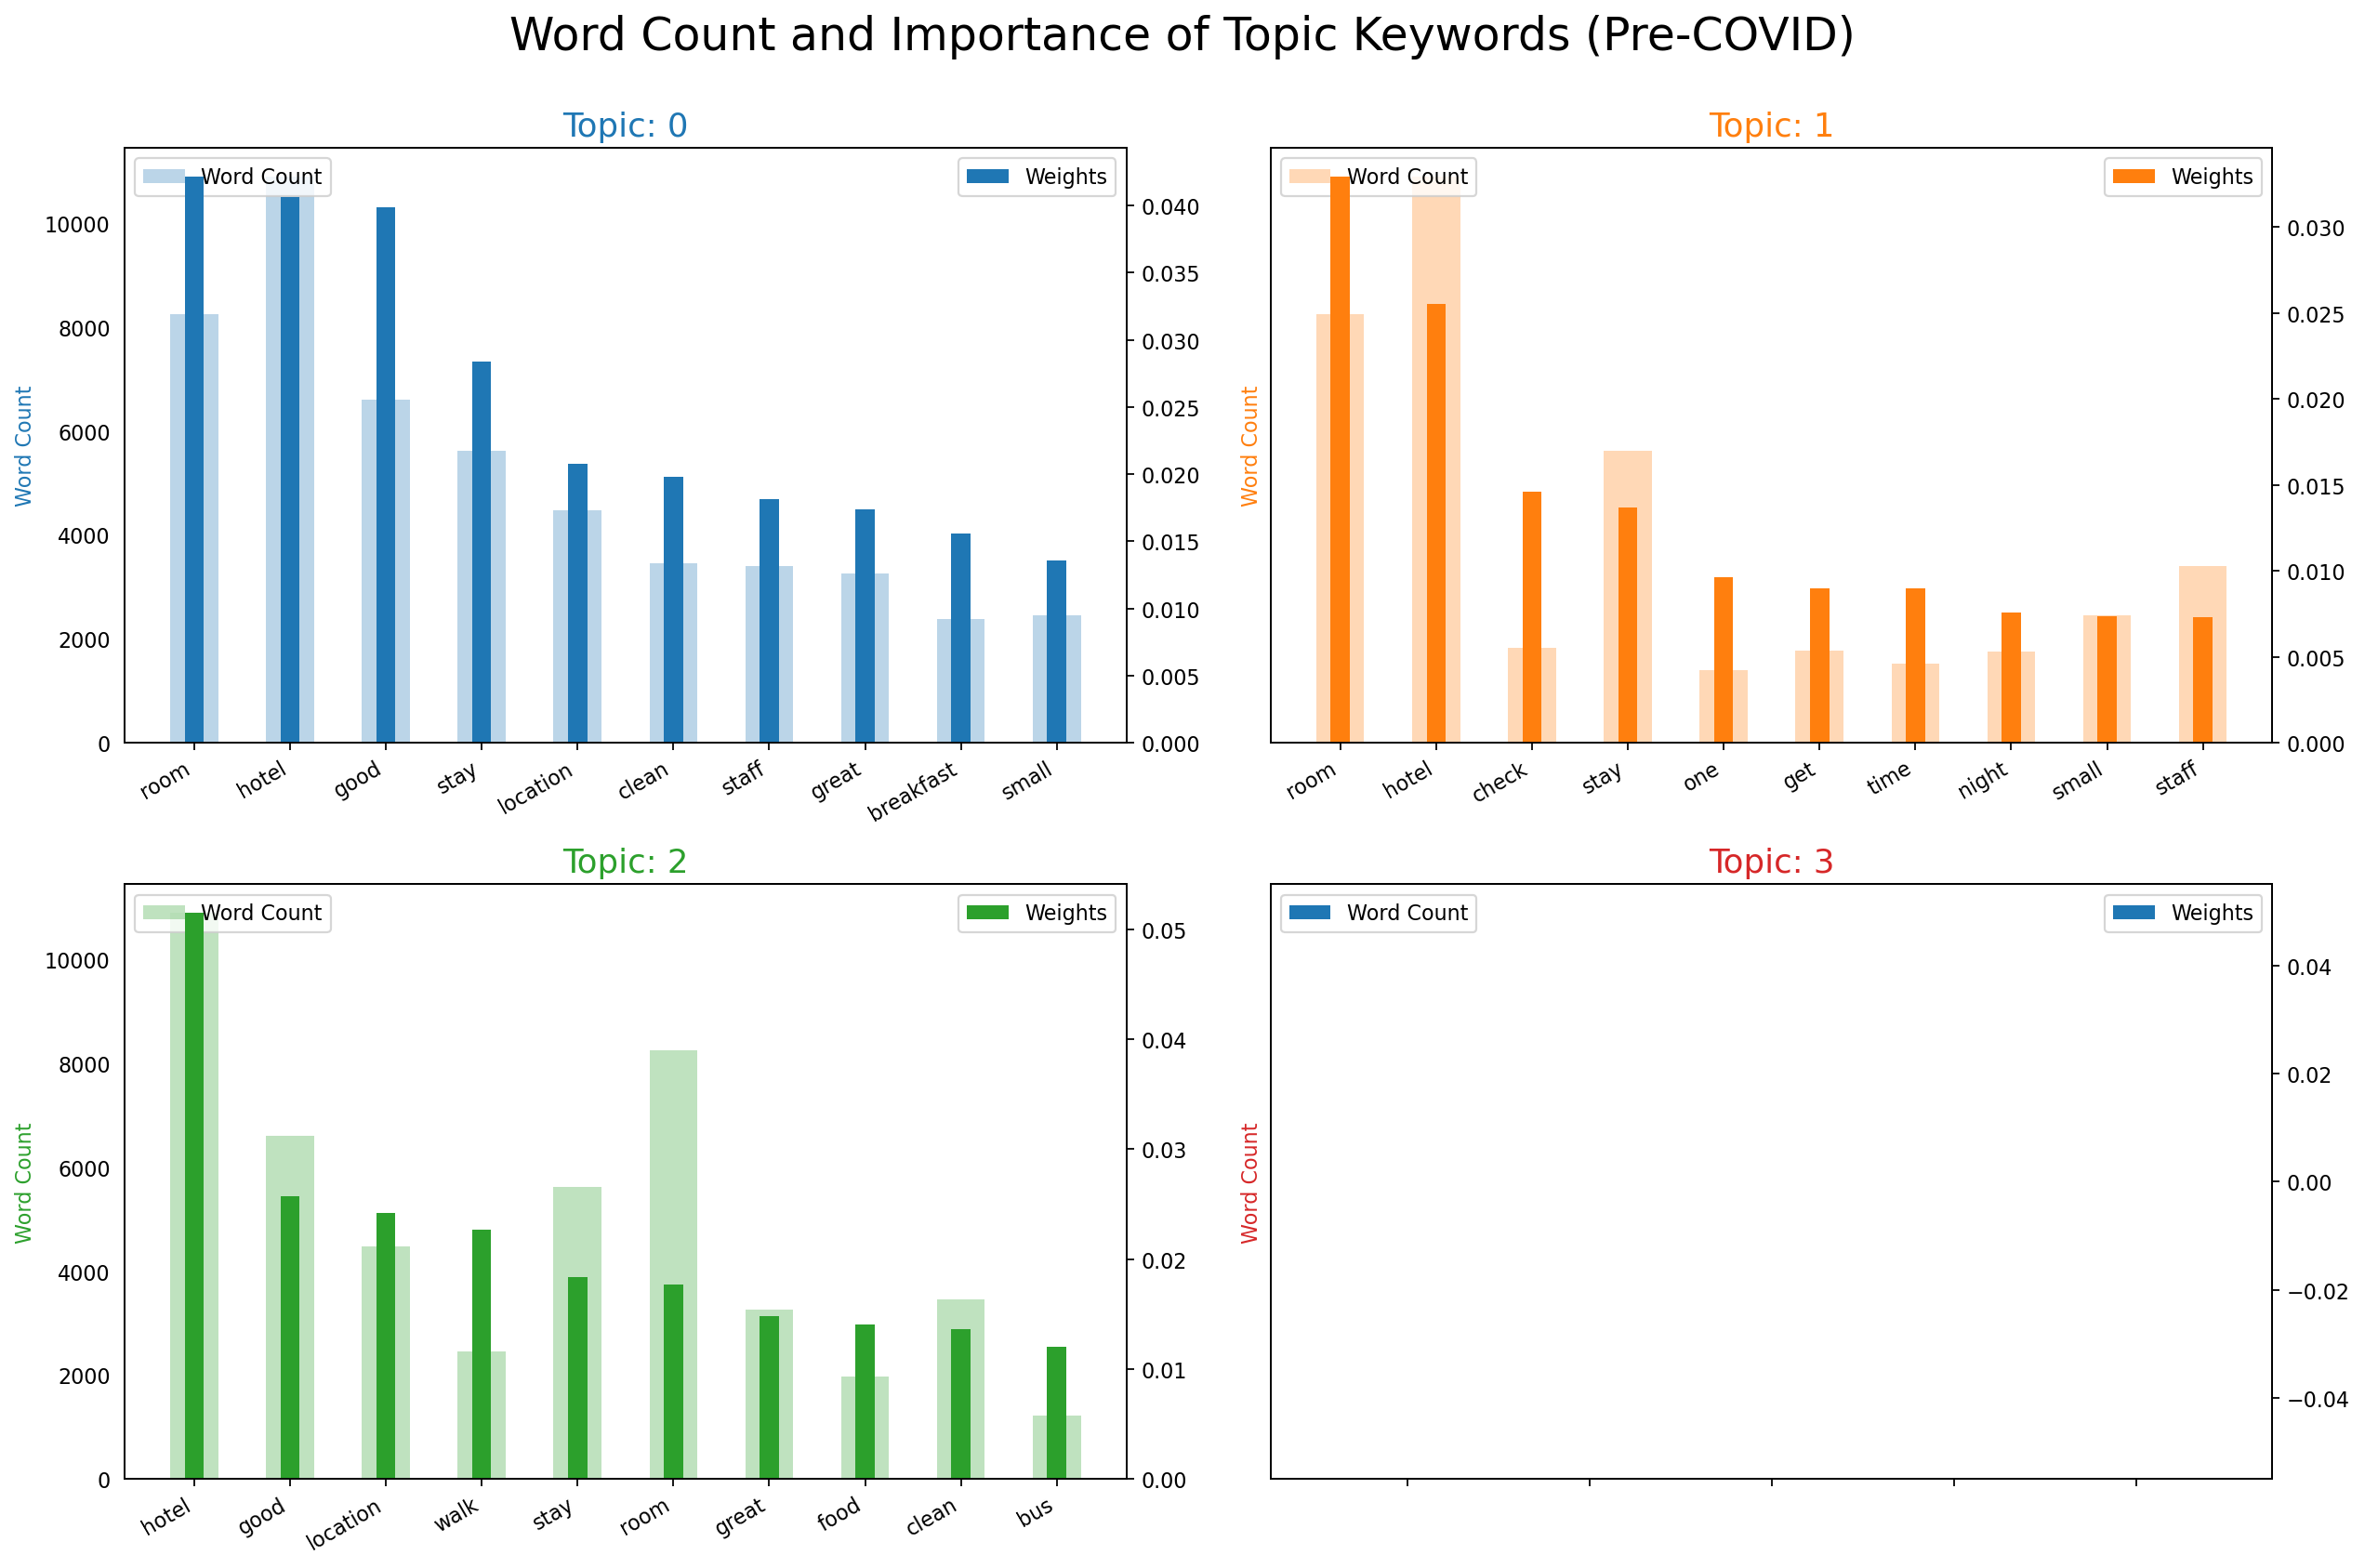

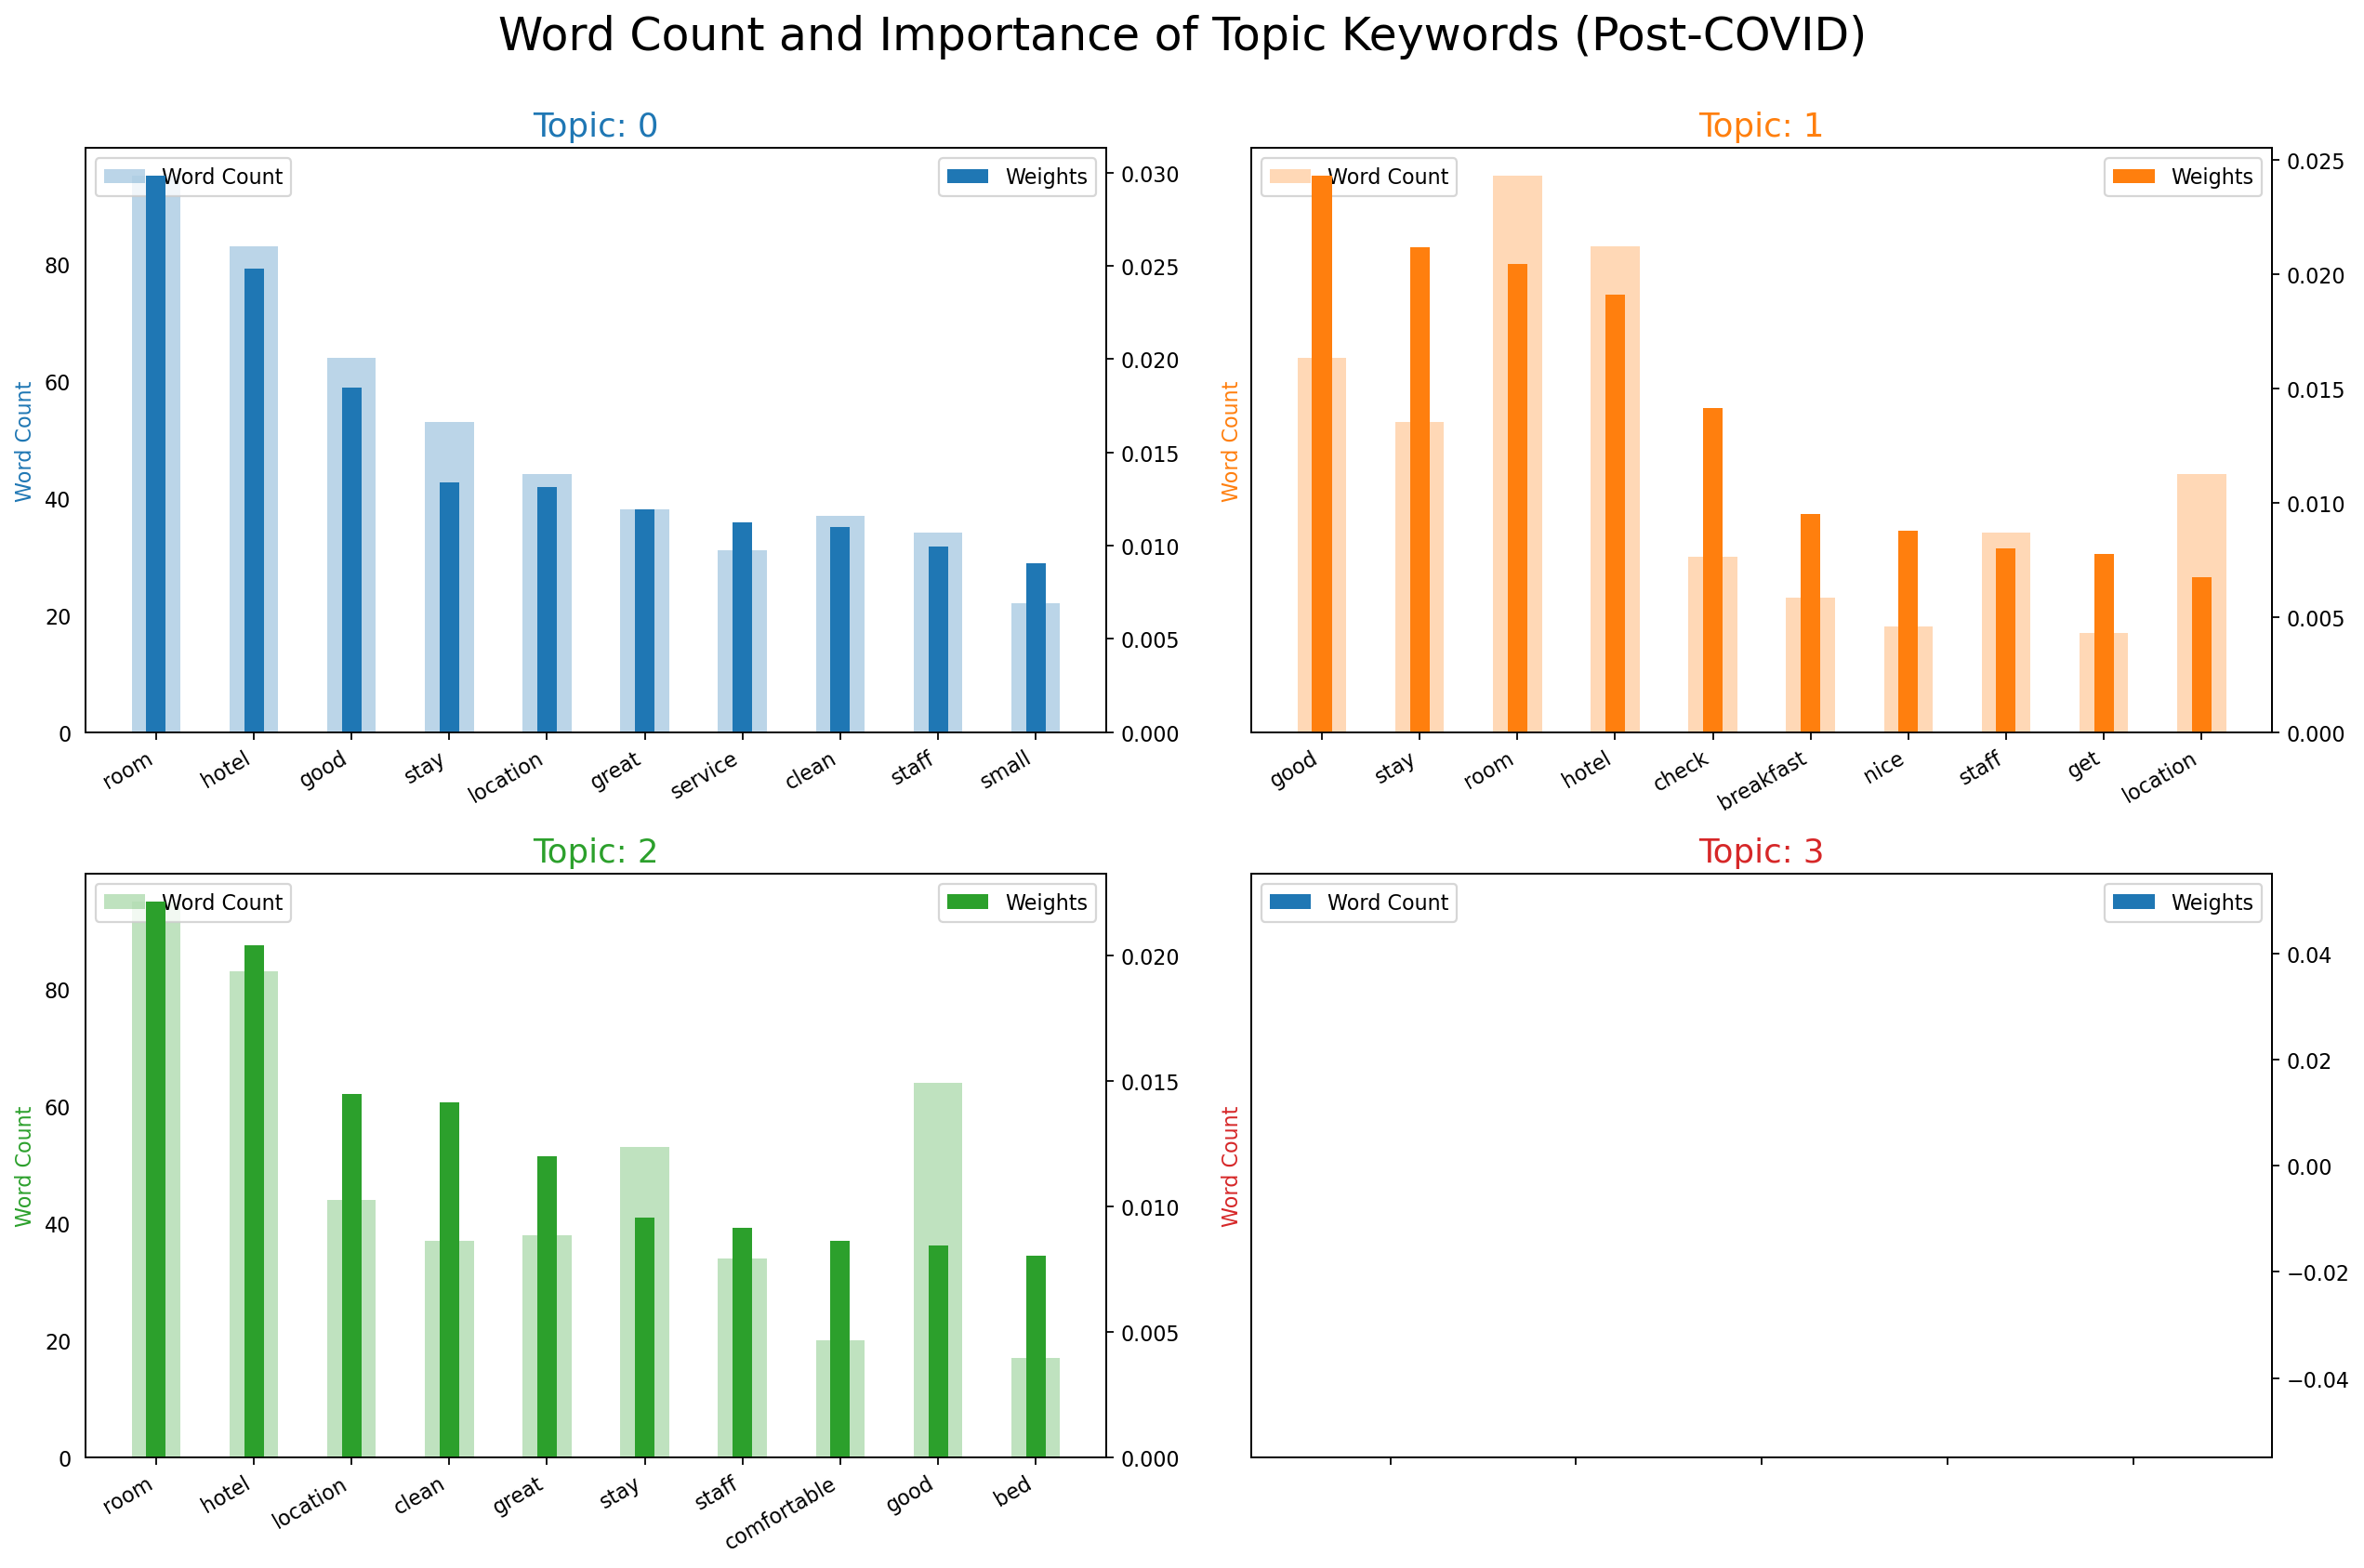

In [19]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')

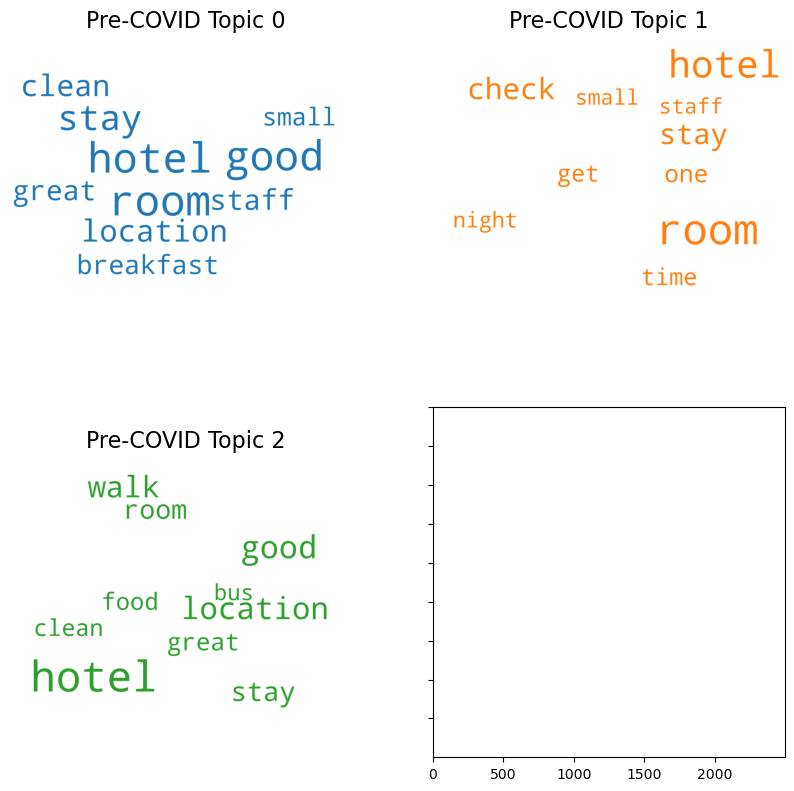

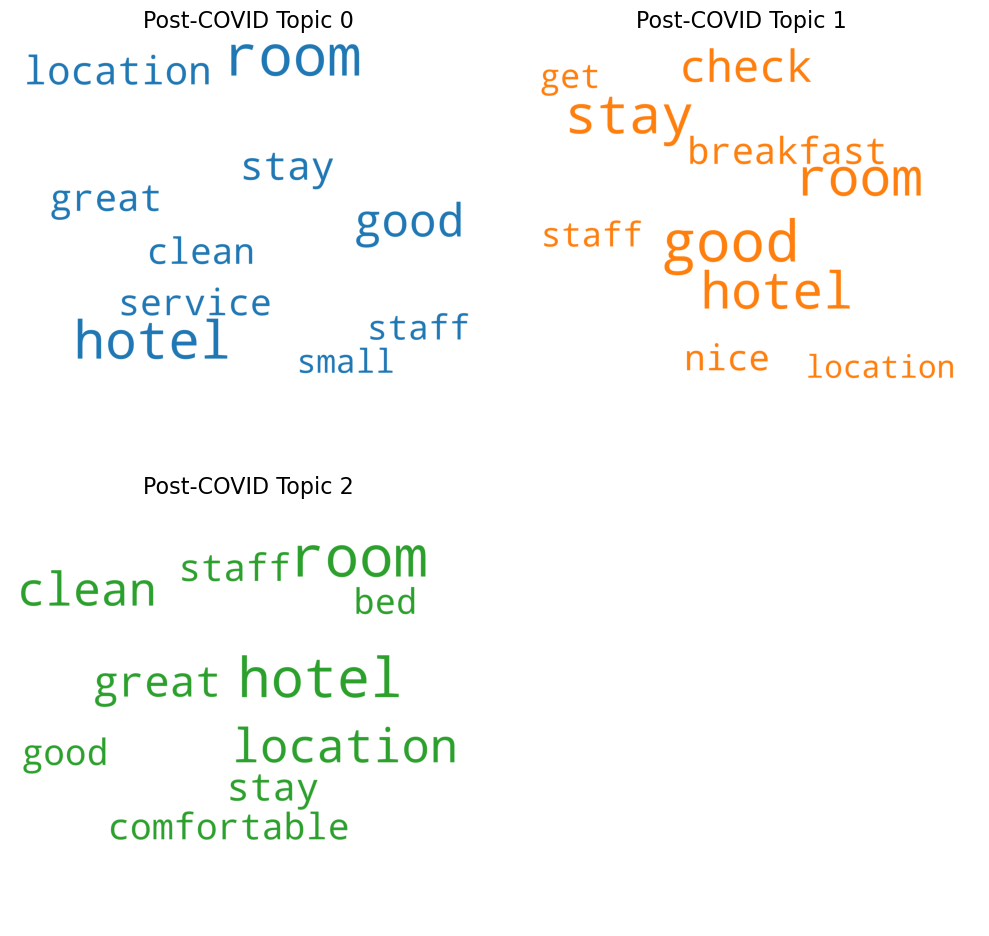

In [20]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(3):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(3):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# 4 Topics

In [21]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=4, id2word=pre_dict, passes=15)

In [22]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = pre_ldamodel.show_topics(num_topics=4, num_words=10)
topics_with_low_relevance = pre_ldamodel.show_topics(num_topics=4, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.050*"room" + 0.018*"hotel" + 0.013*"bed" + 0.012*"small" + 0.012*"check" + 0.009*"water" + 0.009*"floor" + 0.008*"one" + 0.008*"get" + 0.008*"stay"
Topic 1: 0.061*"hotel" + 0.046*"good" + 0.032*"room" + 0.031*"location" + 0.022*"stay" + 0.020*"clean" + 0.015*"food" + 0.014*"walk" + 0.014*"nice" + 0.013*"small"
Topic 2: 0.037*"hotel" + 0.032*"stay" + 0.027*"room" + 0.022*"staff" + 0.021*"good" + 0.017*"great" + 0.013*"breakfast" + 0.012*"clean" + 0.011*"location" + 0.010*"service"
Topic 3: 0.031*"walk" + 0.026*"hotel" + 0.016*"bus" + 0.015*"minute" + 0.014*"great" + 0.013*"location" + 0.011*"get" + 0.011*"station" + 0.010*"taxi" + 0.010*"airport"

Topics with low relevance:
Topic 0: 0.050*"room" + 0.018*"hotel" + 0.013*"bed" + 0.012*"small" + 0.012*"check"
Topic 1: 0.061*"hotel" + 0.046*"good" + 0.032*"room" + 0.031*"location" + 0.022*"stay"
Topic 2: 0.037*"hotel" + 0.032*"stay" + 0.027*"room" + 0.022*"staff" + 0.021*"good"
Topic 3: 0.031*"walk" + 

In [23]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=4, id2word=post_dict, passes=15)

In [24]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in df_precovid['tokens'] for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in df_postcovid['tokens'] for word in word_list]

In [25]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = post_ldamodel.show_topics(num_topics=4, num_words=10)
topics_with_low_relevance = post_ldamodel.show_topics(num_topics=4, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.023*"hotel" + 0.019*"room" + 0.016*"good" + 0.016*"stay" + 0.014*"nice" + 0.010*"clean" + 0.010*"staff" + 0.009*"check" + 0.008*"time" + 0.008*"extra"
Topic 1: 0.026*"room" + 0.015*"good" + 0.013*"service" + 0.012*"clean" + 0.009*"check" + 0.009*"cancel" + 0.008*"always" + 0.008*"get" + 0.008*"stay" + 0.008*"week"
Topic 2: 0.034*"hotel" + 0.027*"room" + 0.023*"good" + 0.017*"stay" + 0.017*"location" + 0.012*"clean" + 0.012*"great" + 0.011*"service" + 0.011*"staff" + 0.009*"check"
Topic 3: 0.027*"room" + 0.015*"great" + 0.012*"small" + 0.012*"stay" + 0.011*"breakfast" + 0.011*"hotel" + 0.010*"also" + 0.010*"location" + 0.008*"well" + 0.008*"staff"

Topics with low relevance:
Topic 0: 0.023*"hotel" + 0.019*"room" + 0.016*"good" + 0.016*"stay" + 0.014*"nice"
Topic 1: 0.026*"room" + 0.015*"good" + 0.013*"service" + 0.012*"clean" + 0.009*"check"
Topic 2: 0.034*"hotel" + 0.027*"room" + 0.023*"good" + 0.017*"stay" + 0.017*"location"
Topic 3: 0.027*"room"

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\874529396.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


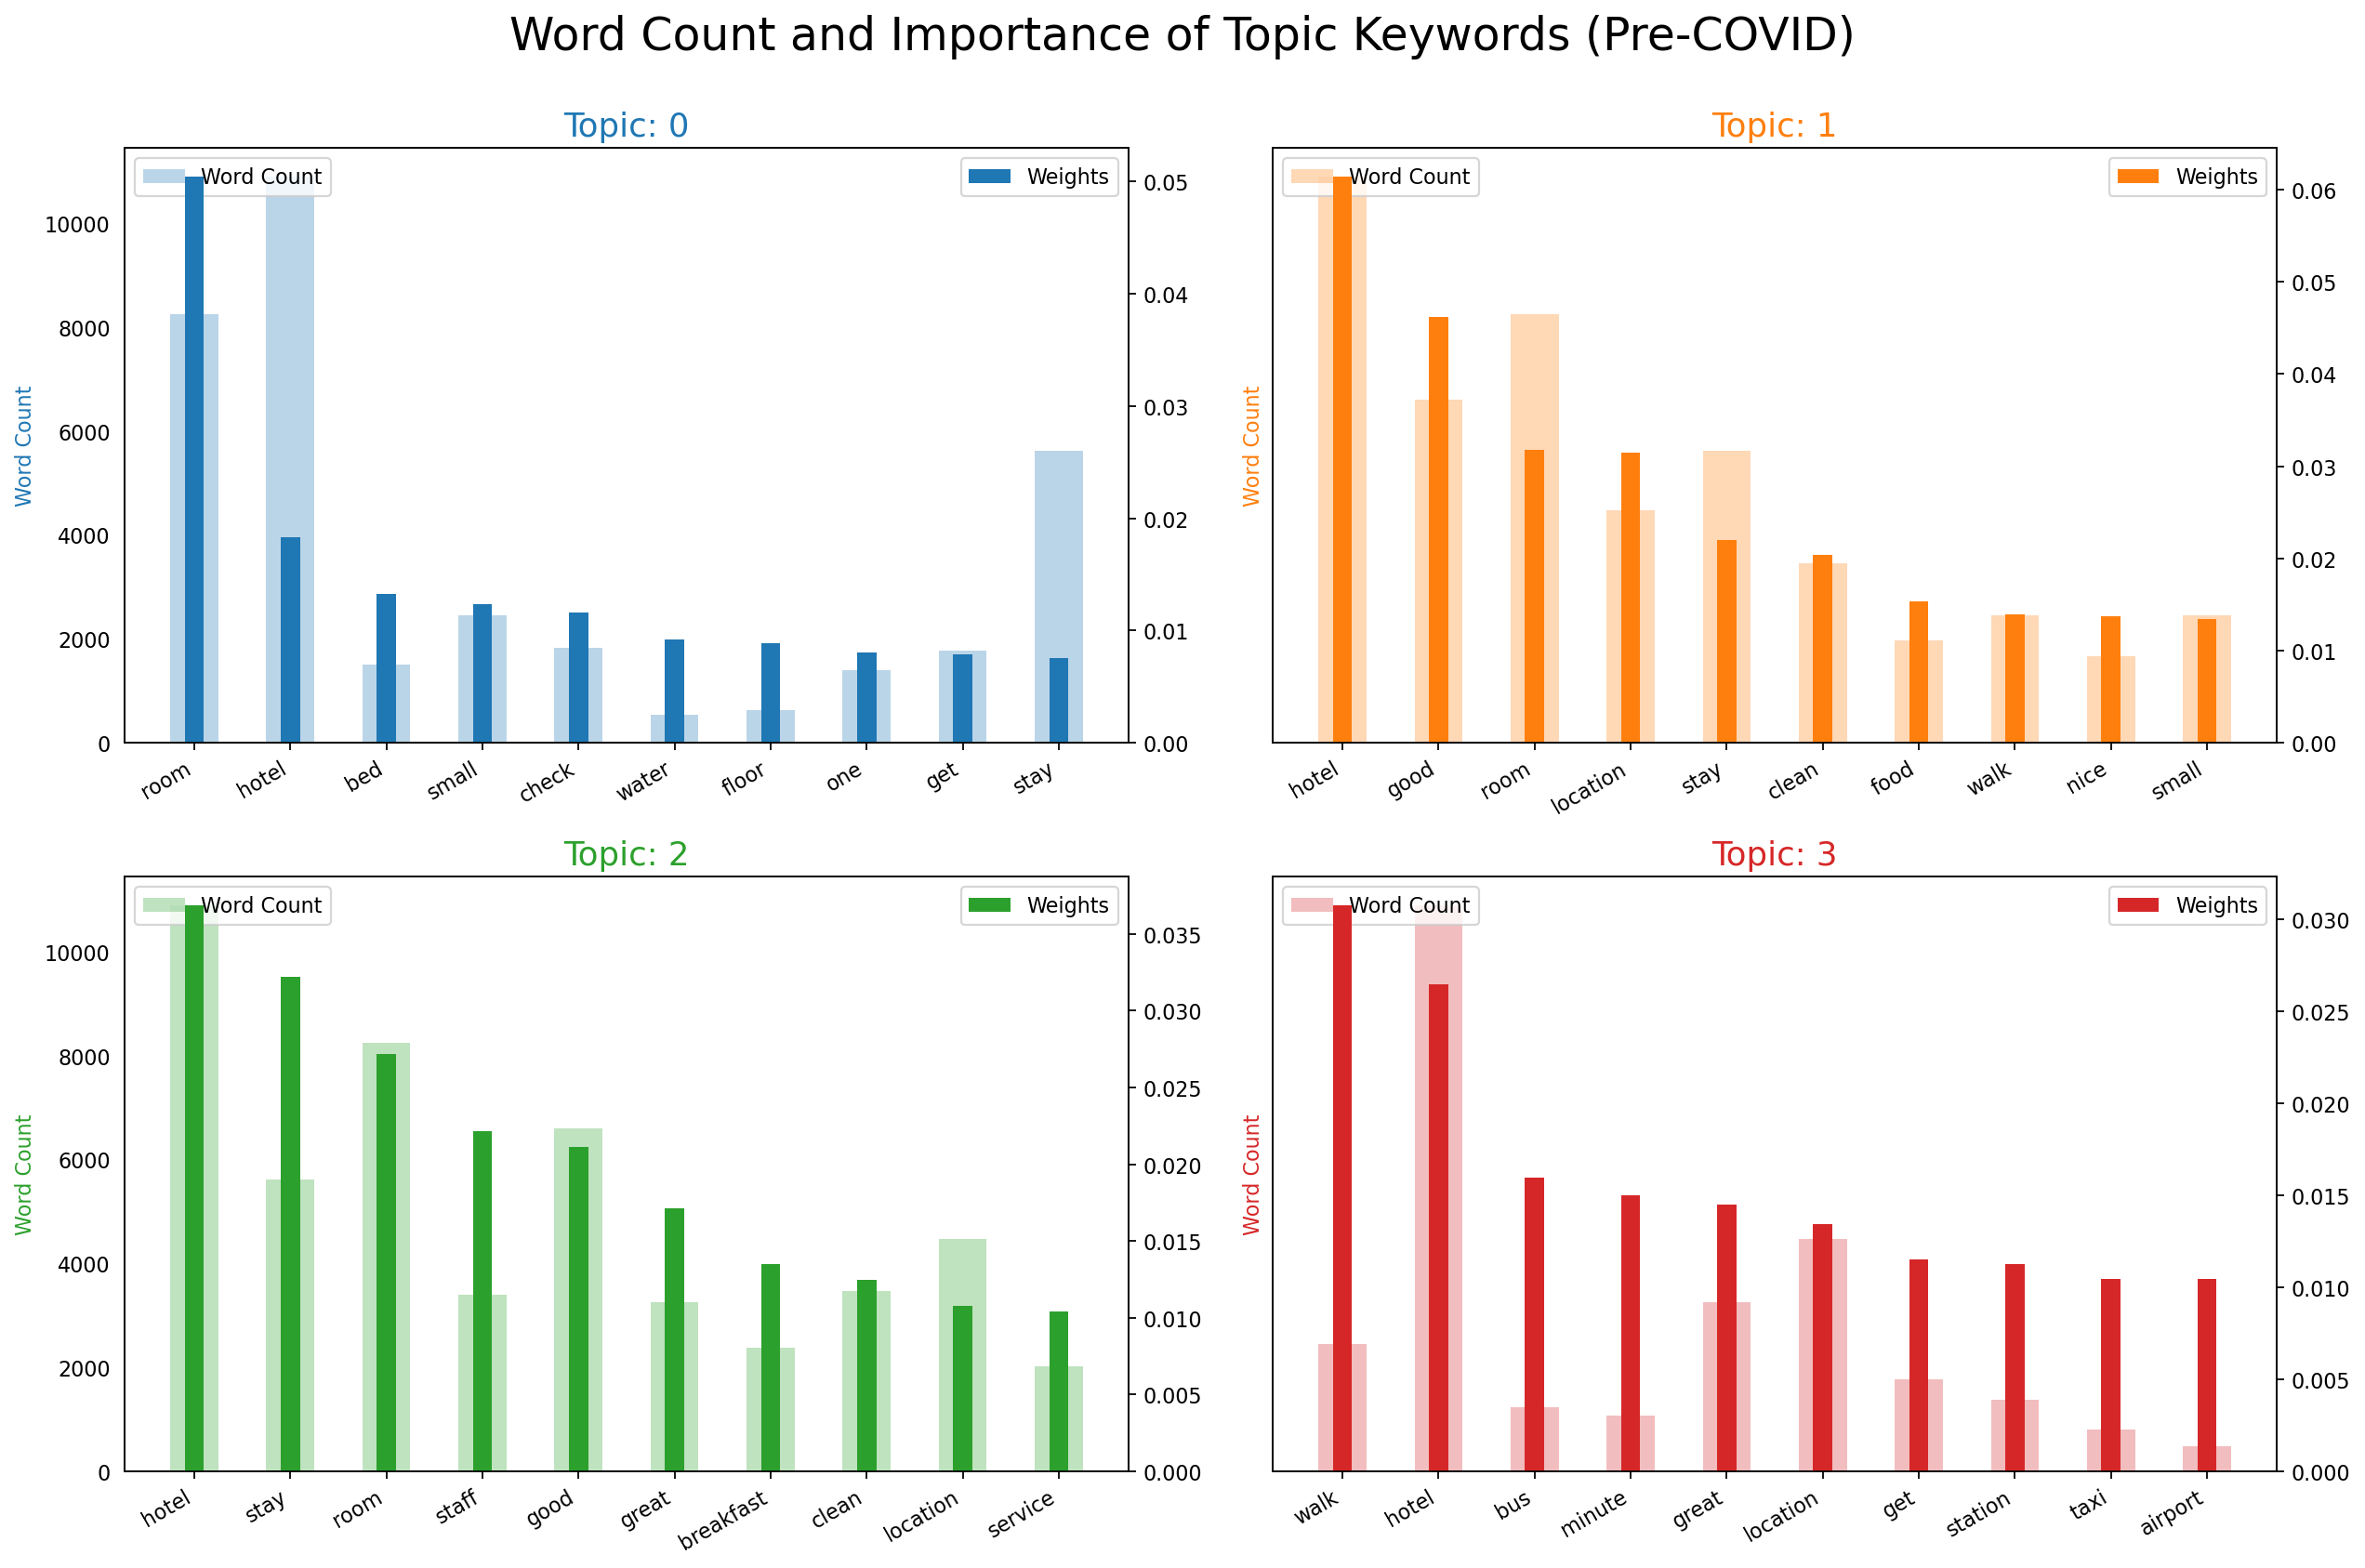

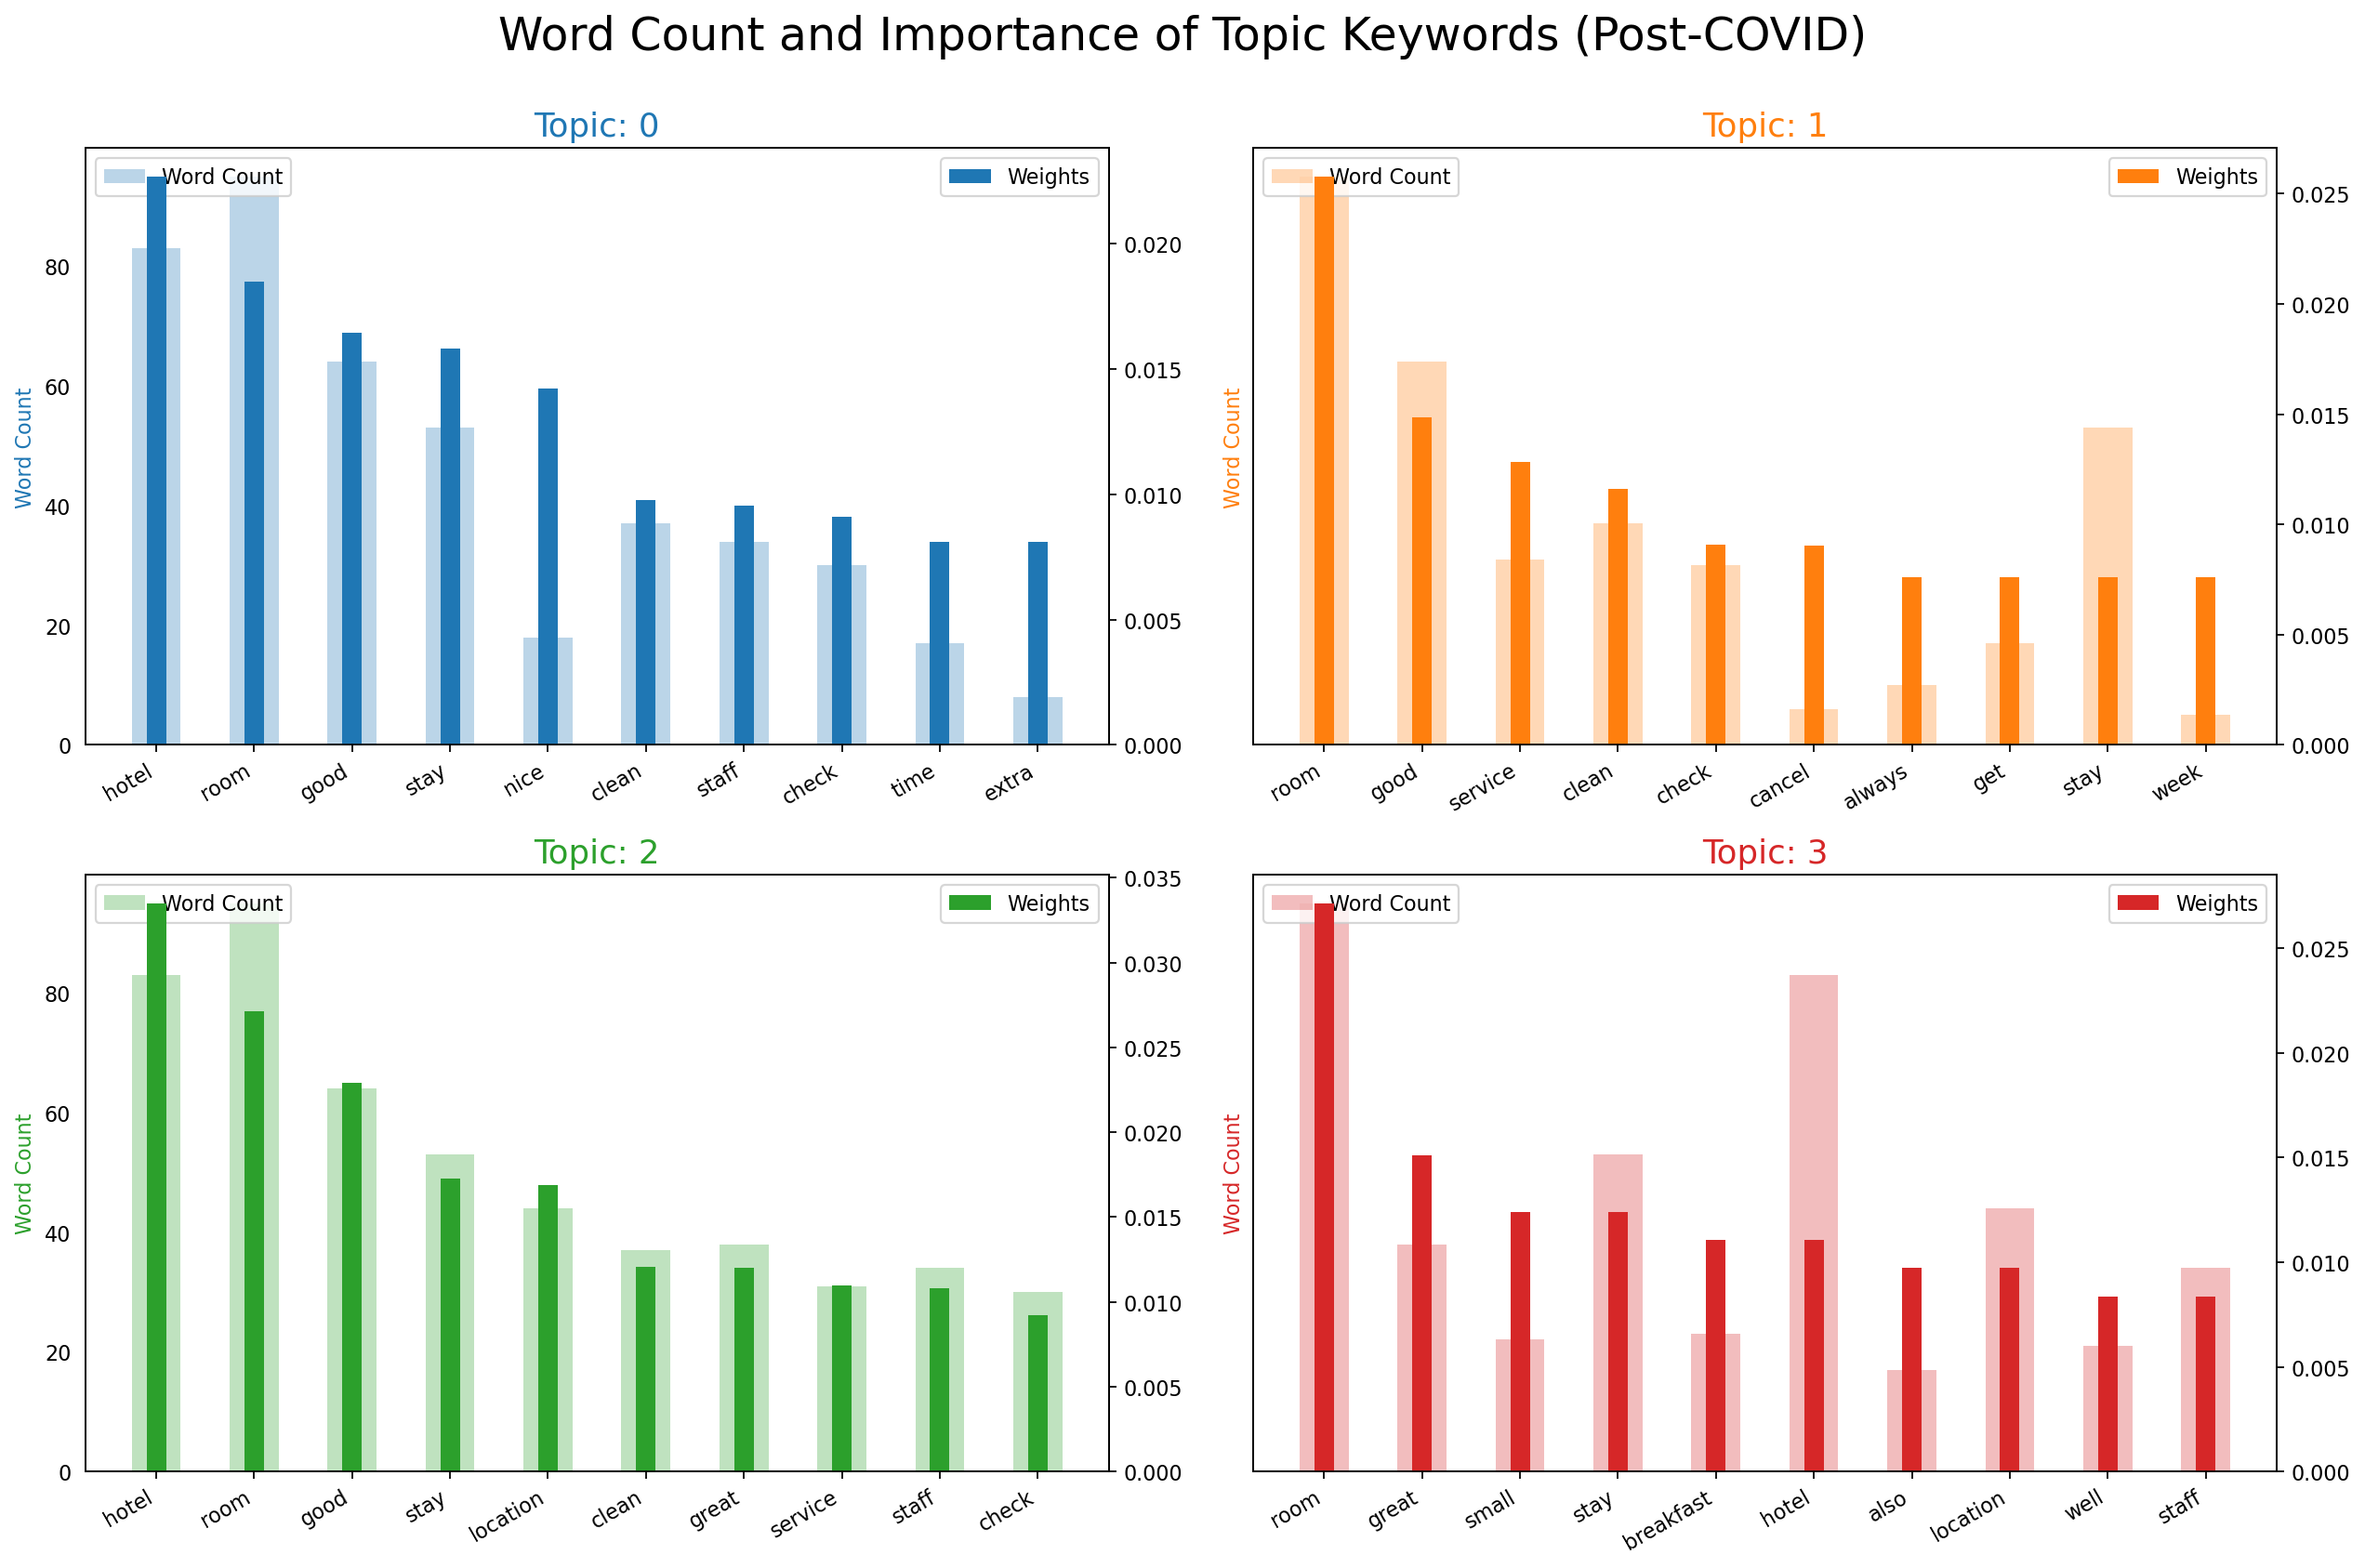

In [26]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')

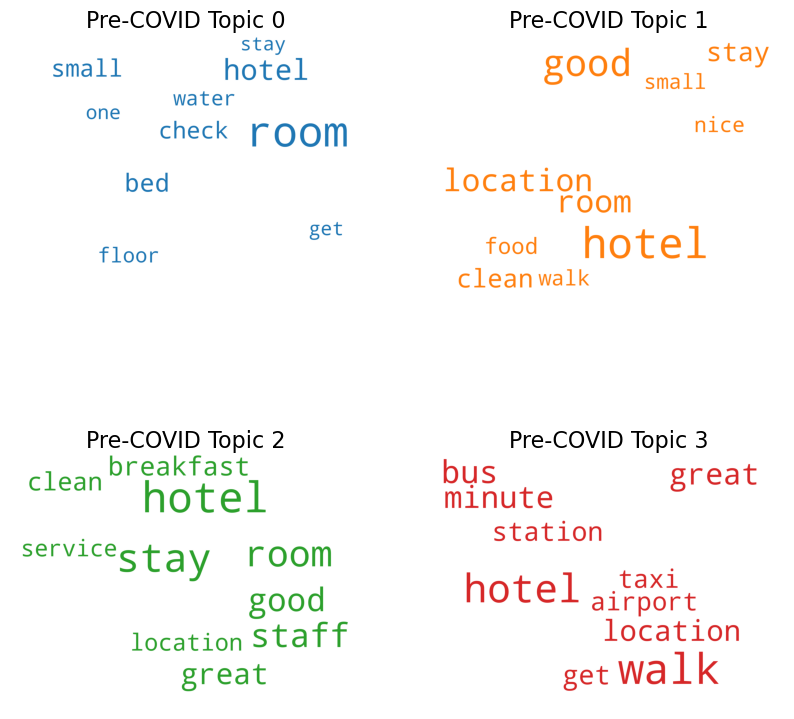

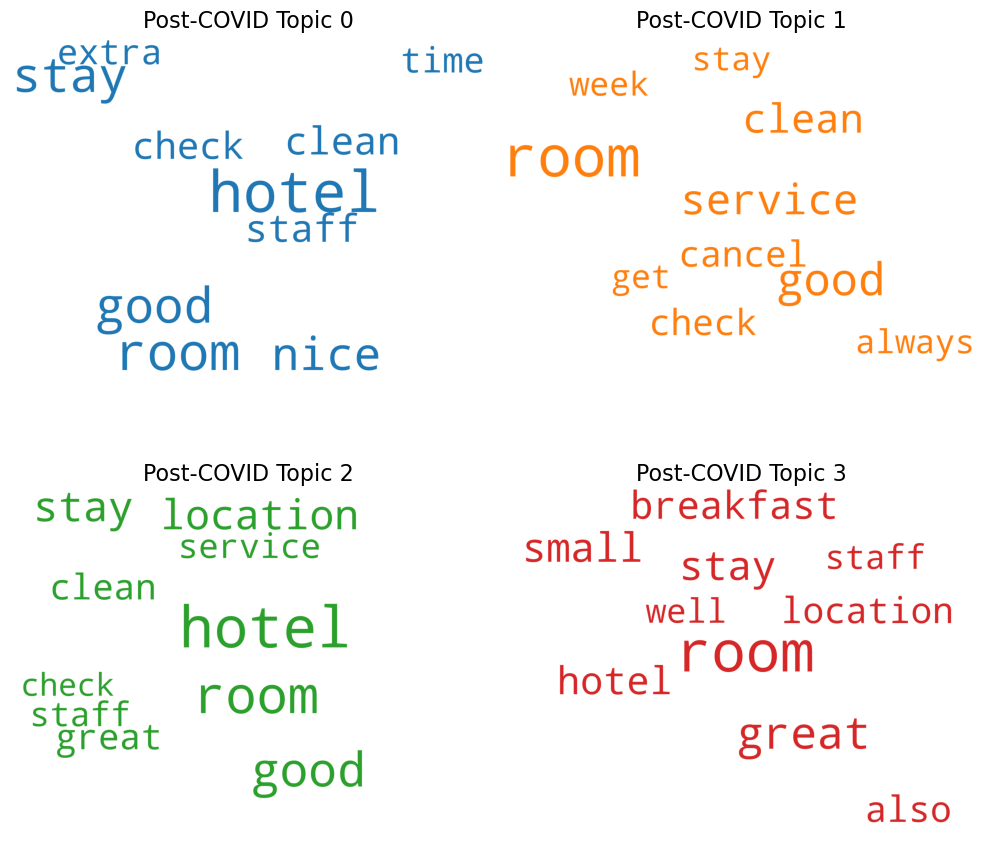

In [27]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(4):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(4):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# 5 Topics

In [28]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [29]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = pre_ldamodel.show_topics(num_topics=5, num_words=10)
topics_with_low_relevance = pre_ldamodel.show_topics(num_topics=5, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.036*"room" + 0.026*"hotel" + 0.019*"good" + 0.019*"small" + 0.013*"stay" + 0.013*"get" + 0.012*"night" + 0.011*"clean" + 0.011*"price" + 0.010*"breakfast"
Topic 1: 0.045*"room" + 0.022*"hotel" + 0.013*"check" + 0.011*"bed" + 0.010*"water" + 0.010*"small" + 0.009*"stay" + 0.008*"free" + 0.008*"use" + 0.008*"shower"
Topic 2: 0.038*"stay" + 0.033*"hotel" + 0.030*"staff" + 0.029*"room" + 0.021*"great" + 0.019*"good" + 0.015*"check" + 0.014*"service" + 0.012*"clean" + 0.012*"time"
Topic 3: 0.046*"hotel" + 0.032*"walk" + 0.027*"location" + 0.021*"great" + 0.019*"bus" + 0.017*"stay" + 0.017*"station" + 0.017*"good" + 0.016*"room" + 0.015*"clean"
Topic 4: 0.065*"hotel" + 0.054*"good" + 0.030*"room" + 0.026*"location" + 0.020*"stay" + 0.019*"clean" + 0.016*"breakfast" + 0.014*"nice" + 0.014*"food" + 0.013*"price"

Topics with low relevance:
Topic 0: 0.036*"room" + 0.026*"hotel" + 0.019*"good" + 0.019*"small" + 0.013*"stay"
Topic 1: 0.045*"room" + 0.022*"ho

In [30]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=5, id2word=post_dict, passes=15)

In [31]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in df_precovid['tokens'] for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in df_postcovid['tokens'] for word in word_list]

In [32]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = post_ldamodel.show_topics(num_topics=5, num_words=10)
topics_with_low_relevance = post_ldamodel.show_topics(num_topics=5, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.015*"room" + 0.013*"issue" + 0.010*"walk" + 0.010*"improve" + 0.010*"distance" + 0.008*"great" + 0.008*"time" + 0.008*"minute" + 0.008*"manager" + 0.007*"within"
Topic 1: 0.031*"hotel" + 0.024*"room" + 0.018*"clean" + 0.014*"check" + 0.010*"good" + 0.010*"stay" + 0.009*"restaurant" + 0.009*"great" + 0.009*"service" + 0.008*"location"
Topic 2: 0.028*"good" + 0.019*"room" + 0.018*"hotel" + 0.016*"stay" + 0.015*"check" + 0.015*"nice" + 0.013*"breakfast" + 0.012*"staff" + 0.010*"service" + 0.010*"location"
Topic 3: 0.038*"room" + 0.026*"hotel" + 0.022*"good" + 0.020*"stay" + 0.020*"location" + 0.015*"great" + 0.012*"clean" + 0.011*"small" + 0.011*"staff" + 0.010*"service"
Topic 4: 0.018*"team" + 0.018*"engineering" + 0.017*"hotel" + 0.014*"staff" + 0.011*"cleaning" + 0.011*"handle" + 0.010*"say" + 0.008*"get" + 0.008*"luggage" + 0.008*"wonderful"

Topics with low relevance:
Topic 0: 0.015*"room" + 0.013*"issue" + 0.010*"walk" + 0.010*"improve" + 0.010

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\2307337869.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


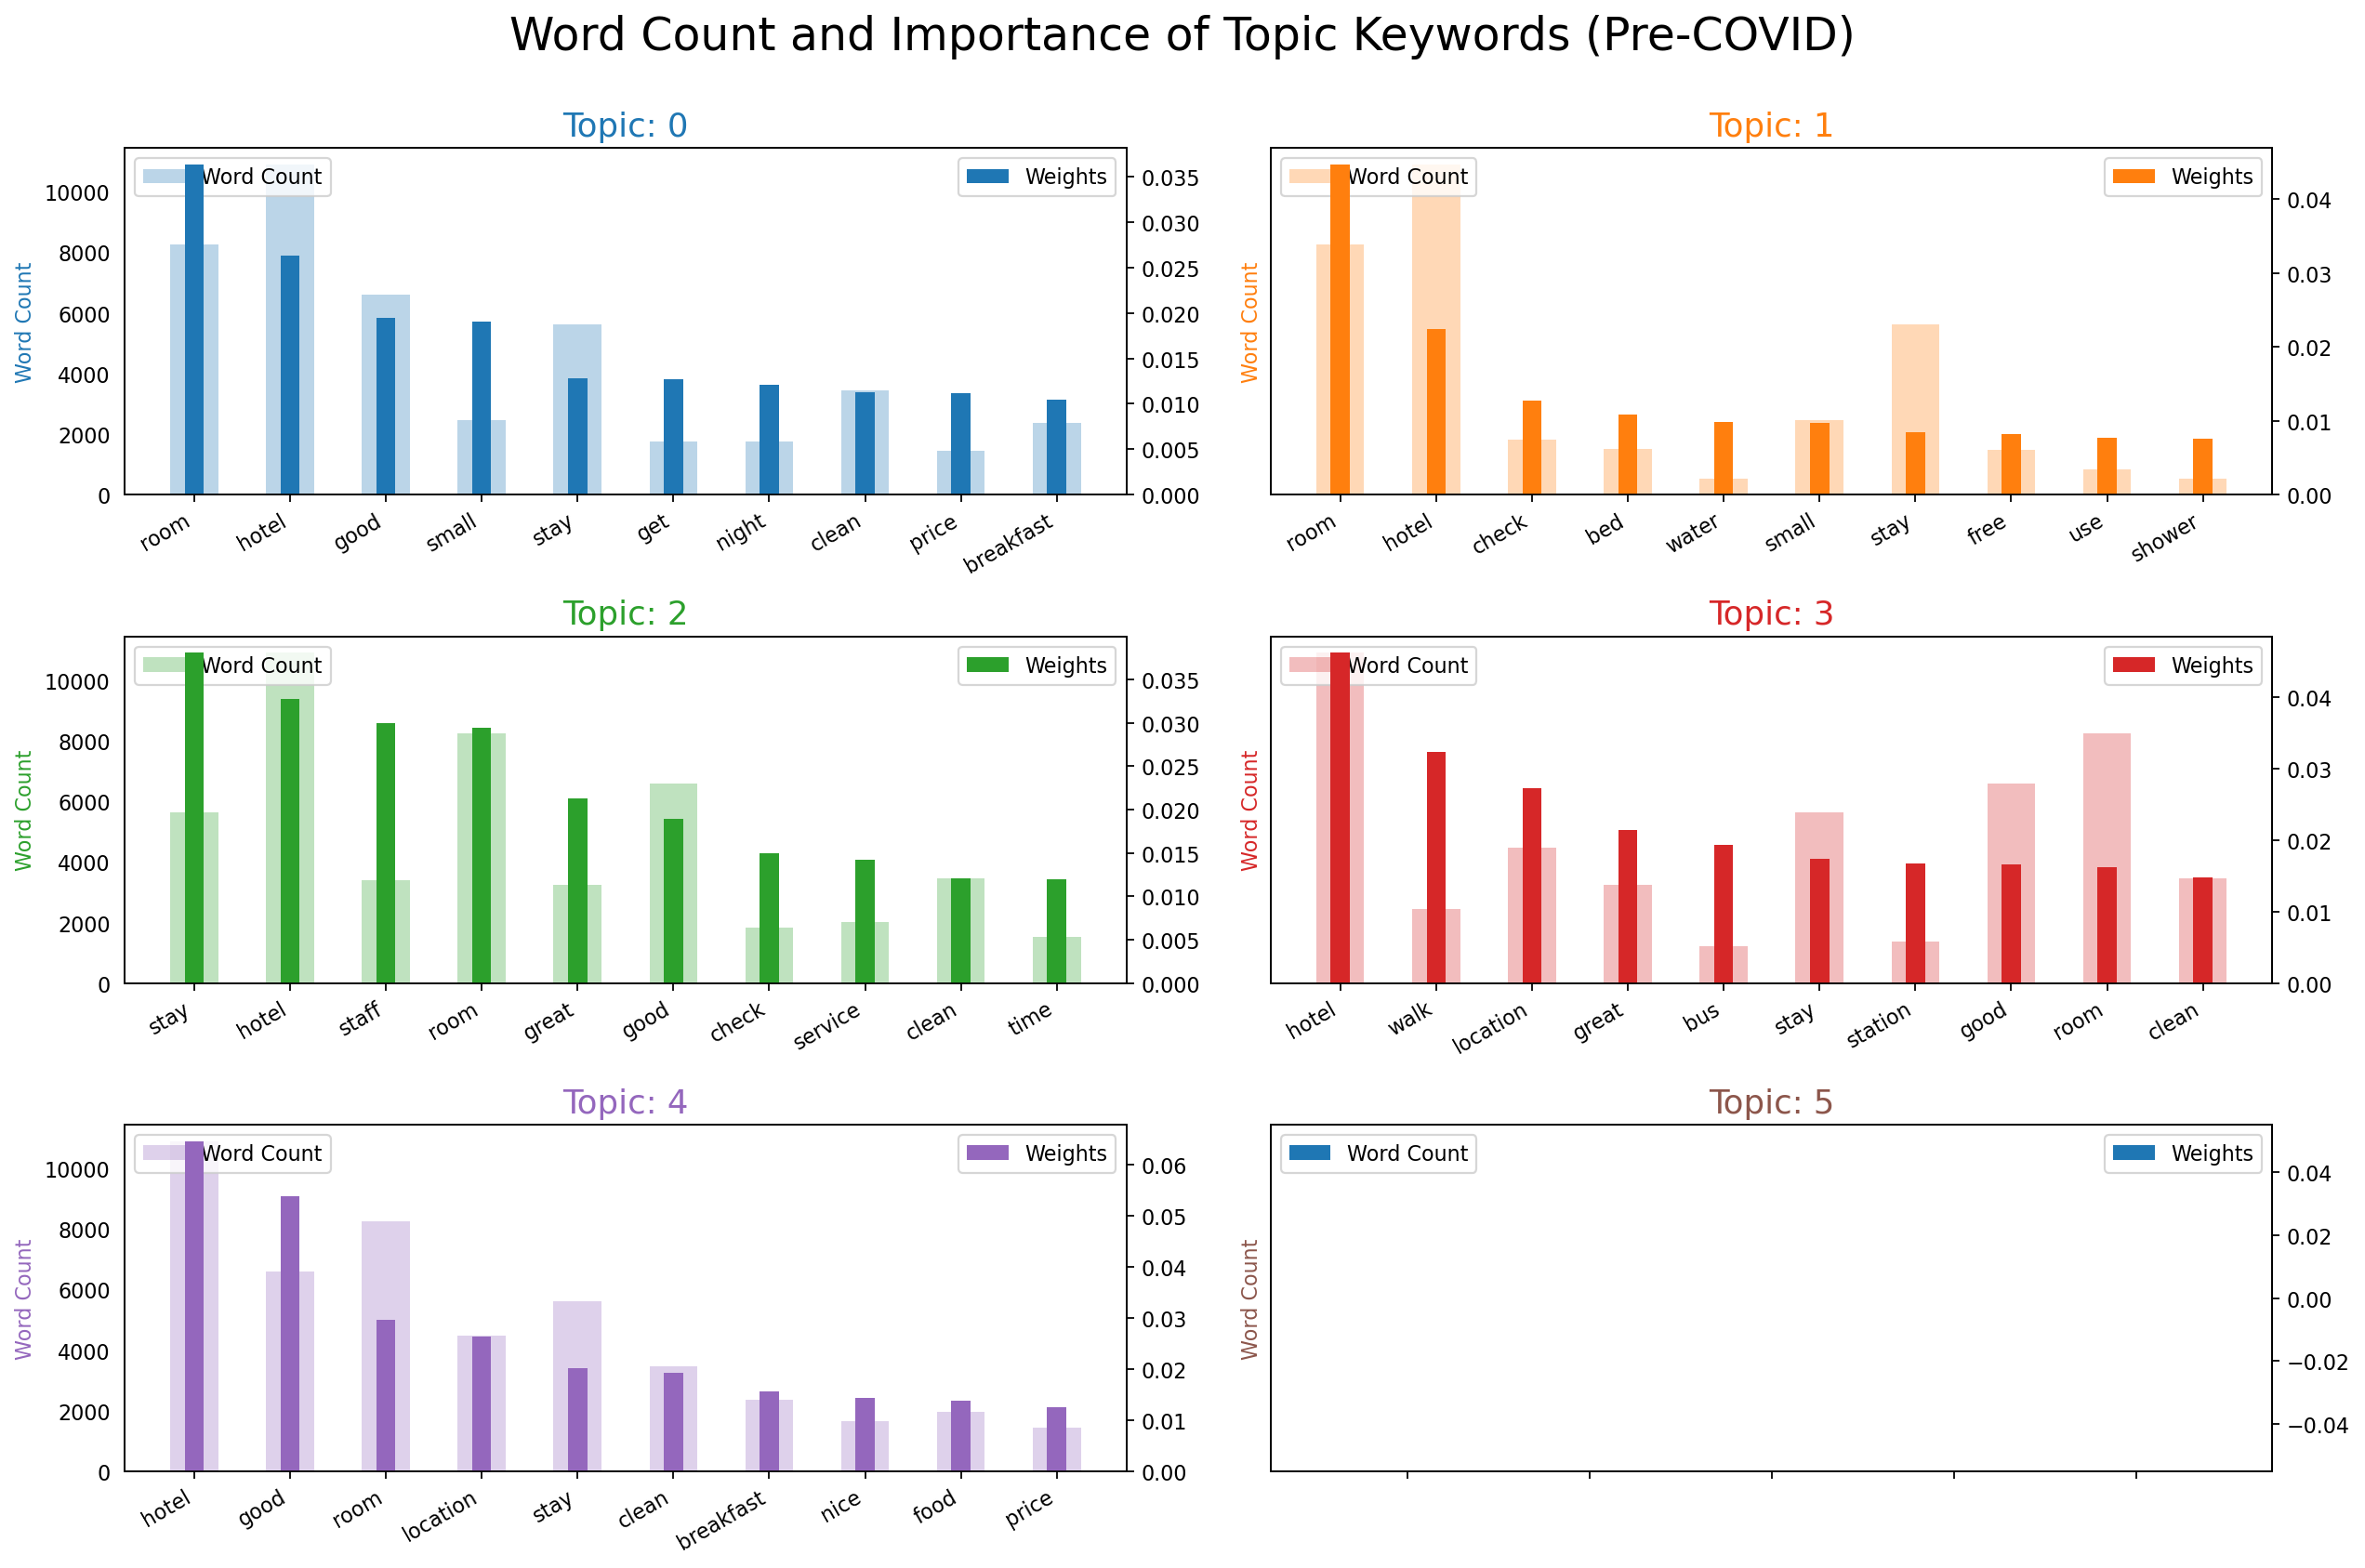

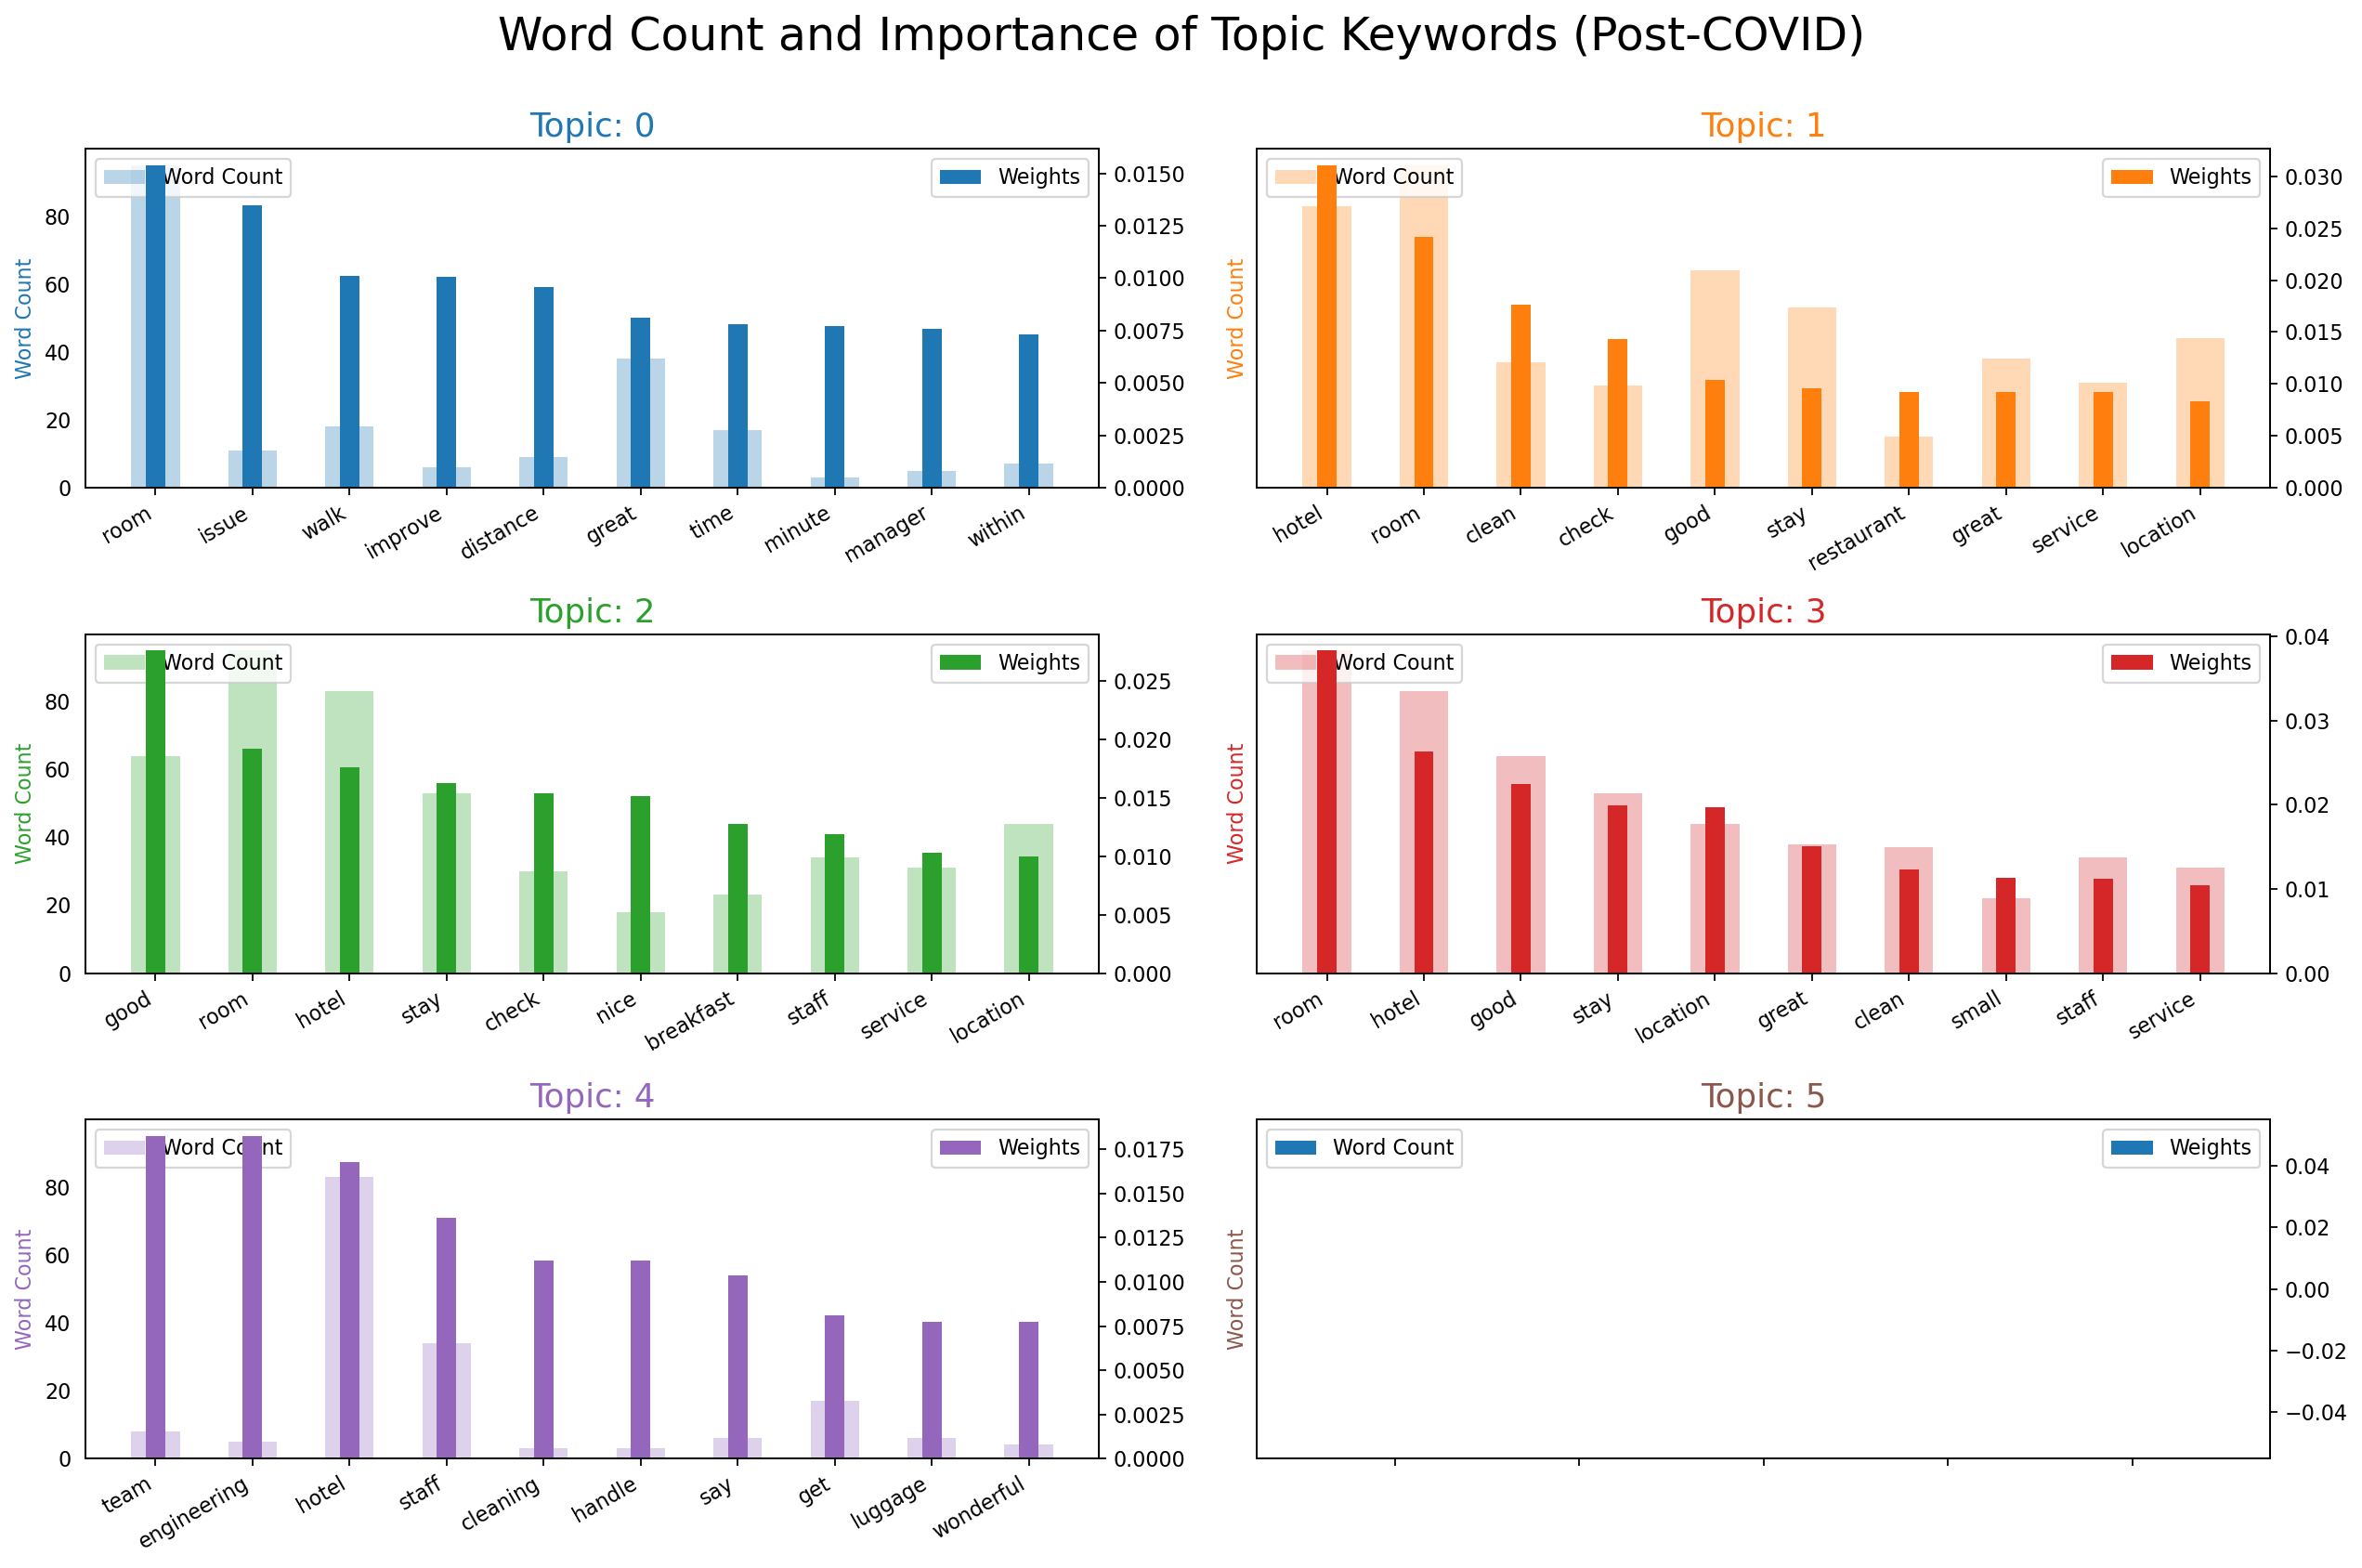

In [33]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')

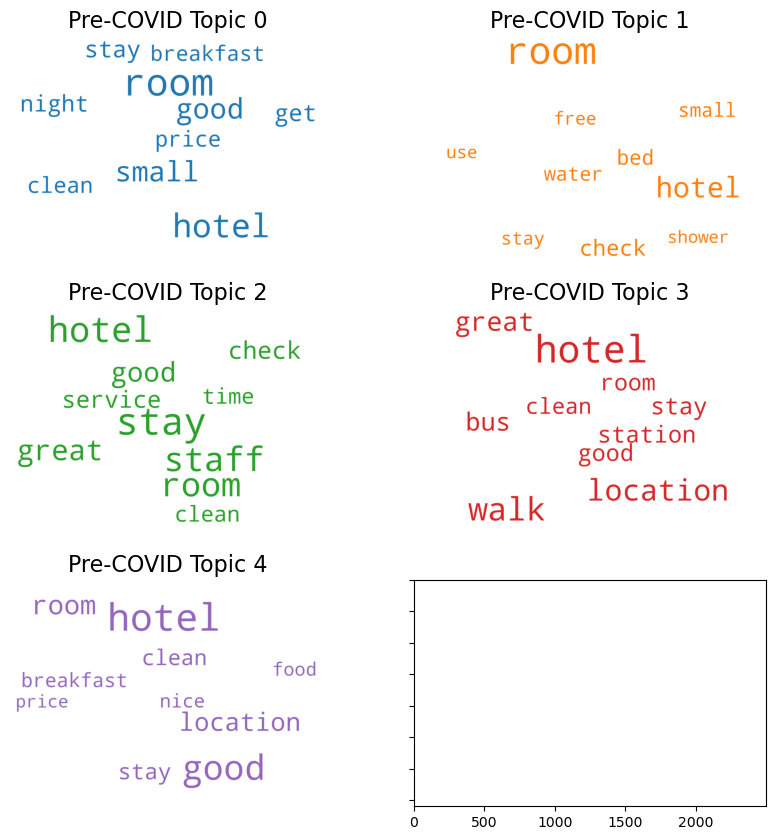

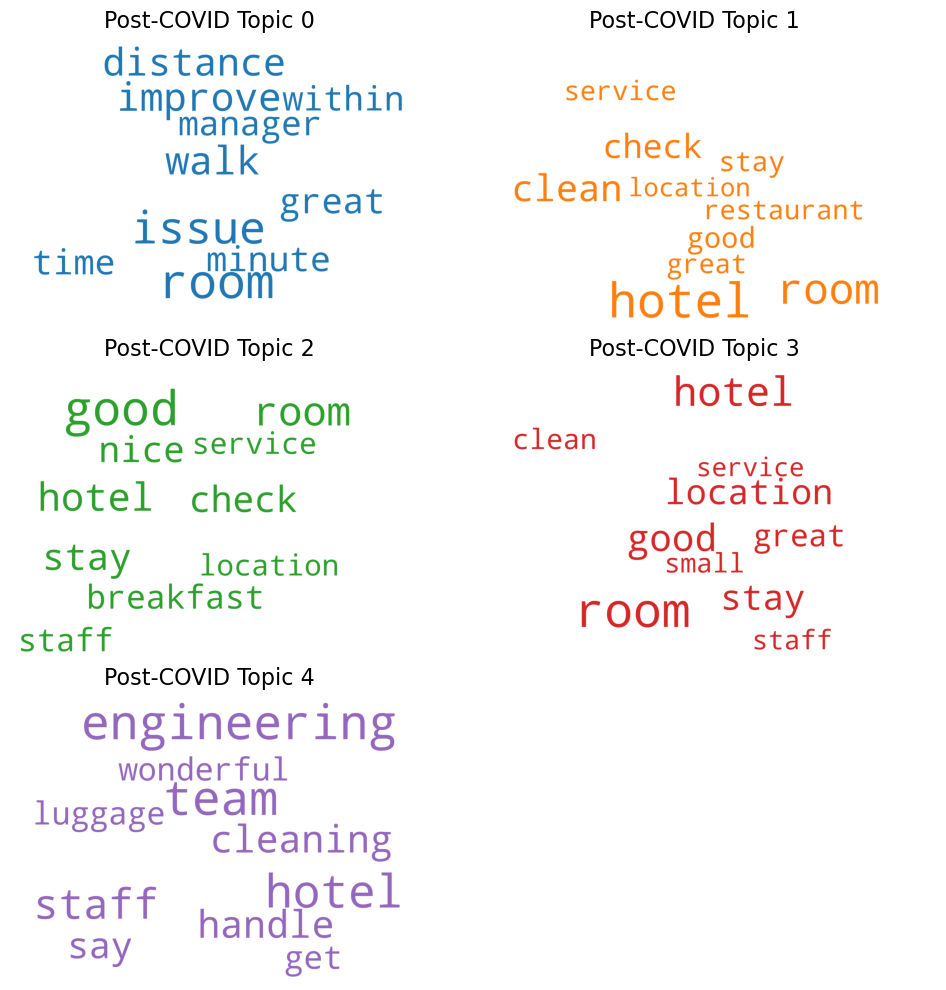

In [34]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# 6 Topics

In [35]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=6, id2word=pre_dict, passes=15)

In [36]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = pre_ldamodel.show_topics(num_topics=6, num_words=10)
topics_with_low_relevance = pre_ldamodel.show_topics(num_topics=6, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.062*"hotel" + 0.027*"location" + 0.026*"walk" + 0.024*"good" + 0.022*"food" + 0.018*"bus" + 0.018*"near" + 0.017*"station" + 0.015*"street" + 0.014*"stay"
Topic 1: 0.037*"hotel" + 0.024*"stay" + 0.019*"room" + 0.019*"check" + 0.018*"staff" + 0.016*"service" + 0.014*"good" + 0.014*"time" + 0.009*"one" + 0.009*"get"
Topic 2: 0.057*"room" + 0.019*"bed" + 0.017*"hotel" + 0.015*"small" + 0.014*"stay" + 0.011*"floor" + 0.010*"night" + 0.010*"clean" + 0.009*"bathroom" + 0.009*"water"
Topic 3: 0.053*"great" + 0.041*"staff" + 0.036*"stay" + 0.024*"friendly" + 0.024*"location" + 0.023*"helpful" + 0.019*"hotel" + 0.017*"breakfast" + 0.014*"clean" + 0.013*"would"
Topic 4: 0.054*"hotel" + 0.050*"good" + 0.041*"room" + 0.025*"location" + 0.024*"clean" + 0.023*"stay" + 0.017*"small" + 0.014*"breakfast" + 0.013*"value" + 0.012*"well"
Topic 5: 0.038*"free" + 0.026*"room" + 0.024*"use" + 0.018*"phone" + 0.016*"check" + 0.016*"call" + 0.012*"coffee" + 0.010*"extra" 

In [37]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=6, id2word=post_dict, passes=15)

In [38]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in df_precovid['tokens'] for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in df_postcovid['tokens'] for word in word_list]

In [39]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = post_ldamodel.show_topics(num_topics=6, num_words=10)
topics_with_low_relevance = post_ldamodel.show_topics(num_topics=6, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.023*"room" + 0.012*"great" + 0.011*"time" + 0.010*"need" + 0.010*"easy" + 0.010*"location" + 0.010*"service" + 0.010*"call" + 0.010*"issue" + 0.009*"stay"
Topic 1: 0.043*"hotel" + 0.031*"room" + 0.024*"good" + 0.021*"stay" + 0.012*"location" + 0.011*"clean" + 0.010*"staff" + 0.008*"well" + 0.008*"small" + 0.008*"breakfast"
Topic 2: 0.022*"good" + 0.021*"stay" + 0.020*"nice" + 0.020*"room" + 0.016*"great" + 0.013*"check" + 0.012*"staff" + 0.011*"day" + 0.011*"breakfast" + 0.010*"location"
Topic 3: 0.030*"check" + 0.012*"good" + 0.012*"place" + 0.012*"easy" + 0.012*"price" + 0.012*"customer" + 0.012*"queue" + 0.008*"room" + 0.008*"walk" + 0.008*"junction"
Topic 4: 0.023*"hotel" + 0.014*"room" + 0.014*"staff" + 0.014*"team" + 0.014*"location" + 0.012*"engineering" + 0.012*"great" + 0.009*"bed" + 0.009*"clean" + 0.009*"restaurant"
Topic 5: 0.033*"room" + 0.018*"hotel" + 0.016*"service" + 0.015*"location" + 0.015*"good" + 0.015*"clean" + 0.014*"great" 

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\2307337869.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


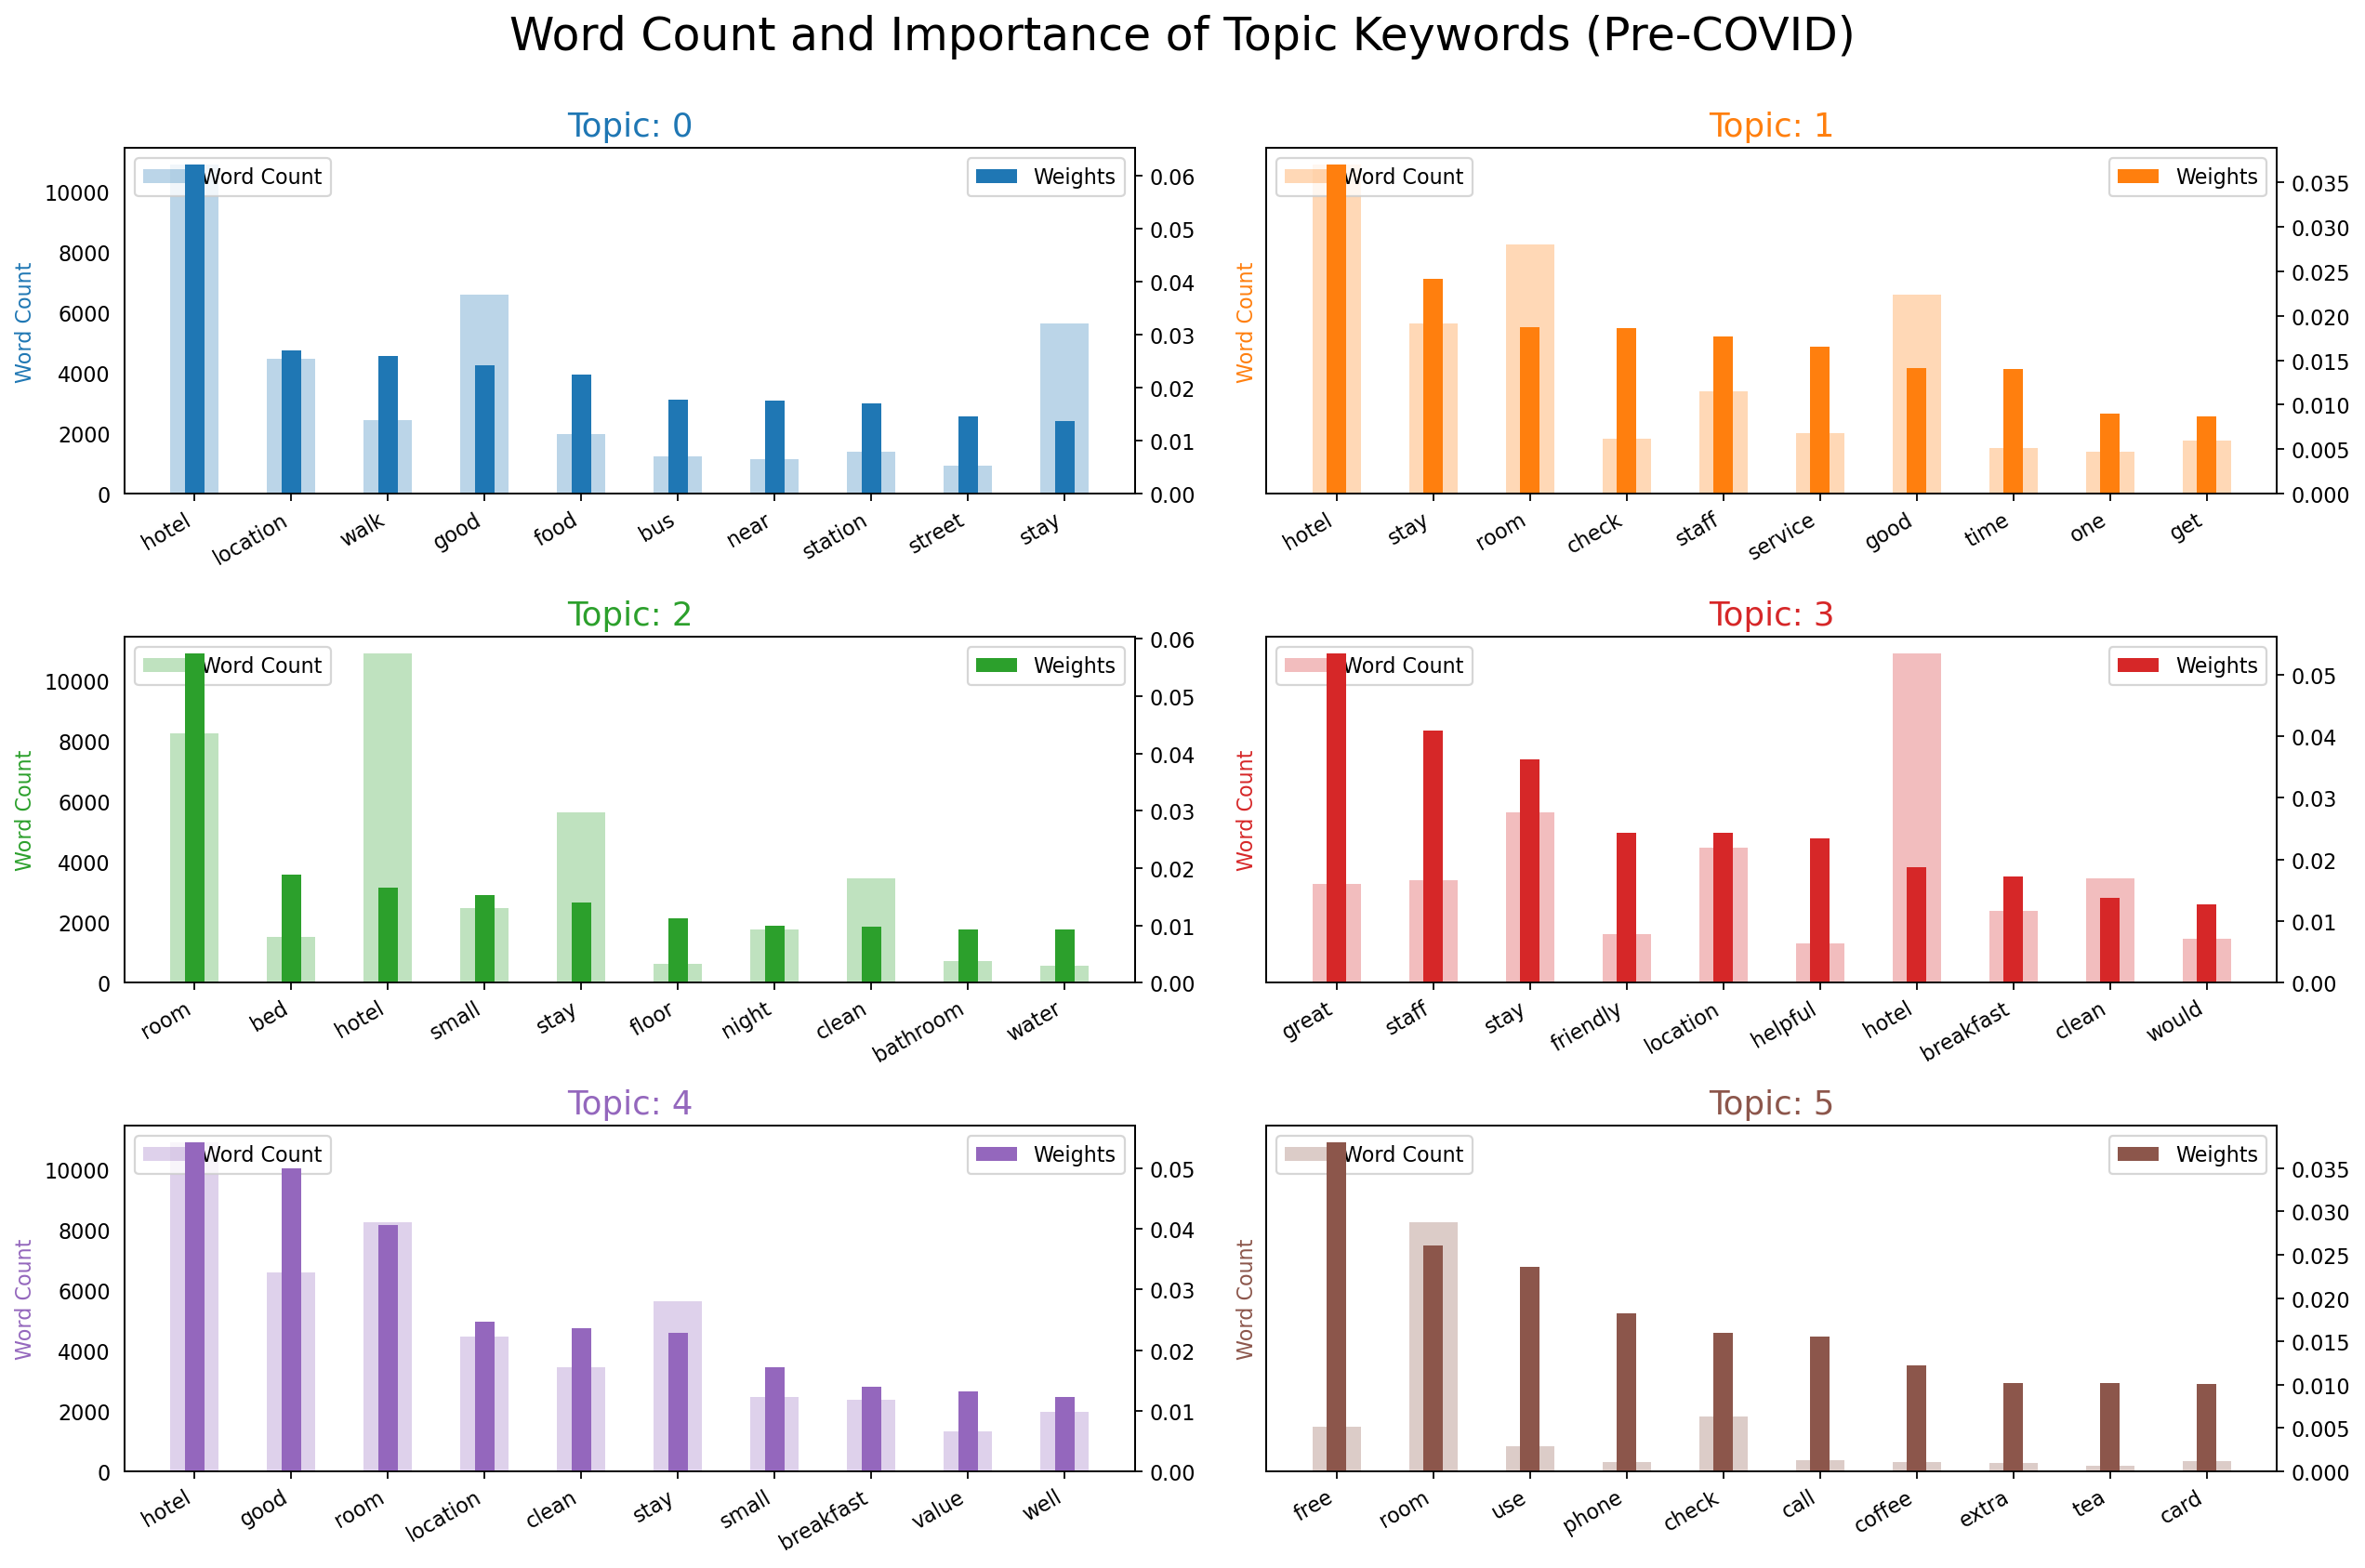

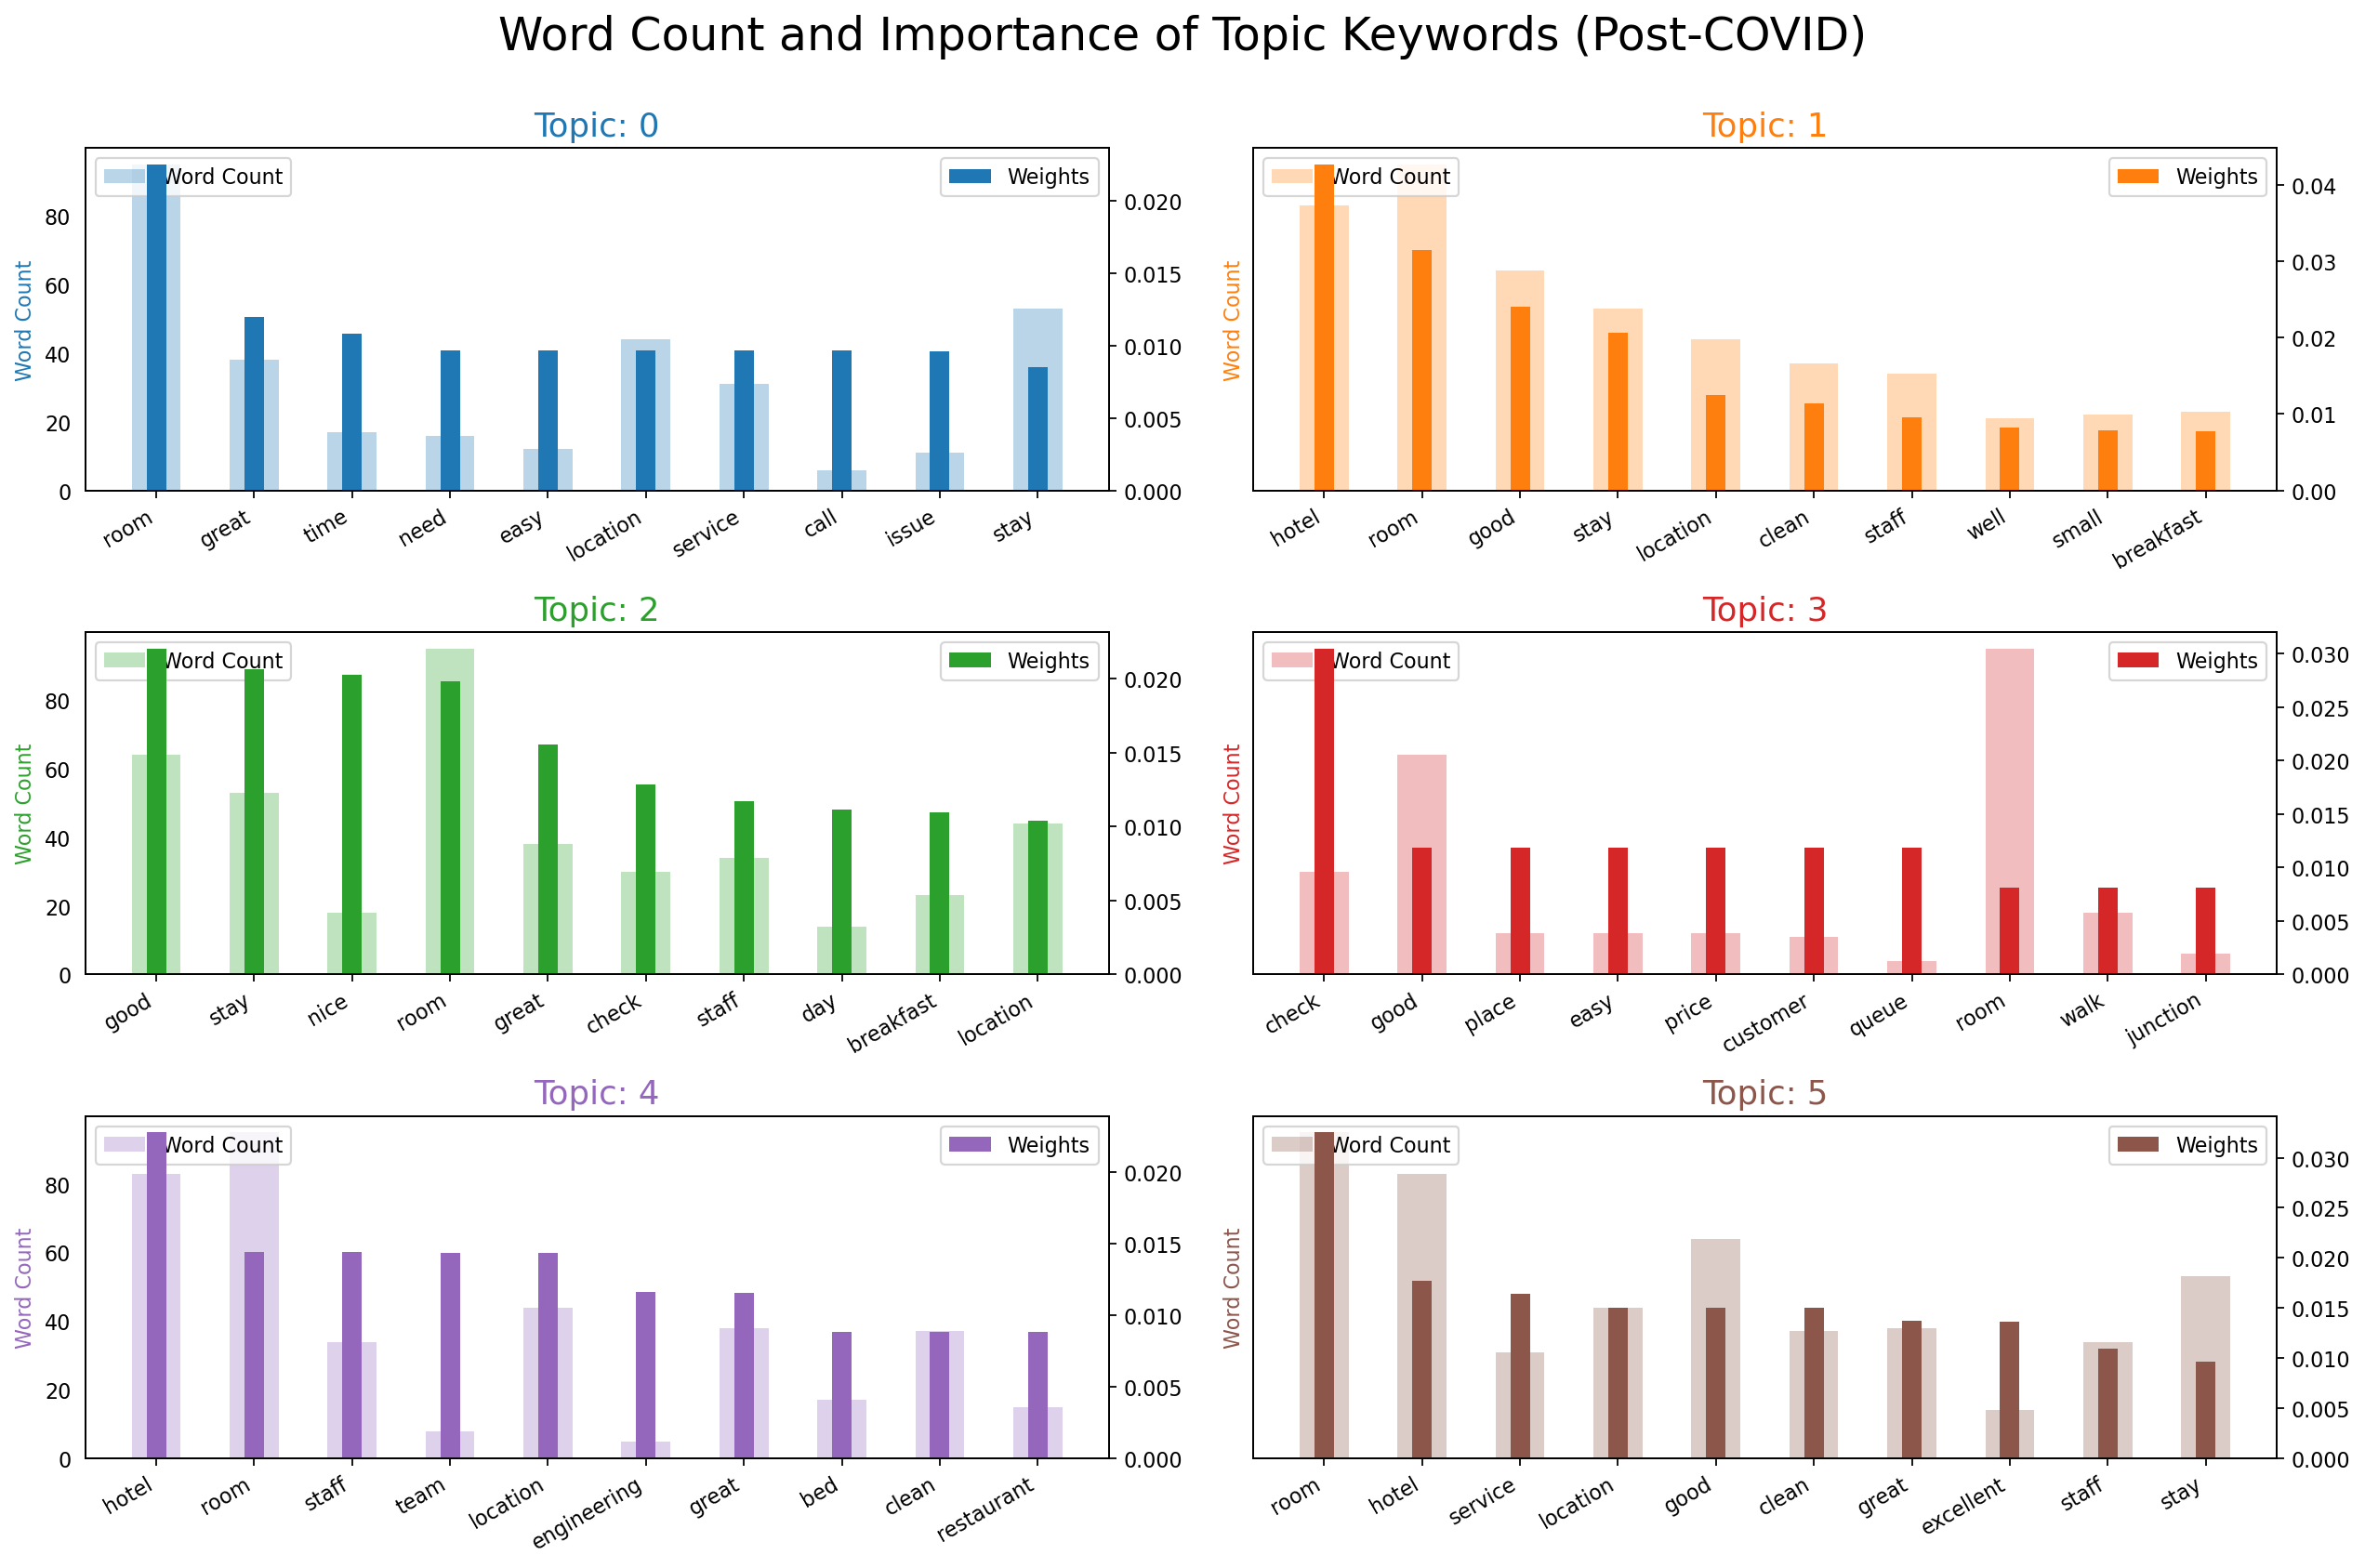

In [40]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')

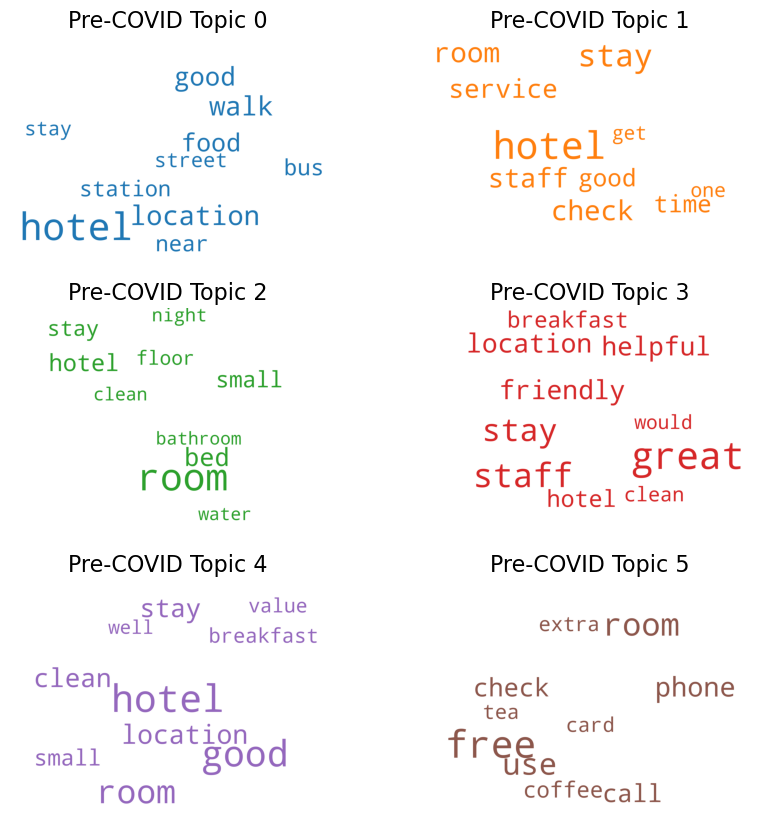

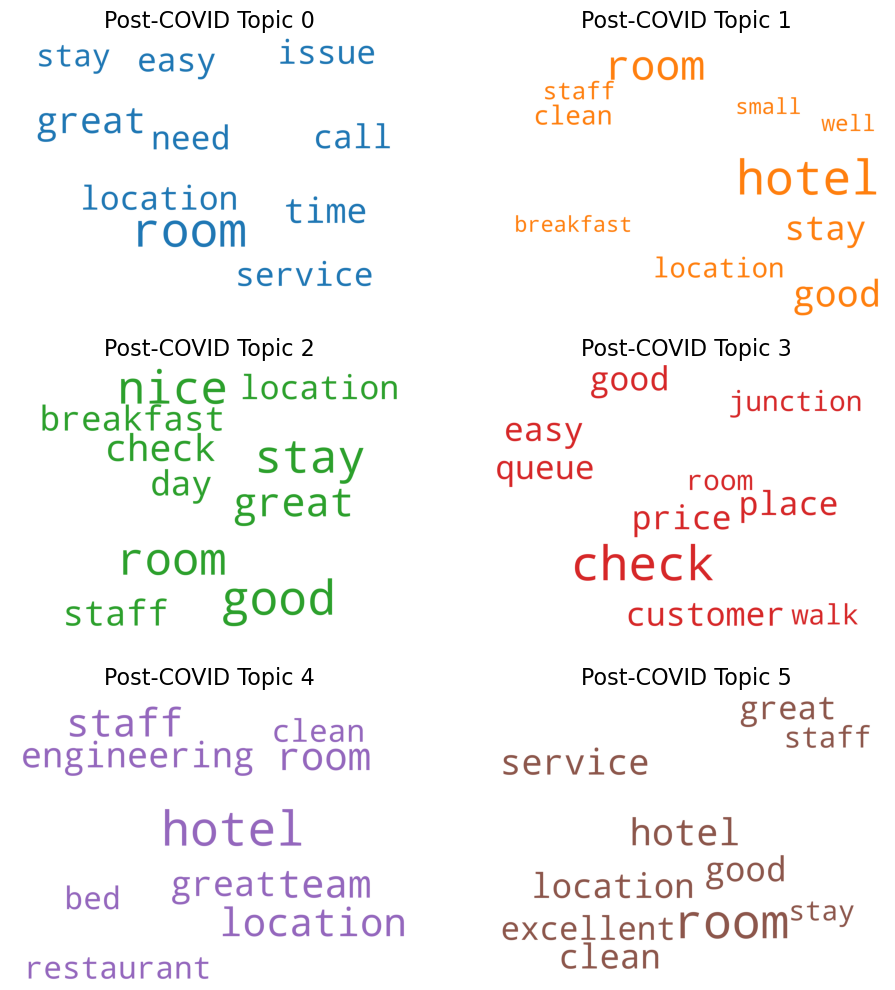

In [41]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Visualising unigrams

In [42]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_precovid['tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_precovid['tokens']]

In [43]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(df_postcovid['tokens'])
post_corpus = [post_dict.doc2bow(text) for text in df_postcovid['tokens']]

In [44]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [45]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = pre_ldamodel.show_topics(num_topics=5, num_words=10)
topics_with_low_relevance = pre_ldamodel.show_topics(num_topics=5, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.062*"hotel" + 0.046*"stay" + 0.041*"good" + 0.036*"staff" + 0.031*"location" + 0.026*"great" + 0.022*"room" + 0.020*"clean" + 0.018*"nice" + 0.018*"friendly"
Topic 1: 0.031*"breakfast" + 0.014*"buffet" + 0.014*"well" + 0.012*"staff" + 0.012*"hotel" + 0.011*"stay" + 0.010*"food" + 0.009*"taste" + 0.008*"restaurant" + 0.008*"room"
Topic 2: 0.050*"room" + 0.037*"hotel" + 0.027*"good" + 0.018*"stay" + 0.018*"small" + 0.015*"clean" + 0.013*"bed" + 0.010*"location" + 0.009*"well" + 0.009*"night"
Topic 3: 0.031*"check" + 0.021*"room" + 0.015*"time" + 0.015*"hotel" + 0.014*"get" + 0.011*"arrive" + 0.011*"staff" + 0.011*"service" + 0.010*"one" + 0.010*"ask"
Topic 4: 0.044*"hotel" + 0.024*"walk" + 0.023*"good" + 0.022*"location" + 0.020*"room" + 0.016*"great" + 0.014*"stay" + 0.013*"food" + 0.013*"clean" + 0.012*"bus"

Topics with low relevance:
Topic 0: 0.062*"hotel" + 0.046*"stay" + 0.041*"good" + 0.036*"staff" + 0.031*"location"
Topic 1: 0.031*"breakfast

In [46]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=5, id2word=post_dict, passes=15)

In [47]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in df_precovid['tokens'] for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in df_postcovid['tokens'] for word in word_list]

In [48]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = post_ldamodel.show_topics(num_topics=5, num_words=10)
topics_with_low_relevance = post_ldamodel.show_topics(num_topics=5, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.024*"room" + 0.016*"great" + 0.016*"hotel" + 0.011*"good" + 0.010*"breakfast" + 0.010*"also" + 0.008*"clean" + 0.008*"location" + 0.008*"cancel" + 0.008*"comfortable"
Topic 1: 0.012*"room" + 0.012*"old" + 0.009*"part" + 0.009*"small" + 0.009*"one" + 0.009*"need" + 0.005*"year" + 0.005*"hotel" + 0.005*"like" + 0.005*"night"
Topic 2: 0.027*"room" + 0.020*"good" + 0.019*"location" + 0.018*"clean" + 0.015*"hotel" + 0.013*"check" + 0.012*"great" + 0.012*"service" + 0.011*"food" + 0.011*"walk"
Topic 3: 0.027*"hotel" + 0.016*"check" + 0.014*"breakfast" + 0.013*"staff" + 0.012*"team" + 0.009*"engineering" + 0.009*"upgrade" + 0.009*"room" + 0.007*"customer" + 0.007*"good"
Topic 4: 0.032*"room" + 0.029*"hotel" + 0.024*"stay" + 0.023*"good" + 0.014*"location" + 0.011*"service" + 0.011*"clean" + 0.010*"staff" + 0.010*"great" + 0.010*"get"

Topics with low relevance:
Topic 0: 0.024*"room" + 0.016*"great" + 0.016*"hotel" + 0.011*"good" + 0.010*"breakfast"
Topic

In [49]:
import pyLDAvis
import pyLDAvis.gensim

In [50]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [51]:
vis = pyLDAvis.gensim.prepare(topic_model=post_ldamodel, corpus=post_corpus, dictionary=post_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Bigrams

In [52]:
clean_precovid = df_precovid['cleaned_review'].apply(preprocess_text)
clean_precovid = clean_precovid.apply(lambda x: ' '.join(x))
clean_postcovid = df_postcovid['cleaned_review'].apply(preprocess_text)
clean_postcovid = clean_postcovid.apply(lambda x: ' '.join(x))

In [53]:
from nltk import ngrams
bigrams_precovid = []
bigrams_postcovid = []

for d in clean_precovid:
    tokens = word_tokenize(d)
    bigrams_precovid.append(["_".join(w) for w in ngrams(tokens, 2)])

for e in clean_postcovid:
    tokens = word_tokenize(e)
    bigrams_postcovid.append(['_'.join(w) for w in ngrams(tokens, 2)])


In [54]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_precovid)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_precovid]

In [55]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [56]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(bigrams_postcovid)
post_corpus = [post_dict.doc2bow(text) for text in bigrams_postcovid]

In [57]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=5, id2word=post_dict, passes=15)

In [58]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = post_ldamodel.show_topics(num_topics=4, num_words=10)
topics_with_low_relevance = post_ldamodel.show_topics(num_topics=4, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 2: 0.003*"great_location" + 0.003*"walk_distance" + 0.003*"engineering_team" + 0.002*"staff_nice" + 0.002*"cleaning_staff" + 0.002*"extra_benefit" + 0.002*"cancel_booking" + 0.002*"location_good" + 0.002*"hotel_room" + 0.002*"value_money"
Topic 0: 0.004*"good_location" + 0.003*"great_location" + 0.003*"location_great" + 0.003*"clean_room" + 0.003*"room_small" + 0.002*"walk_distance" + 0.002*"room_clean" + 0.002*"small_room" + 0.002*"good_hotel" + 0.002*"next_door"
Topic 4: 0.003*"well_locate" + 0.003*"hotel_well" + 0.003*"good_location" + 0.003*"bed_comfortable" + 0.003*"room_service" + 0.003*"nice_location" + 0.003*"affordable_hotel" + 0.003*"staff_efficient" + 0.003*"property_room" + 0.001*"hotel_great"
Topic 3: 0.006*"location_great" + 0.005*"great_location" + 0.004*"room_small" + 0.003*"front_desk" + 0.002*"buffet_breakfast" + 0.002*"next_door" + 0.002*"size_room" + 0.002*"one_good" + 0.002*"walk_distance" + 0.002*"hawker_center"

Topics with low r

In [59]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [60]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_precovid for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in bigrams_postcovid for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\2307337869.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


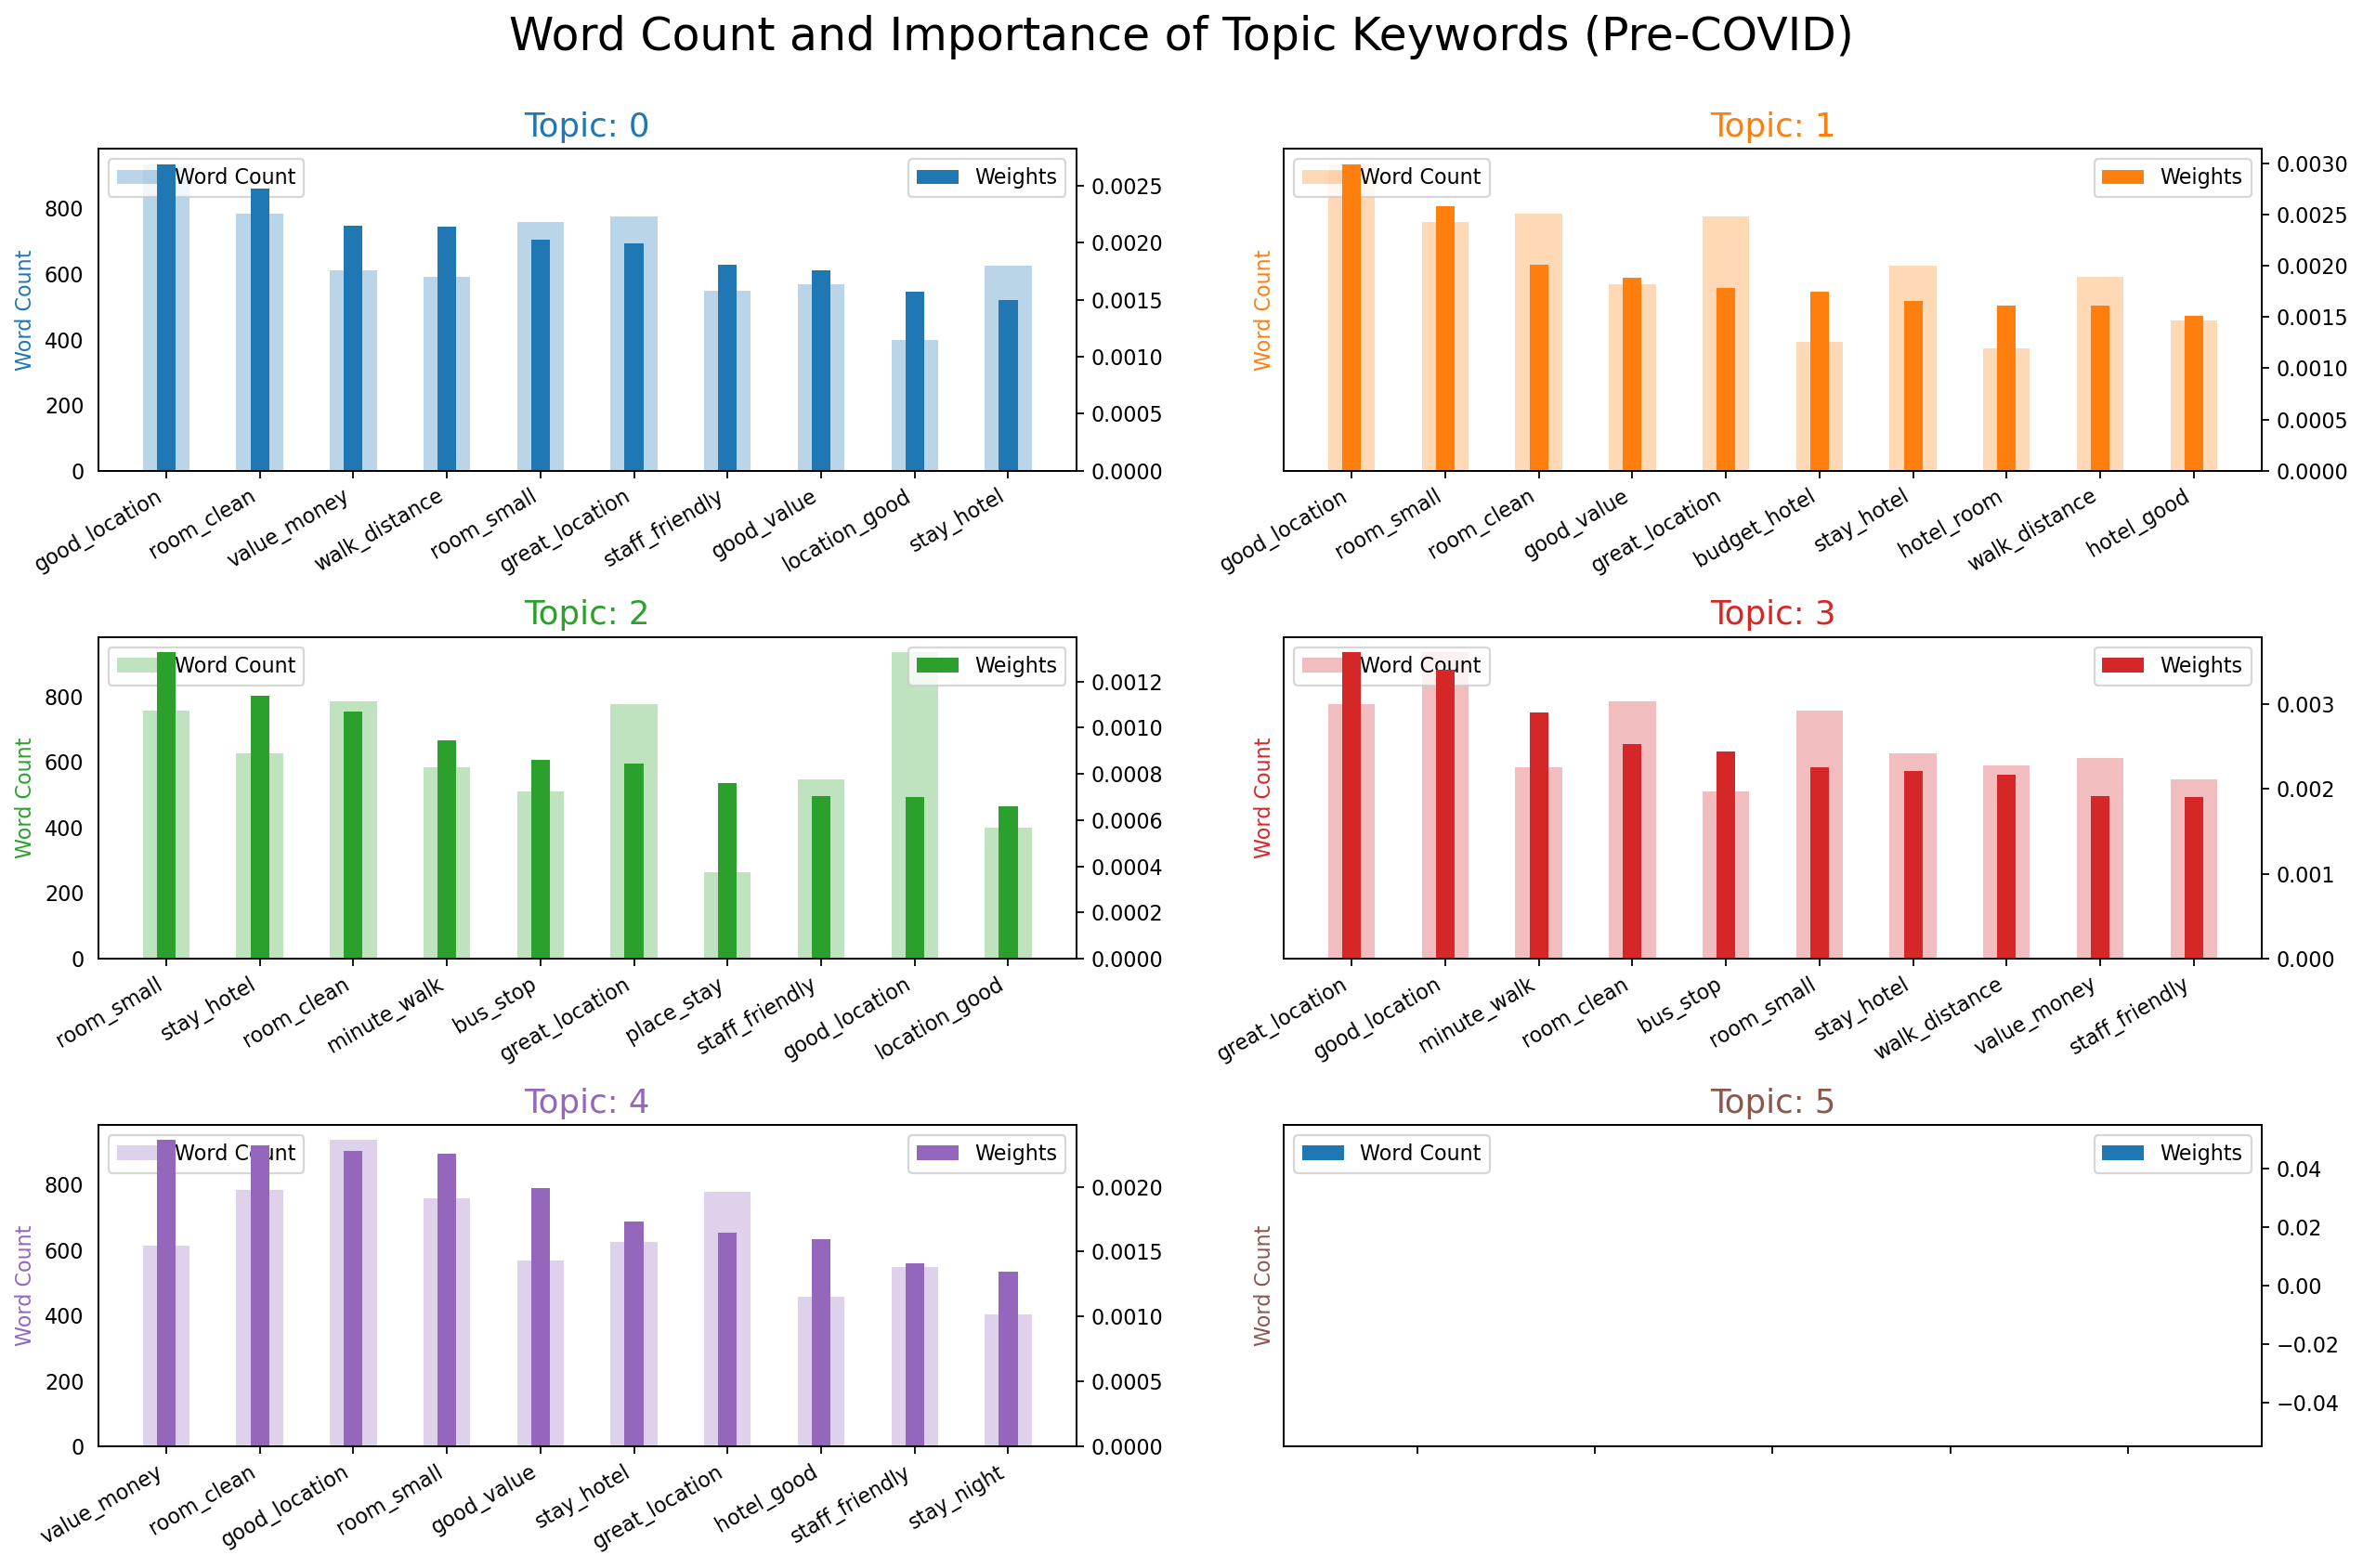

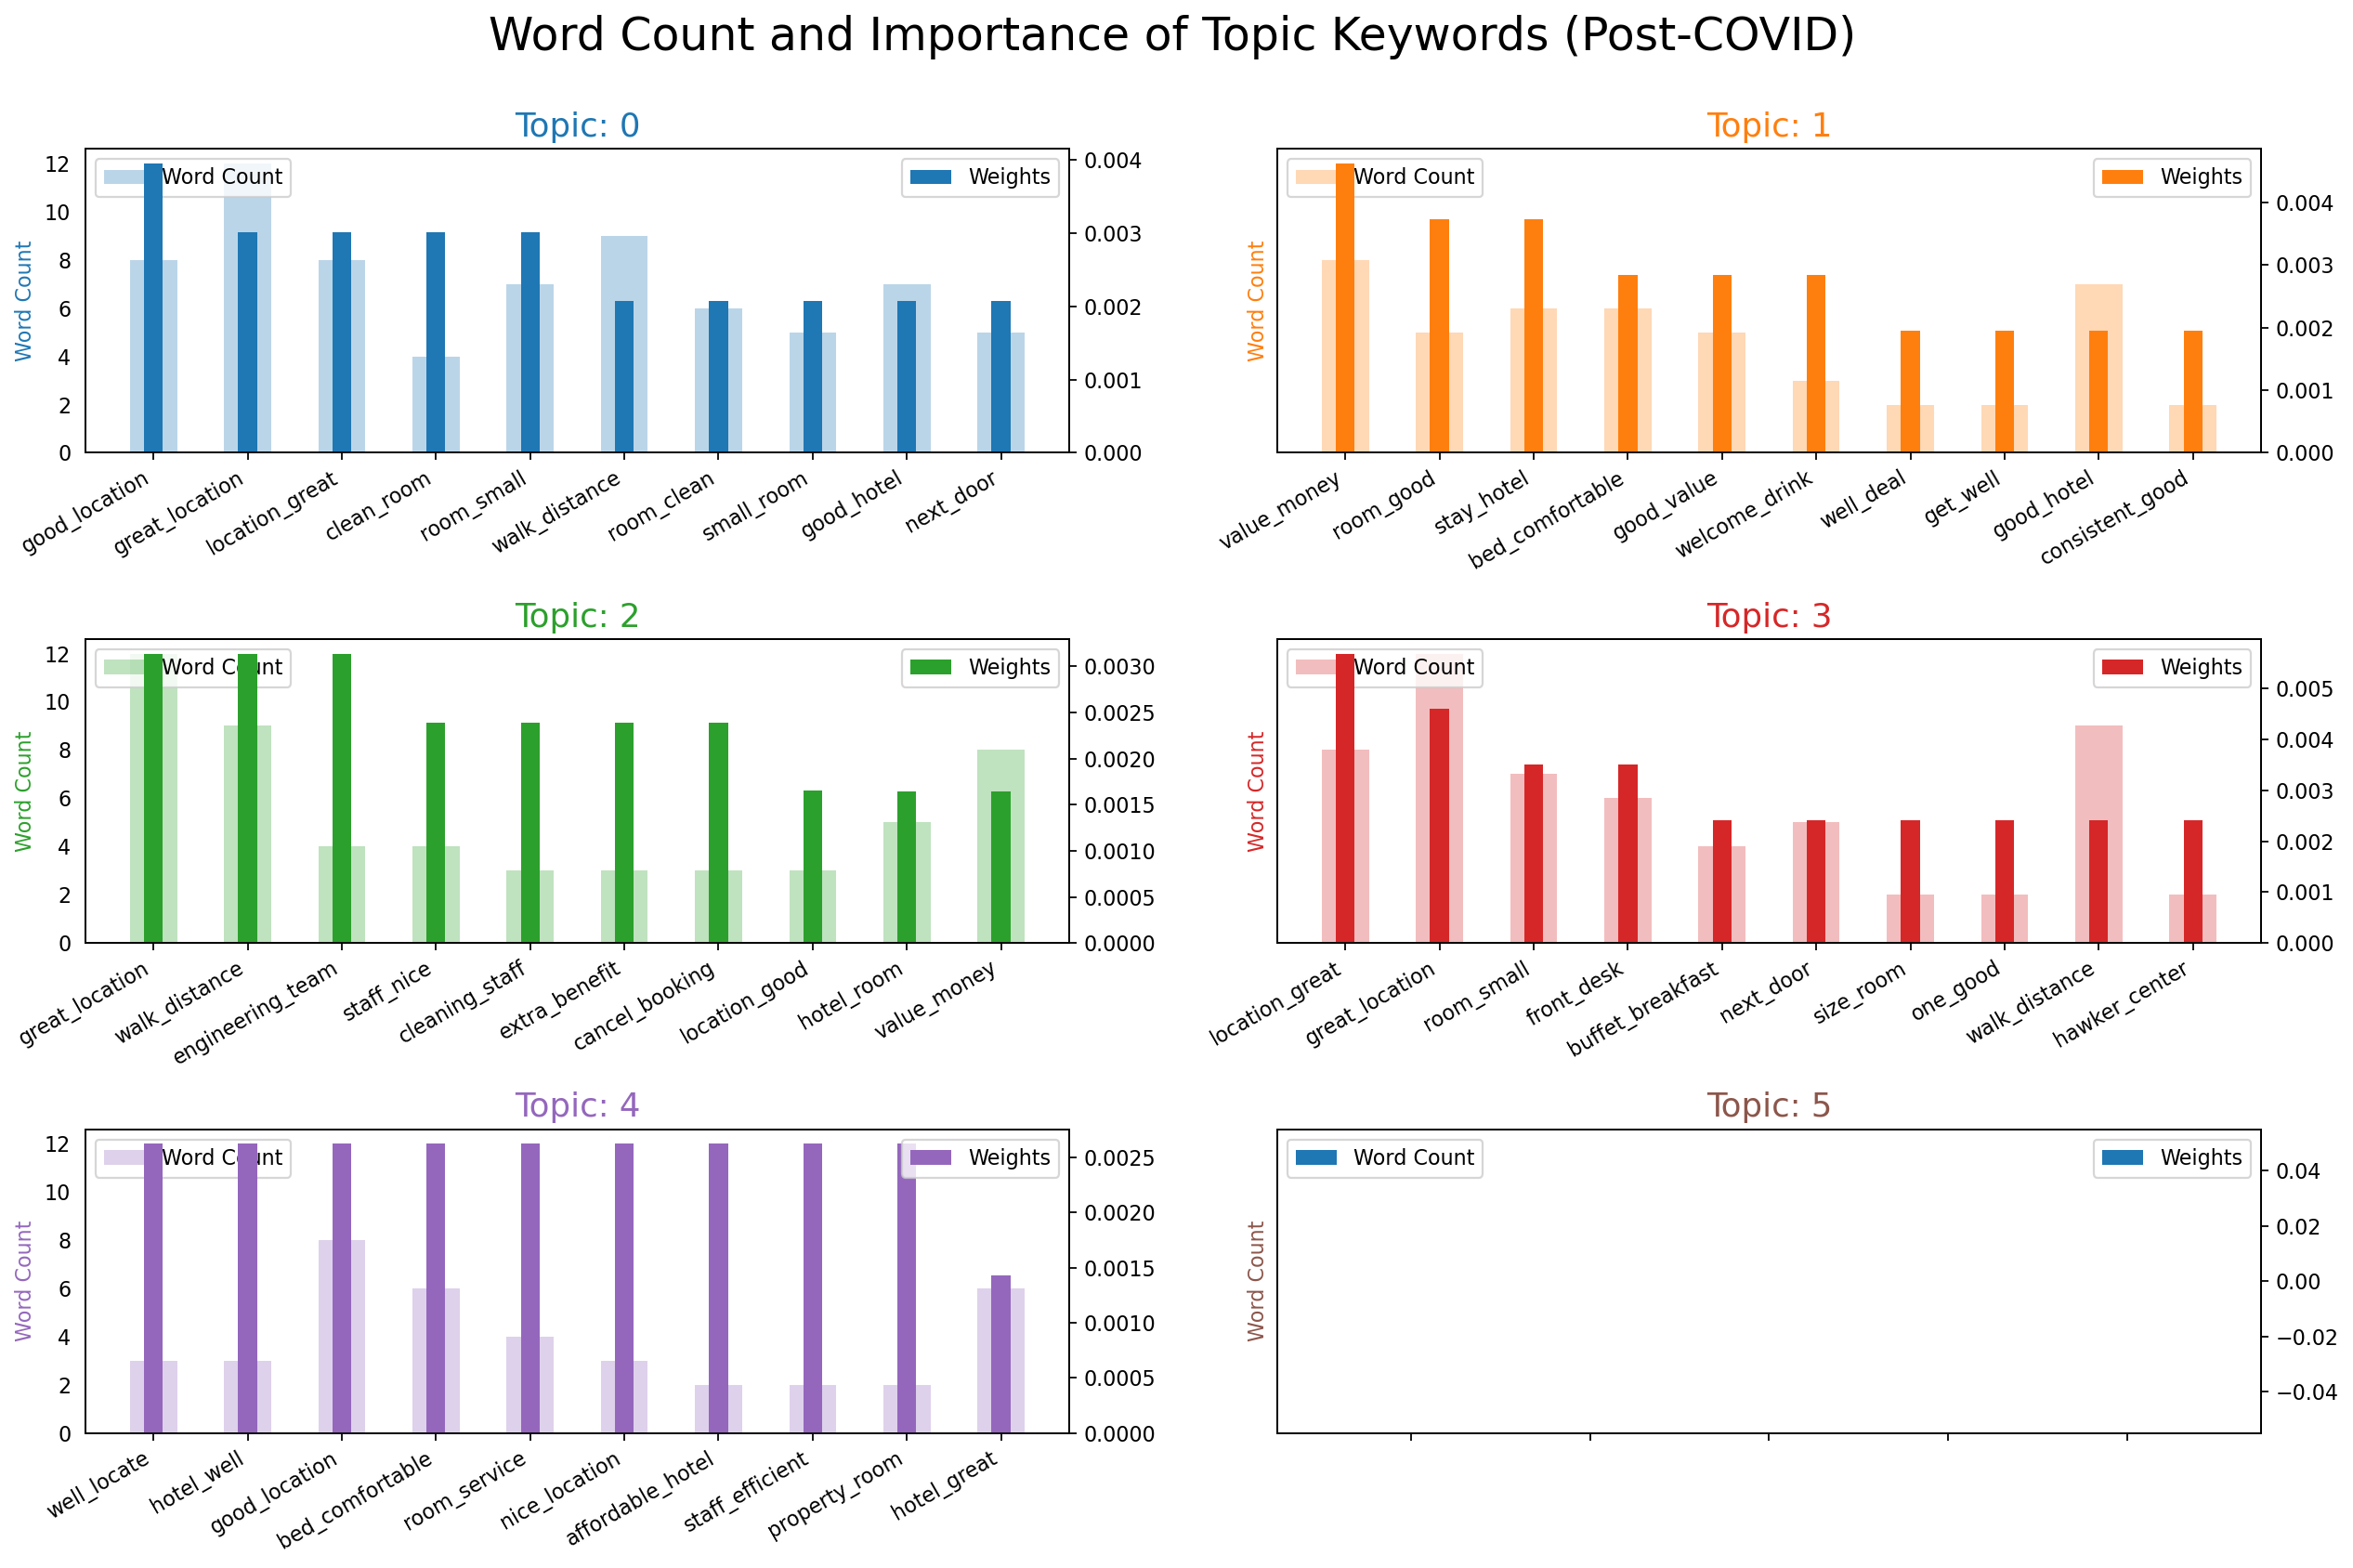

In [61]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')

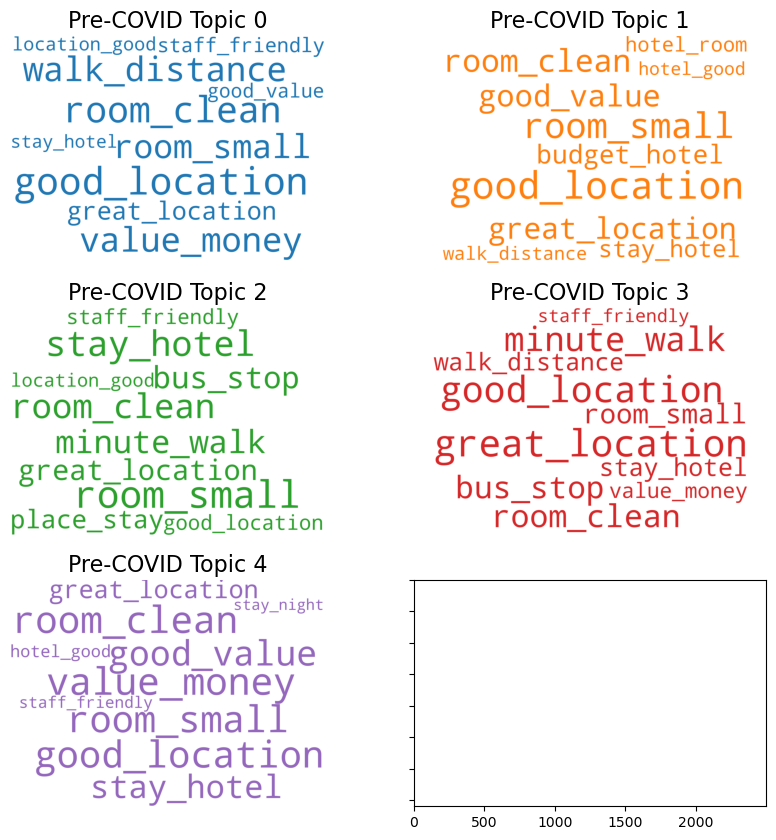

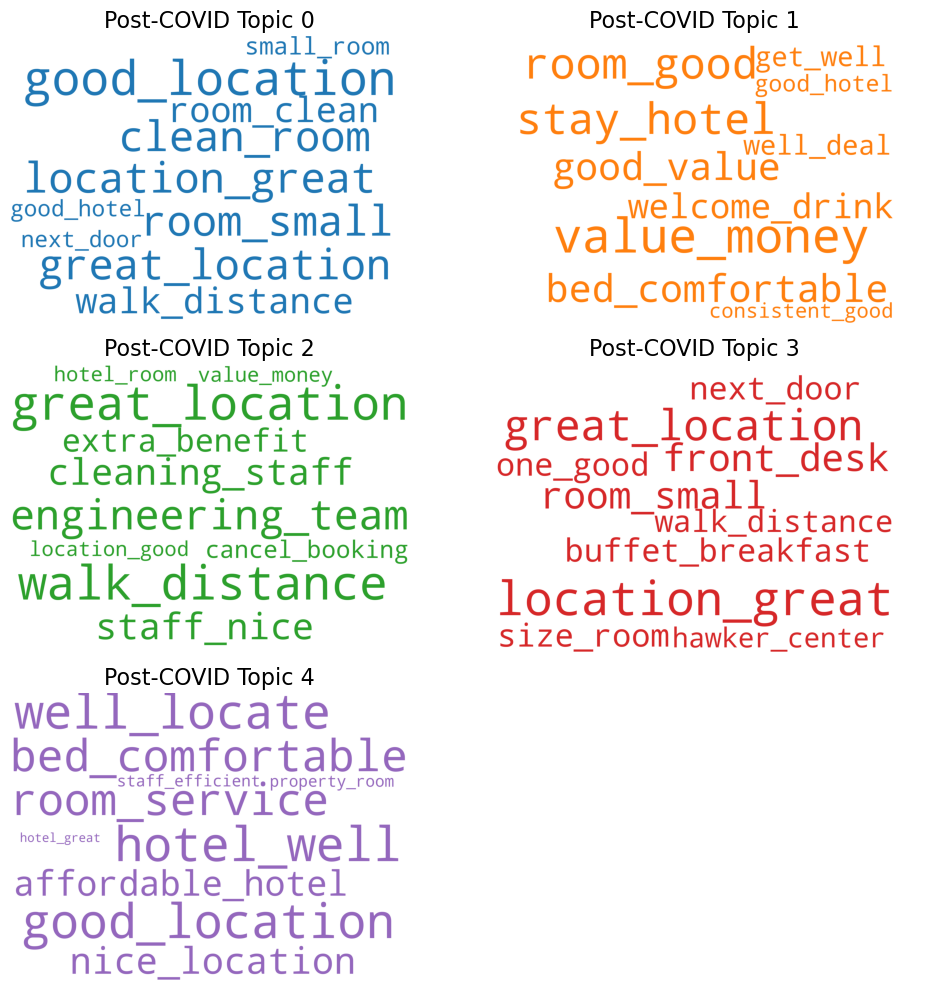

In [62]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Bigram 4 Topics

In [63]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_precovid)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_precovid]

In [64]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=4, id2word=pre_dict, passes=15)

In [65]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(bigrams_postcovid)
post_corpus = [post_dict.doc2bow(text) for text in bigrams_postcovid]

In [66]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=4, id2word=post_dict, passes=15)

In [67]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = post_ldamodel.show_topics(num_topics=4, num_words=10)
topics_with_low_relevance = post_ldamodel.show_topics(num_topics=4, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.003*"walk_distance" + 0.003*"good_location" + 0.003*"stay_hotel" + 0.002*"good_hotel" + 0.002*"front_desk" + 0.002*"hotel_good" + 0.002*"good_place" + 0.002*"check_check" + 0.002*"could_wrench" + 0.002*"star_hotel"
Topic 1: 0.003*"room_small" + 0.003*"engineering_team" + 0.002*"excellent_service" + 0.002*"value_money" + 0.002*"location_great" + 0.002*"room_bed" + 0.002*"stay_hotel" + 0.002*"extra_benefit" + 0.002*"cleaning_staff" + 0.002*"room_good"
Topic 2: 0.005*"great_location" + 0.002*"location_great" + 0.002*"next_door" + 0.002*"room_small" + 0.002*"value_money" + 0.002*"walk_distance" + 0.002*"location_good" + 0.002*"cancel_booking" + 0.002*"good_service" + 0.002*"easy_access"
Topic 3: 0.003*"great_location" + 0.002*"front_desk" + 0.002*"bed_comfortable" + 0.002*"good_location" + 0.002*"customer_service" + 0.002*"hotel_great" + 0.002*"friendly_staff" + 0.002*"clean_room" + 0.002*"well_locate" + 0.002*"night_stay"

Topics with low relevance:


In [68]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [69]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_precovid for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in bigrams_postcovid for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\2307337869.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


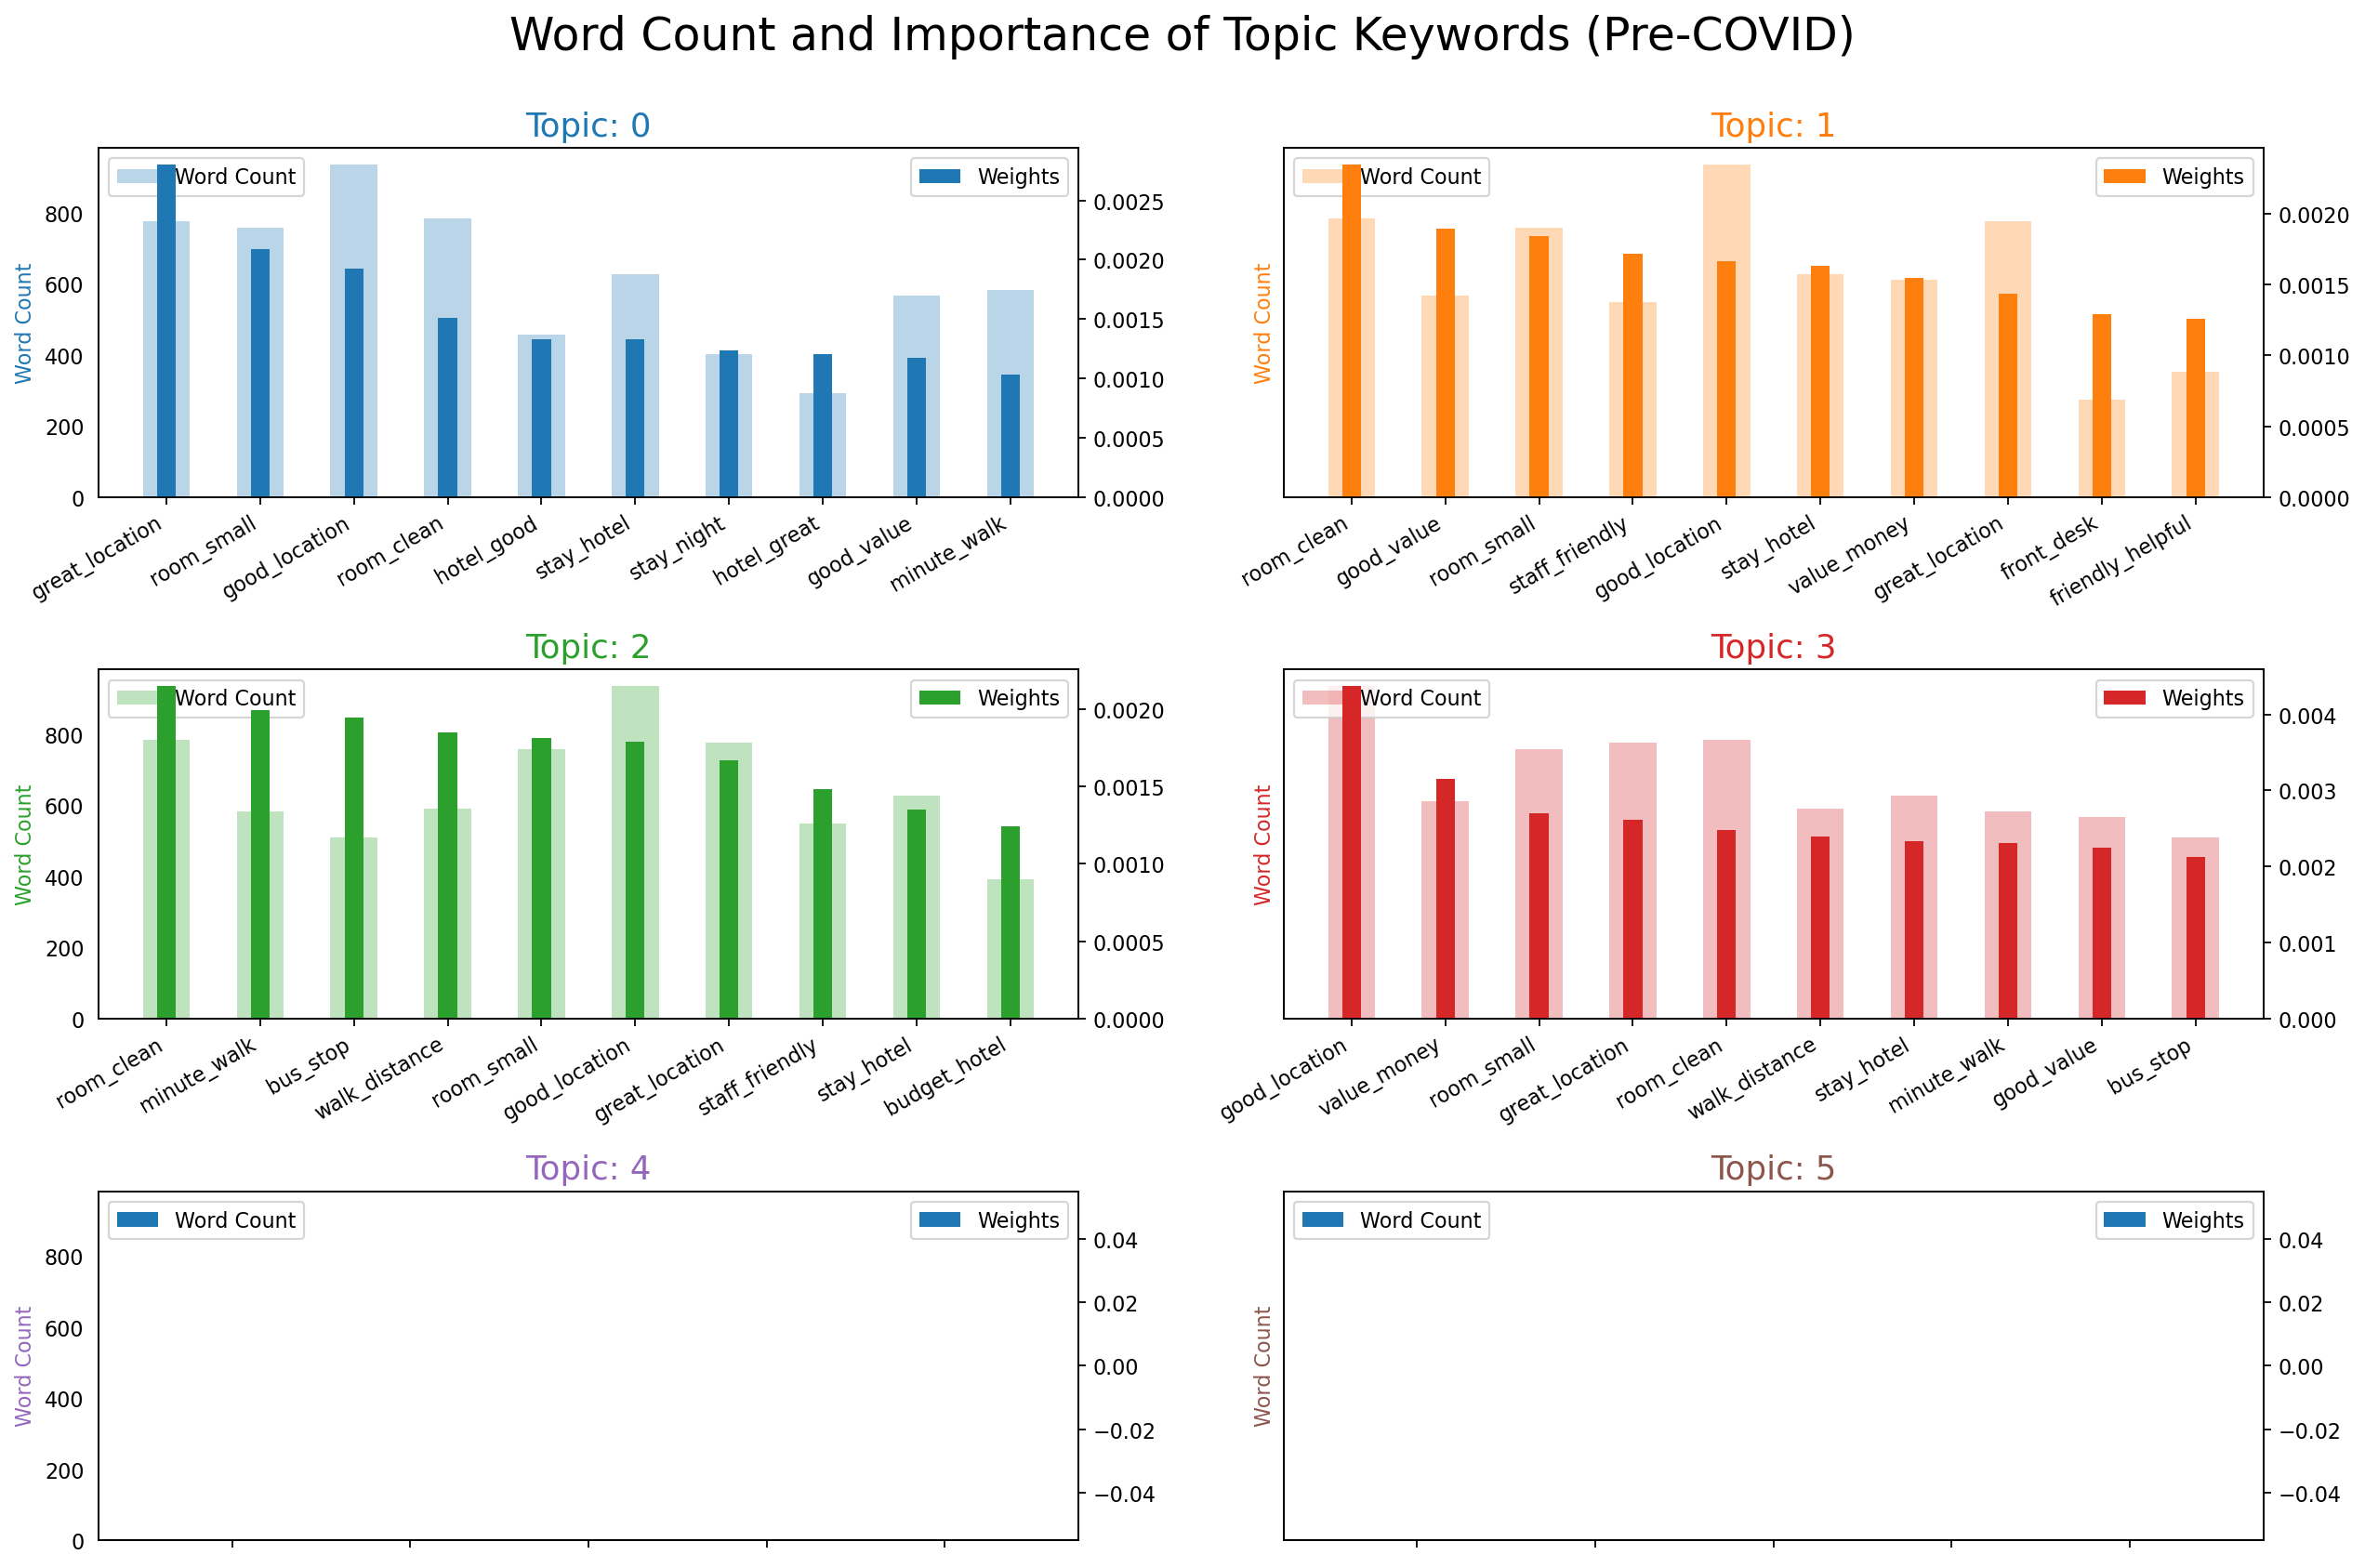

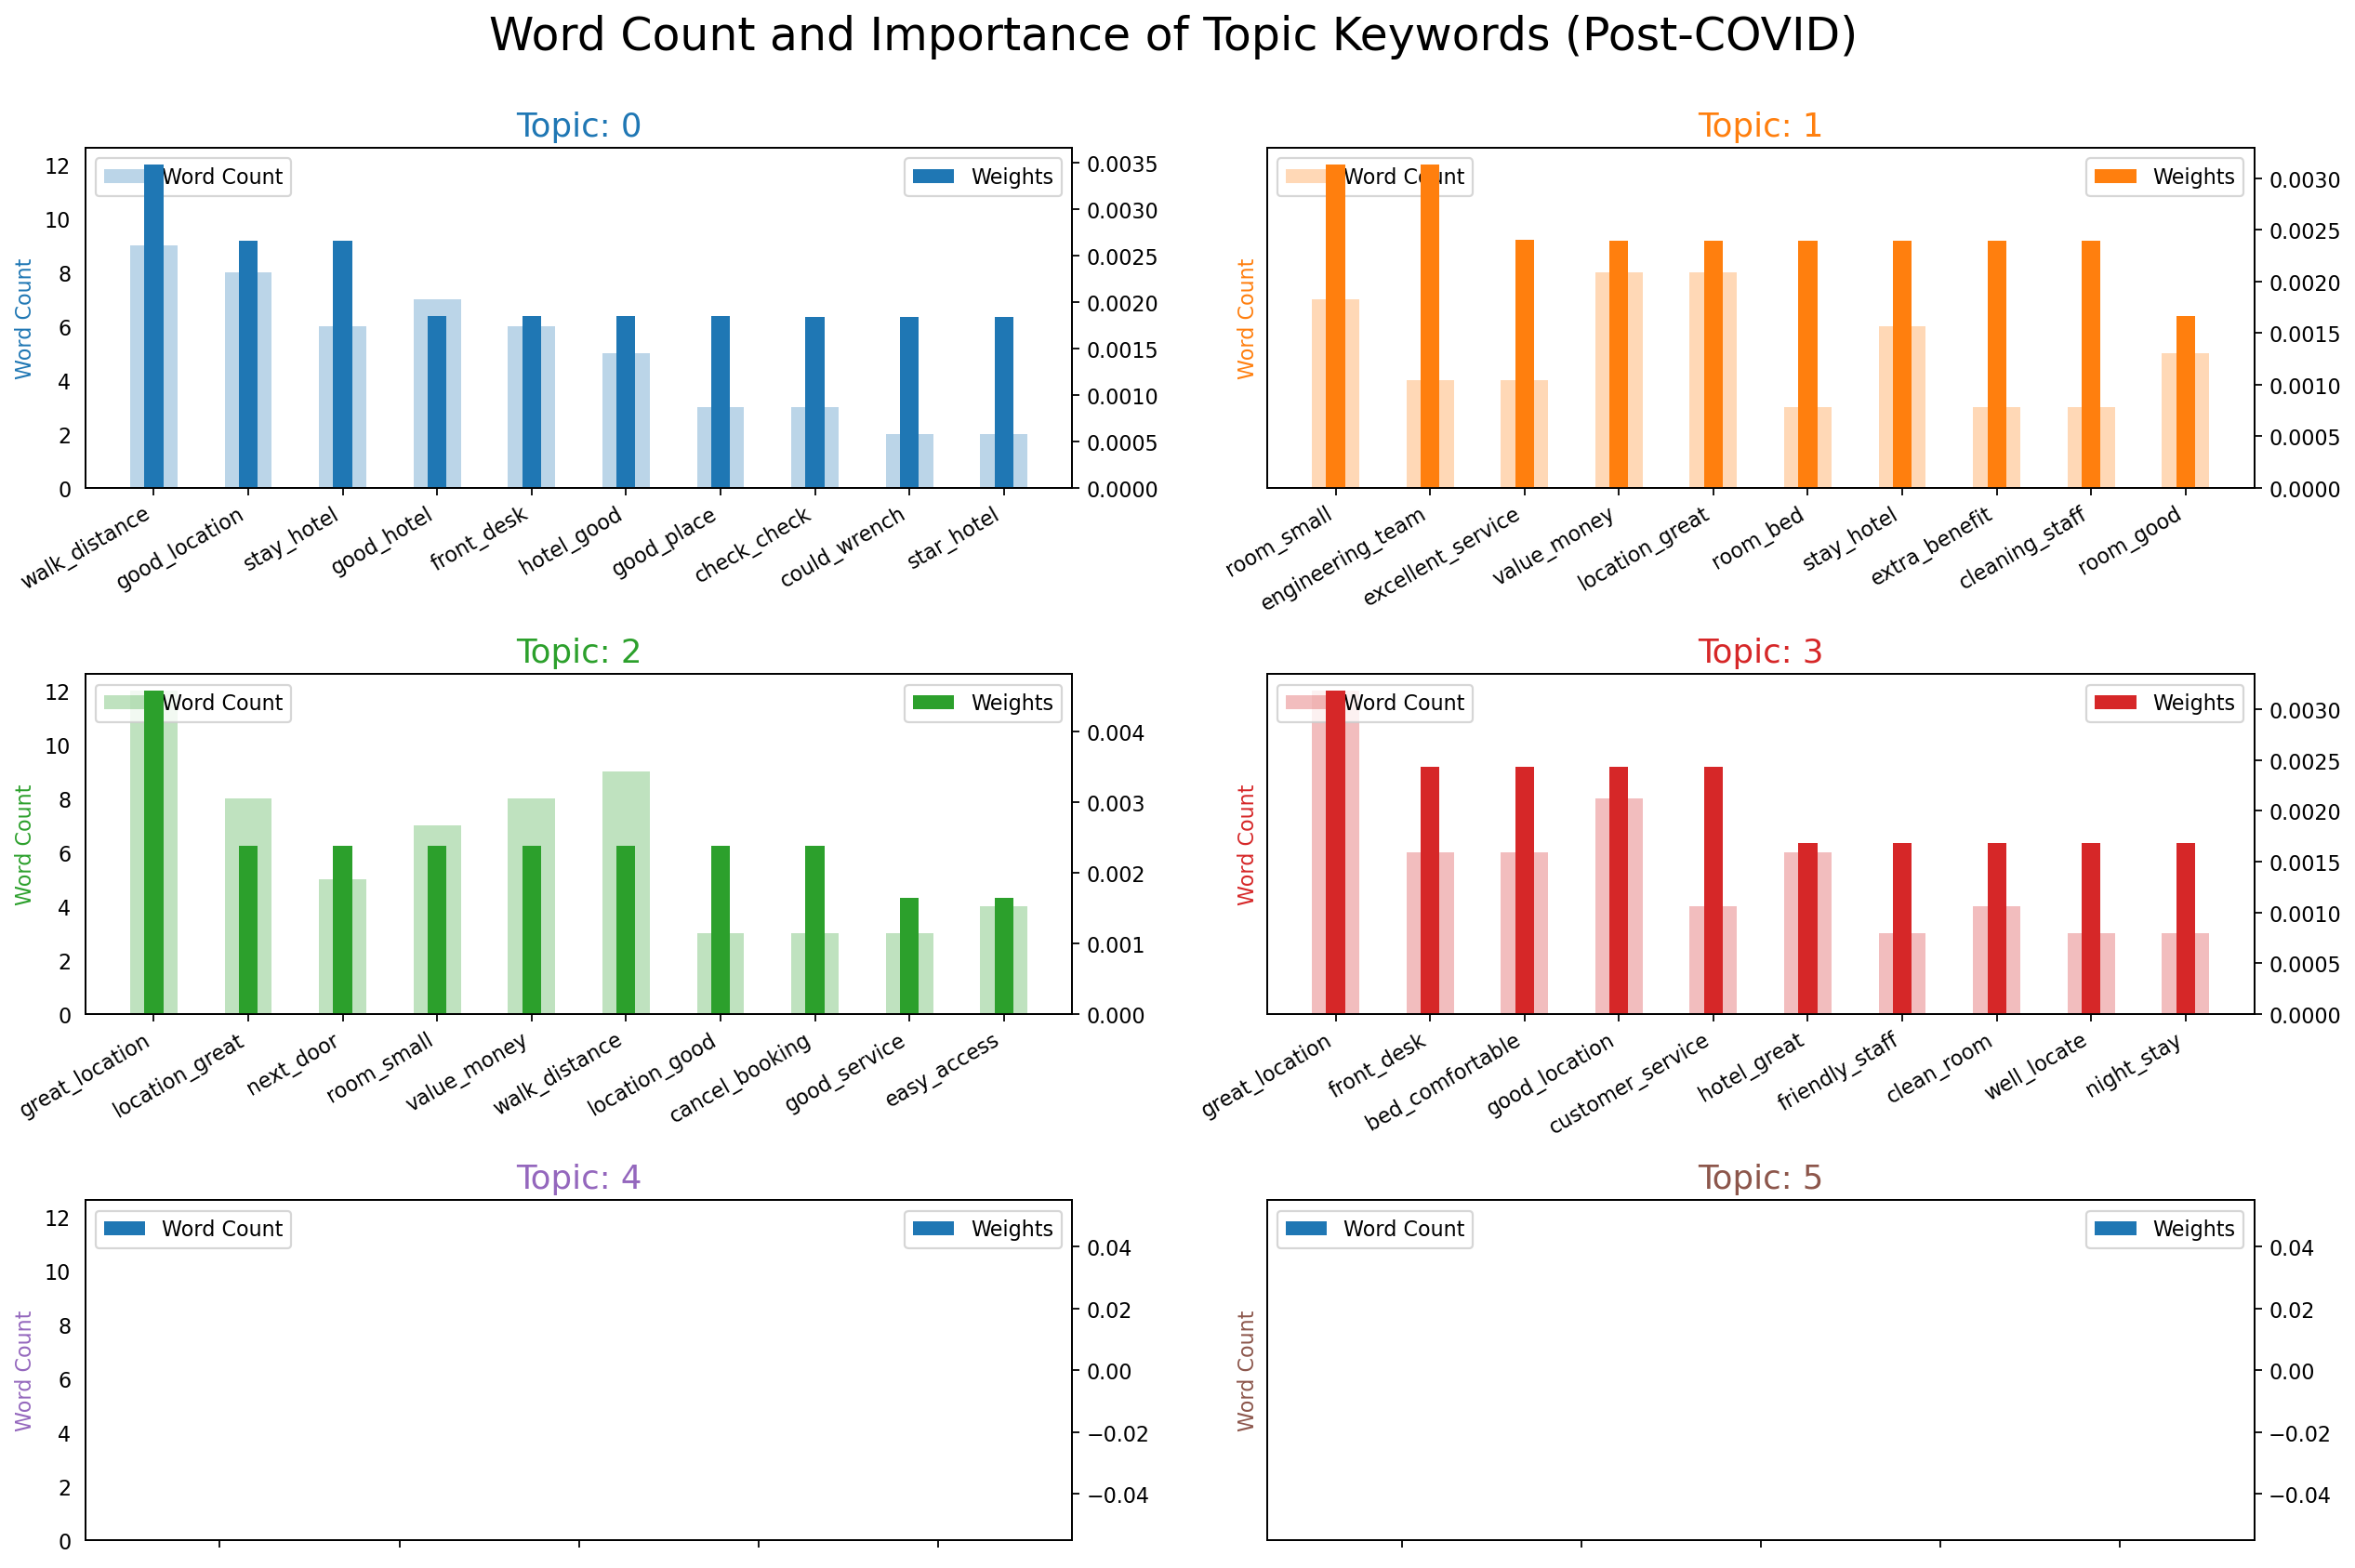

In [70]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')

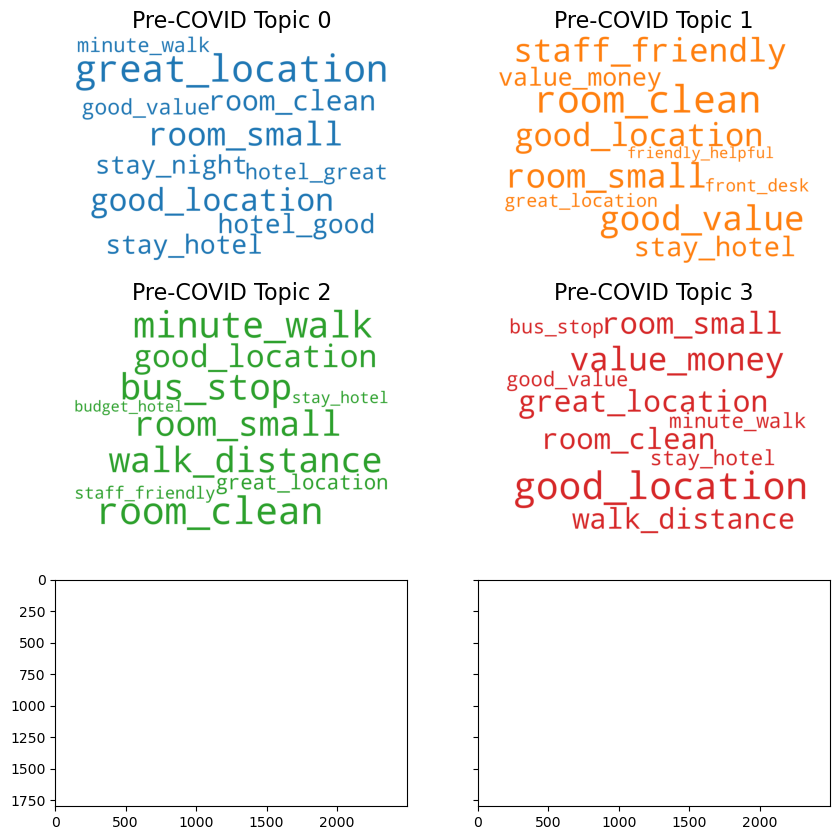

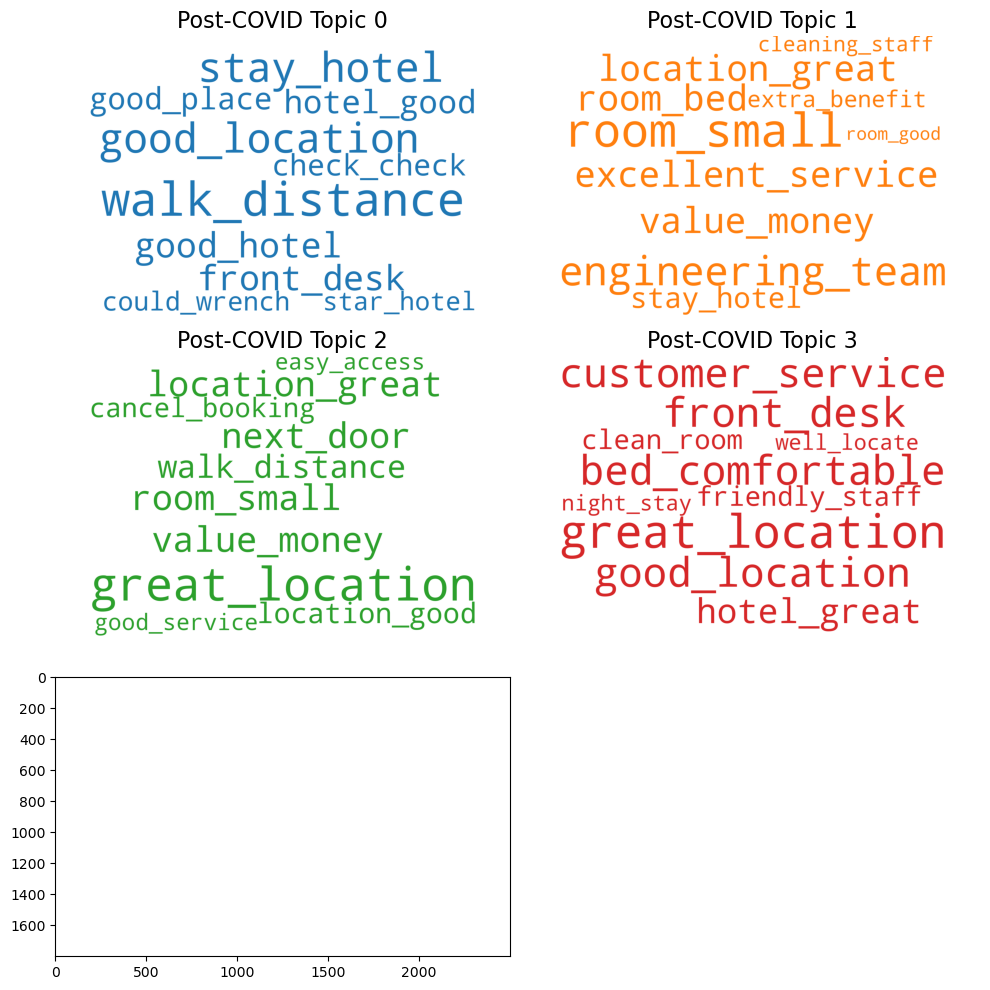

In [71]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(4):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(4):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Visualising bigrams

In [72]:
clean_precovid = df_precovid['cleaned_review'].apply(preprocess_text)
clean_precovid = clean_precovid.apply(lambda x: ' '.join(x))
clean_postcovid = df_postcovid['cleaned_review'].apply(preprocess_text)
clean_postcovid = clean_postcovid.apply(lambda x: ' '.join(x))

In [73]:
from nltk import ngrams
bigrams_precovid = []
bigrams_postcovid = []

for d in clean_precovid:
    tokens = word_tokenize(d)
    bigrams_precovid.append(["_".join(w) for w in ngrams(tokens, 2)])

for e in clean_postcovid:
    tokens = word_tokenize(e)
    bigrams_postcovid.append(['_'.join(w) for w in ngrams(tokens, 2)])


In [74]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_precovid)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_precovid]

In [75]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [76]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(bigrams_postcovid)
post_corpus = [post_dict.doc2bow(text) for text in bigrams_postcovid]

In [77]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=5, id2word=post_dict, passes=15)

In [78]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = post_ldamodel.show_topics(num_topics=4, num_words=10)
topics_with_low_relevance = post_ldamodel.show_topics(num_topics=4, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.006*"location_great" + 0.006*"great_location" + 0.005*"value_money" + 0.003*"good_hotel" + 0.003*"hotel_great" + 0.003*"room_small" + 0.002*"breakfast_option" + 0.002*"reservation_breakfast" + 0.002*"next_door" + 0.002*"small_room"
Topic 2: 0.003*"good_location" + 0.003*"hotel_good" + 0.003*"clean_hotel" + 0.003*"nice_location" + 0.003*"cancel_booking" + 0.002*"hotel_great" + 0.002*"front_desk" + 0.002*"clean_room" + 0.002*"next_door" + 0.002*"stay_hotel"
Topic 4: 0.004*"engineering_team" + 0.003*"cleaning_staff" + 0.003*"staff_nice" + 0.003*"extra_benefit" + 0.002*"room_good" + 0.002*"hotel_stay" + 0.002*"breakfast_good" + 0.002*"preferred_hotel" + 0.002*"excellent_stay" + 0.002*"luggage_handle"
Topic 3: 0.004*"customer_service" + 0.003*"room_small" + 0.003*"good_hotel" + 0.003*"comfortable_room" + 0.002*"bed_comfortable" + 0.002*"well_deal" + 0.002*"get_well" + 0.002*"clean_comfortable" + 0.002*"walk_hotel" + 0.002*"good_location"

Topics with l

In [79]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [80]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_precovid for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in bigrams_postcovid for word in word_list]

In [81]:
import pyLDAvis
import pyLDAvis.gensim

In [82]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [83]:
vis = pyLDAvis.gensim.prepare(topic_model=post_ldamodel, corpus=post_corpus, dictionary=post_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Trigrams

In [84]:
clean_precovid = df_precovid['cleaned_review'].apply(preprocess_text)
clean_precovid = clean_precovid.apply(lambda x: ' '.join(x))
clean_postcovid = df_postcovid['cleaned_review'].apply(preprocess_text)
clean_postcovid = clean_postcovid.apply(lambda x: ' '.join(x))

In [85]:
from nltk import ngrams
trigrams_precovid = []
trigrams_postcovid = []

for d in clean_precovid:
    tokens = word_tokenize(d)
    trigrams_precovid.append(["_".join(w) for w in ngrams(tokens, 3)])

for e in clean_postcovid:
    tokens = word_tokenize(e)
    trigrams_postcovid.append(['_'.join(w) for w in ngrams(tokens, 3)])


In [86]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(trigrams_precovid)
pre_corpus = [pre_dict.doc2bow(text) for text in trigrams_precovid]

In [87]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [88]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(trigrams_postcovid)
post_corpus = [post_dict.doc2bow(text) for text in trigrams_postcovid]

In [89]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=5, id2word=post_dict, passes=15)

In [90]:
# Show topics with different relevance values
# For example, set topn=10 to display the top 10 terms per topic
topics_with_high_relevance = post_ldamodel.show_topics(num_topics=5, num_words=10)
topics_with_low_relevance = post_ldamodel.show_topics(num_topics=5, num_words=5)  # Lower relevance

# Print and examine the topics
print("Topics with high relevance:")
for topic_id, topic in topics_with_high_relevance:
    print(f"Topic {topic_id}: {topic}")

print("\nTopics with low relevance:")
for topic_id, topic in topics_with_low_relevance:
    print(f"Topic {topic_id}: {topic}")

Topics with high relevance:
Topic 0: 0.002*"reservation_breakfast_option" + 0.001*"hotel_well_locate" + 0.001*"door_easy_access" + 0.001*"day_nice_location" + 0.001*"long_time_check" + 0.001*"eleven_next_door" + 0.001*"good_budget_stay" + 0.001*"access_downtown_also" + 0.001*"wait_long_time" + 0.001*"easy_access_downtown"
Topic 1: 0.001*"good_value_money" + 0.001*"get_well_deal" + 0.001*"room_bed_comfortable" + 0.001*"well_deal_village" + 0.001*"big_room_bed" + 0.001*"bed_comfortable_pillow" + 0.001*"comfortable_pillow_headache" + 0.001*"definitely_go_back" + 0.001*"price_pay_get" + 0.001*"deal_village_cheap"
Topic 2: 0.001*"would_recommend_hotel" + 0.001*"room_fantastic_crew" + 0.001*"service_level_manager" + 0.001*"level_manager_great" + 0.001*"good_service_level" + 0.001*"help_always_make" + 0.001*"crew_good_service" + 0.001*"always_willing_help" + 0.001*"home_would_recommend" + 0.001*"kitchen_crew_always"
Topic 3: 0.002*"clean_comfortable_room" + 0.002*"preferred_hotel_stay" + 0.00

In [91]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [92]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in trigrams_precovid for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in trigrams_postcovid for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_19756\2307337869.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


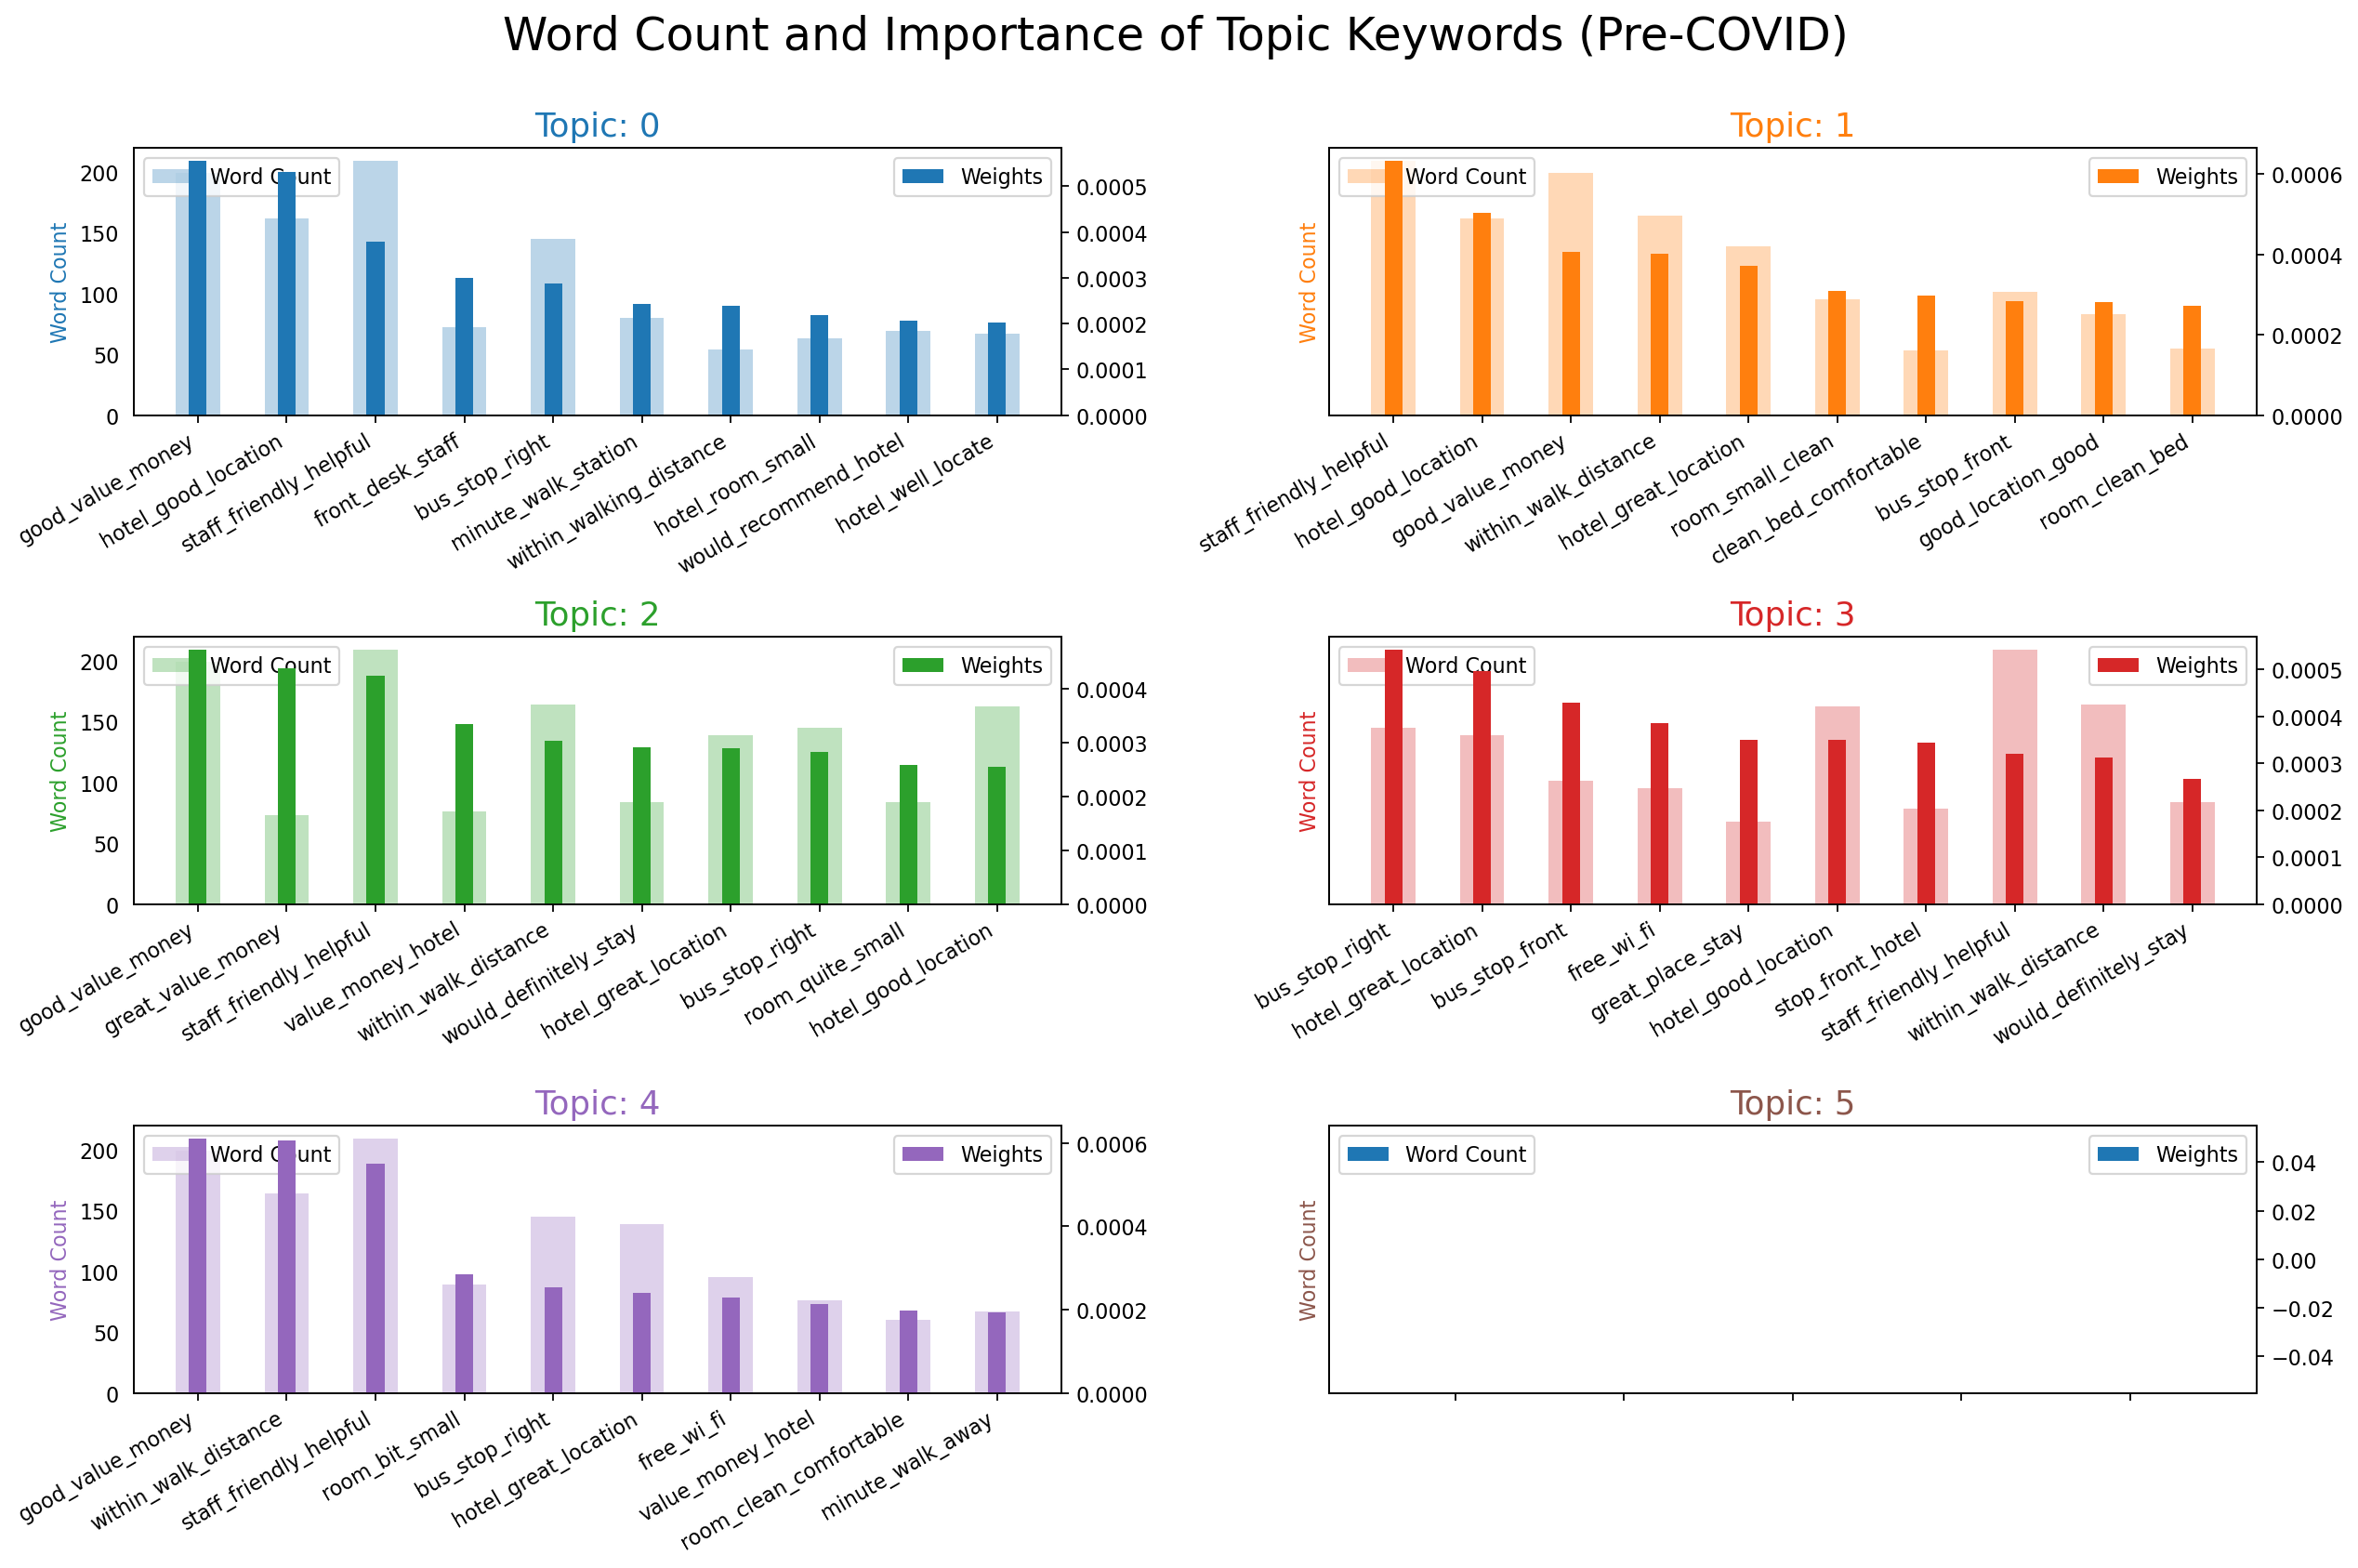

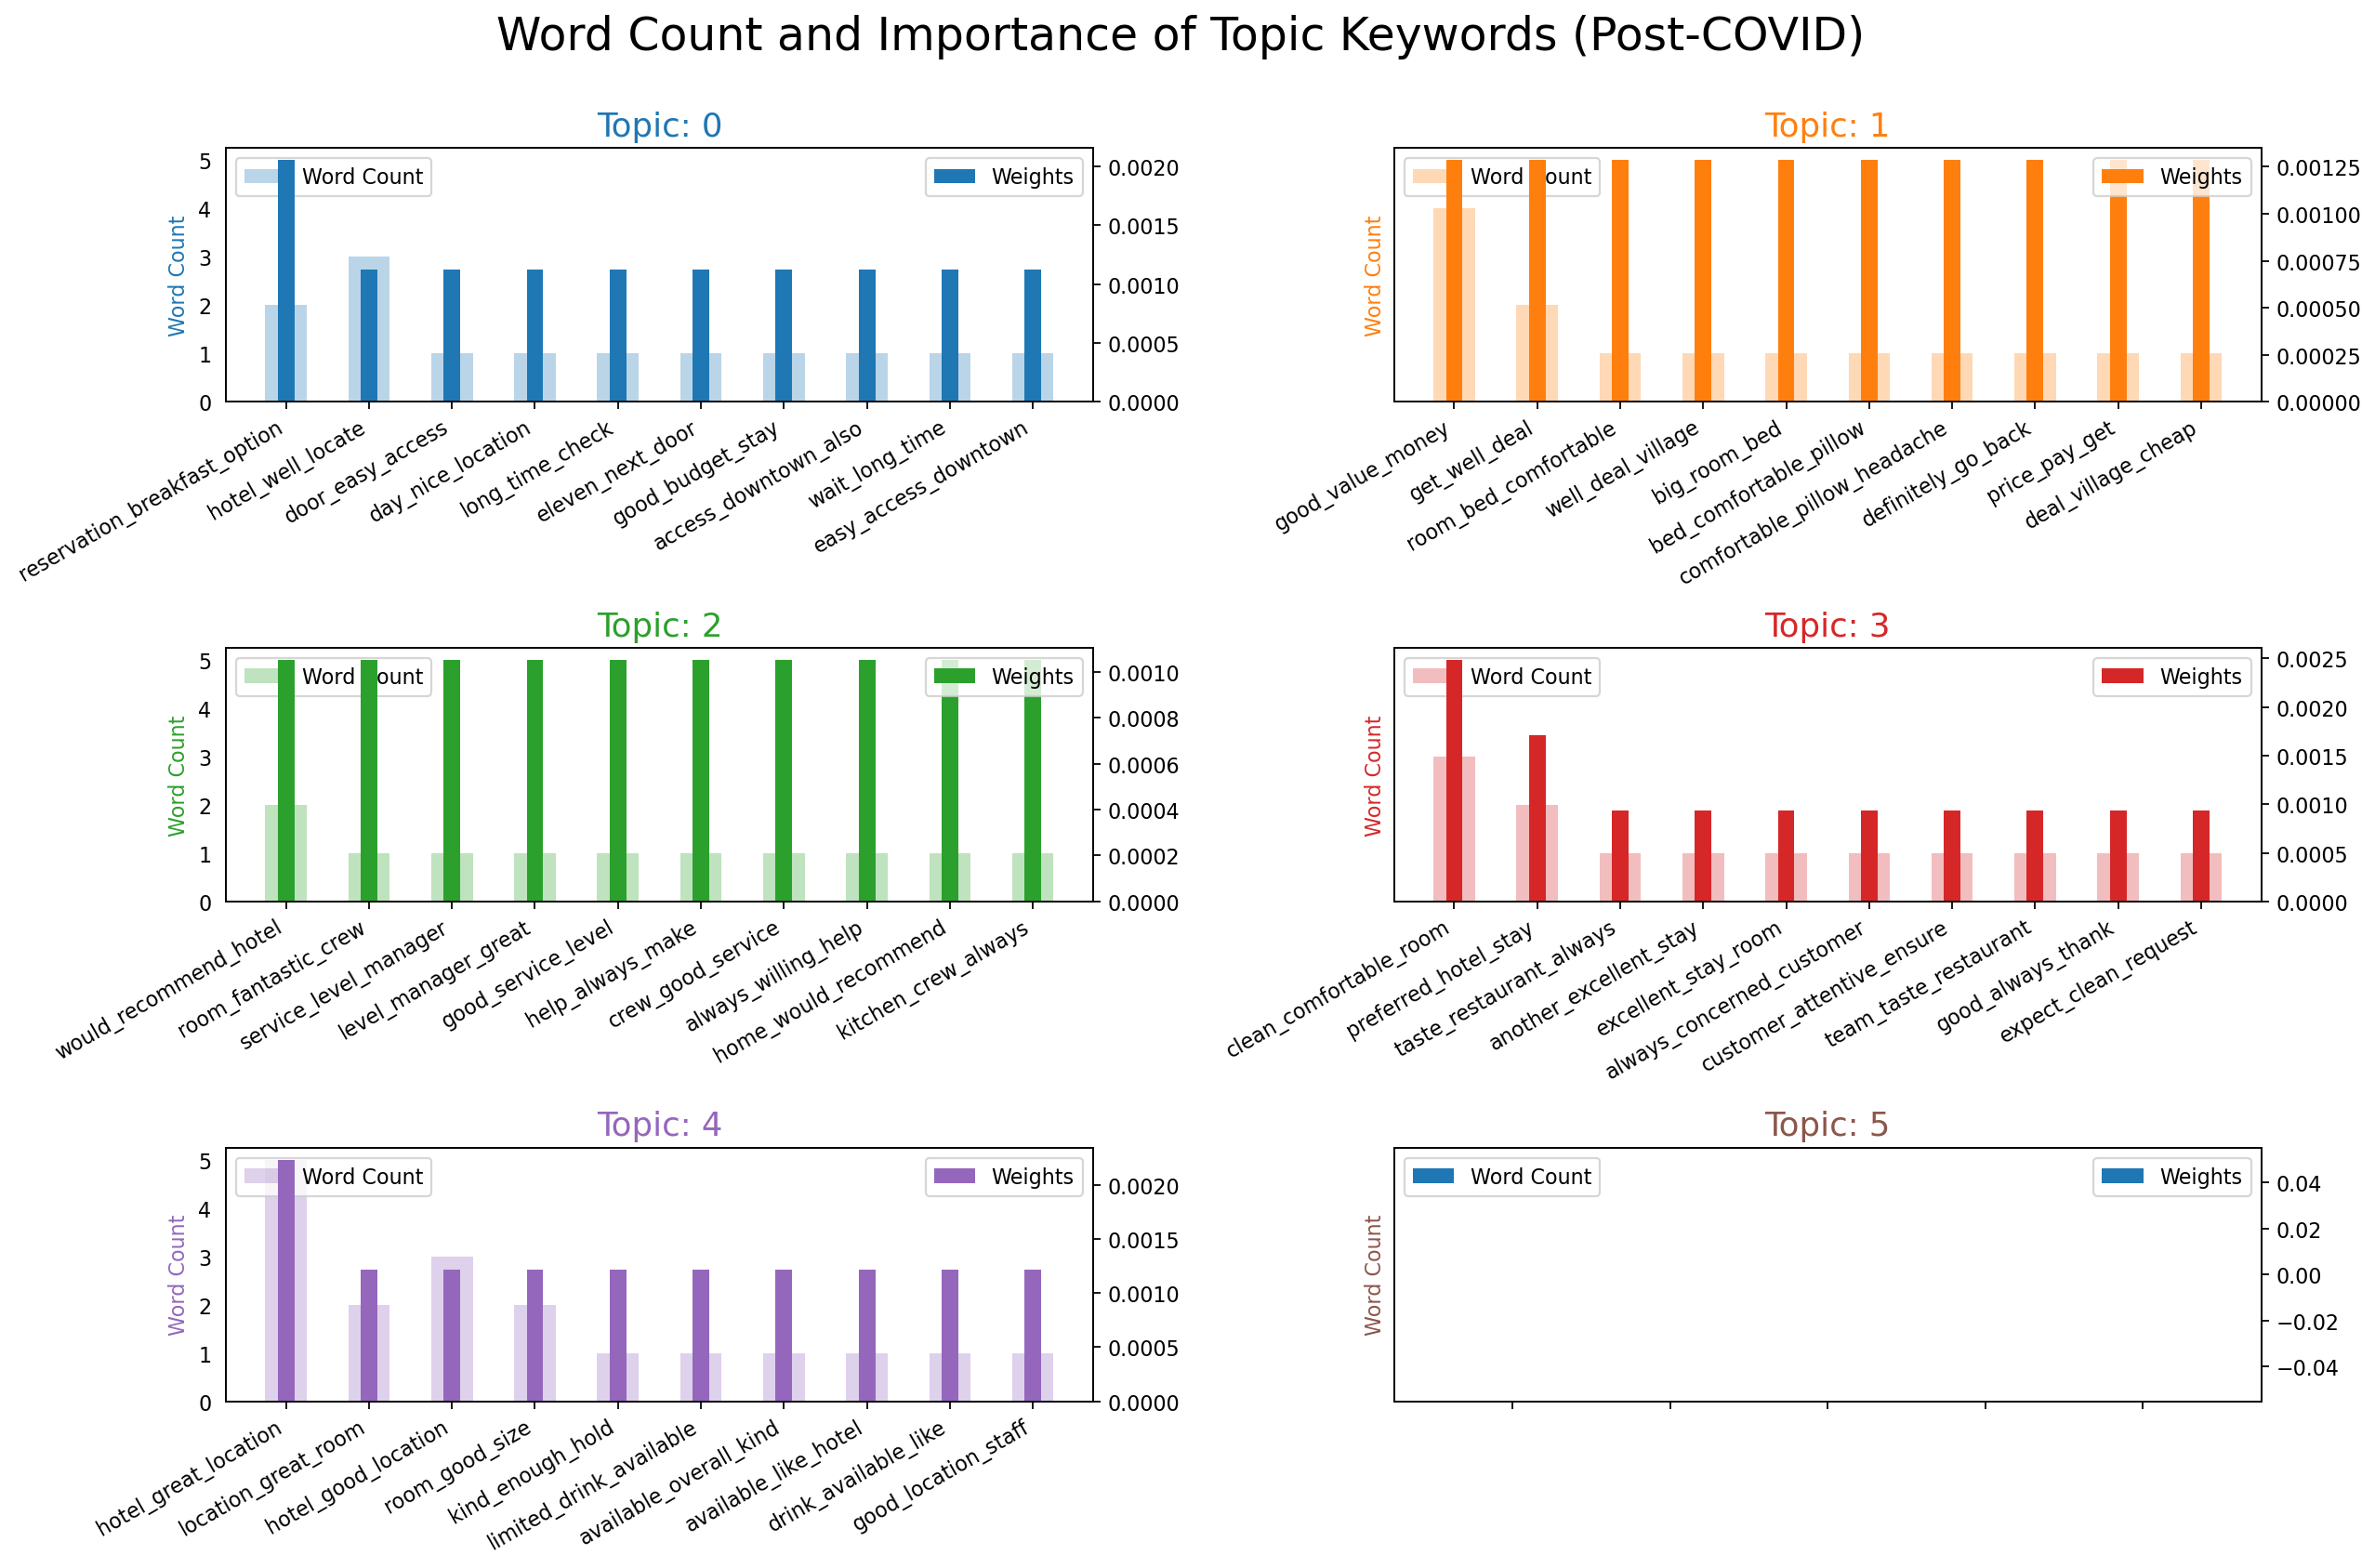

In [93]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')

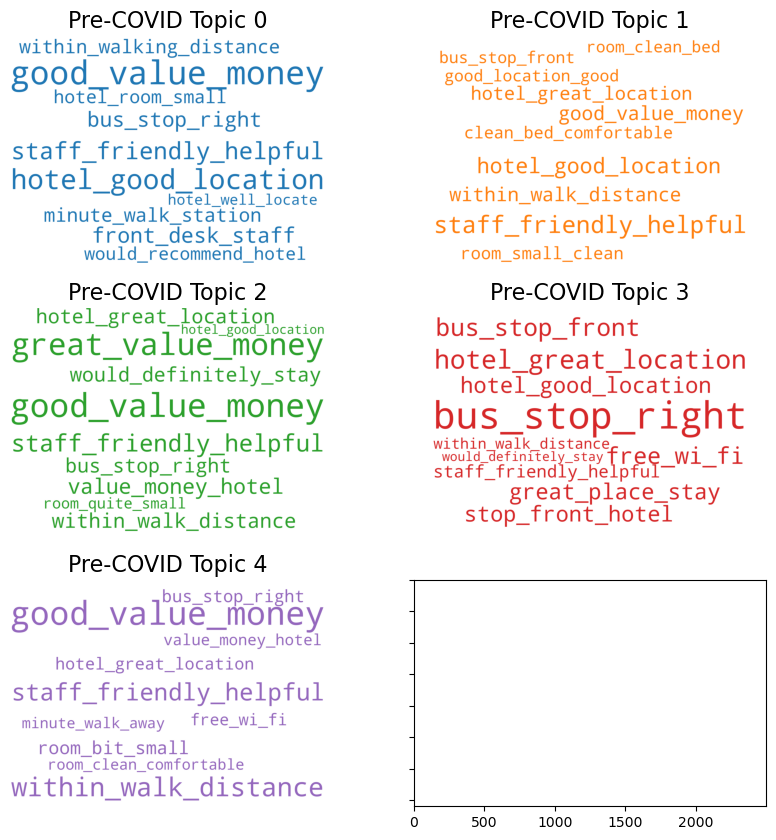

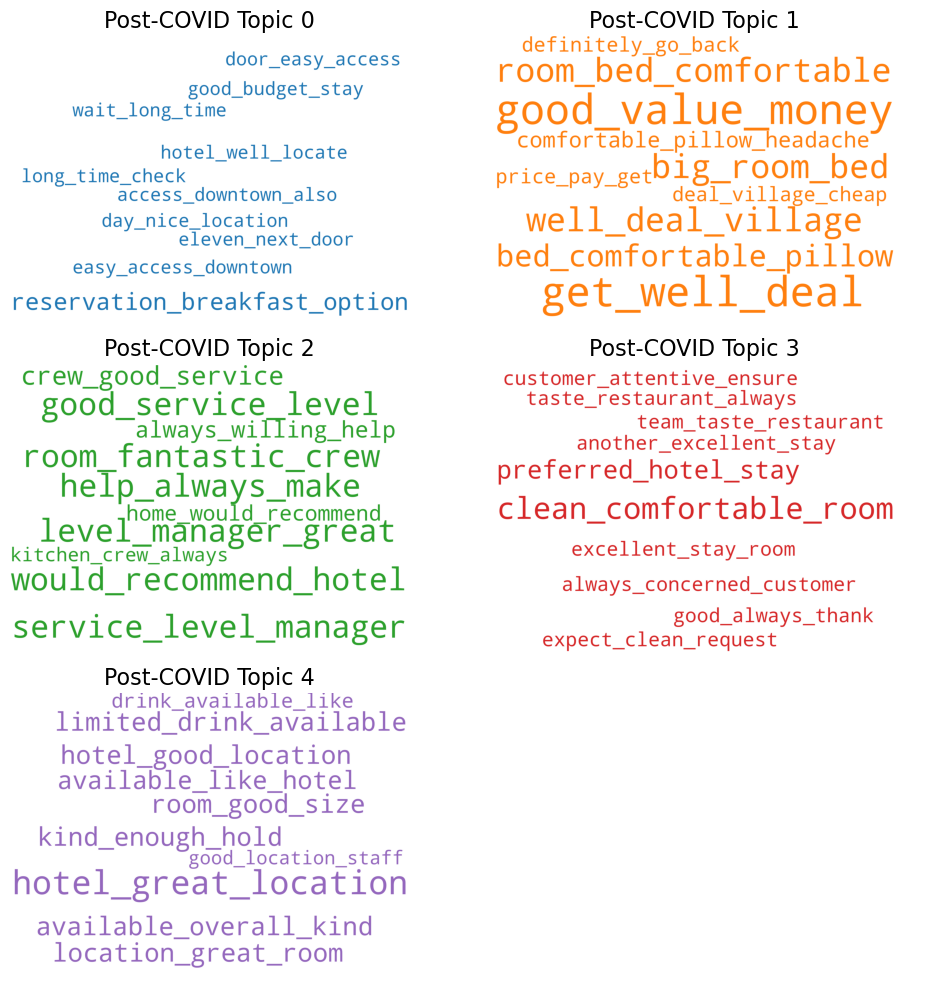

In [94]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Visualising trigrams

In [95]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [96]:
vis = pyLDAvis.gensim.prepare(topic_model=post_ldamodel, corpus=post_corpus, dictionary=post_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)